# Deep learning with ICCD images of plasma plumes generated during pulsed laser deposition

#### Sumner B. Harris

This notebook is designed to provide a functional example of using (2+1)D CNNs to extract deep features from ICCD image sequences for real-time anomaly detection or prediction of materials properties during pulsed laser deposition (PLD).

Start by importing the required packages:

In [1]:
# Import some basics
import os
import datetime

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

# Import our custom helper module
import ICCDutils

# Import Torch stuff
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import random_split, DataLoader
from torchvision import transforms

## Next, we will build our dataset class

This class is used to generate our training and validation sets as well as augment the data during each epoch.

In [2]:
class PLDdataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transform, target_params, augment=True):
        self.df = dataframe
        self.transform = transform
        self.augment = augment

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get growth parameters
        params = torch.tensor([self.df.loc[idx,'P'],self.df.loc[idx,'T'],self.df.loc[idx,'E1'],self.df.loc[idx,'E2']],dtype=torch.float32)
        
        # get targets
        if target_params == 'anomaly':
            target = torch.tensor([self.df.loc[idx,'P'],self.df.loc[idx,'E1'],self.df.loc[idx,'E2']],dtype=torch.float32)
        if target_params == 'growth':
            target = torch.tensor([self.df.loc[idx,'s0'],self.df.loc[idx,'s1'],self.df.loc[idx,'J']],dtype=torch.float32)

        # get ICCD image sequence
        image1 = torch.tensor(self.df.loc[idx,'ICCD'],dtype=torch.float32)

        if self.augment:
            image1 = self.transform(image1)      
            # add measurement noise to parameters for augmentation
            params[0] = params[0] + torch.randn(1)*2*np.sqrt(params[0]*0.00125) # account for 2 sigma, 0.25% baratron accuracy
            params[1] = params[1] + torch.randn(1)*2*np.sqrt(params[1]*0.0075)# account for 2 sigma, 1.5% temperature
            params[2] = params[2] + torch.randn(1)*2*np.sqrt(params[2]*0.0075)# account for 2 sigma, 1.5% laser stability accuracy
            params[3] = params[3] + torch.randn(1)*2*np.sqrt(params[3]*0.0075)# account for 2 sigma, 1.5% laser stability accuracy

        return image1, params, target

## Set up a function to load data and generate the training and validation sets

In [3]:
def load_data(datafile, target, normalize_PTE1E2, train_percent=70):
    # Create a transform for the ICCD images
    transform = transforms.RandomAffine(180,
                                    translate=(0.1,0.1),
                                    shear=10,
                                    scale=(0.8,1.2))
    
    # load the full data from the json file
    df = ICCDutils.load_df(datafile, normalize_PTE1E2=normalize_PTE1E2)
    
    train_number = int(len(df)*train_percent/100)
    val_number = len(df)-train_number
    print('Total number of samples: {}'.format(len(df)))
    print('Number of training samples: {}\nNumber of validation samples: {}'.format(train_number, val_number))
    
    # instantiate the PLDdataset class
    dataset = PLDdataset(df, transform, target)
    
    # set a seed for reproducibility
    generator = torch.Generator().manual_seed(42)
    
    # randomly split the data into training and validation sets
    train_data, val_data = random_split(dataset,[train_number,val_number],generator=generator)
    
    return train_data, val_data

## Build the Model

In [14]:
class MixedICCDNet(nn.Module):
    def __init__(self,features='Mixed',
                 l1=64,l2=32,param_l1=48,param_out=32,c1=16,c2=24,c3=32):
        super(MixedICCDNet, self).__init__()
        self.features = features
        # ICCD imaging feature inputs, the full image size is BATCH,C,frames,H,W where it is N,50,40,40
        self.ICCD_features_ = nn.Sequential(
            #Spatial convolution
            nn.Conv3d(1,64, kernel_size=(1,3,3), stride=(1,1,1), padding=(0,1,1)),
            nn.BatchNorm3d(64),
            #Temportal convolution
            nn.Conv3d(64,64,kernel_size=(3,1,1), stride=(1,1,1), padding=(1,0,0)),
            nn.BatchNorm3d(64),
            nn.LeakyReLU(inplace=True),

            #Downsample
            nn.AvgPool3d(kernel_size=(2,2,2),stride=(2,2,2)),

            #Spatial convolution
            nn.Conv3d(64,128, kernel_size=(1,3,3), stride=(1,1,1), padding=(0,1,1)),
            nn.BatchNorm3d(128),
            #Temportal convolution
            nn.Conv3d(128,128,kernel_size=(3,1,1), stride=(1,1,1), padding=(1,0,0)),
            nn.BatchNorm3d(128),
            nn.LeakyReLU(inplace=True),

            #Downsample
            nn.AvgPool3d(kernel_size=(2,2,2),stride=(2,2,2)),

            #Spatial convolution
            nn.Conv3d(128,256, kernel_size=(1,3,3), stride=(1,1,1), padding=(0,1,1)),
            nn.BatchNorm3d(256),
            #Temportal convolution
            nn.Conv3d(256,256,kernel_size=(3,1,1), stride=(1,1,1), padding=(1,0,0)),
            nn.BatchNorm3d(256),
            nn.LeakyReLU(inplace=True),

            #Downsample
            nn.AvgPool3d(kernel_size=(2,2,2),stride=(2,2,2)),

            nn.Flatten(start_dim=1),
            nn.Linear(256*6*5*5,l1),
            nn.LeakyReLU(inplace=True),
            nn.Linear(l1,l2),
            nn.LeakyReLU(inplace=True))
        
        if features =='ICCD':
            self.ICCD_features_.add_module('out',nn.Linear(l2,3))
        
        
        self.parameter_features = nn.Sequential(
            nn.Linear(4,param_l1),
            nn.LeakyReLU(inplace=True),
            nn.Linear(param_l1,param_out),
            nn.LeakyReLU(inplace=True))
        
        if features =='Params':
            self.parameter_features.add_module('out',nn.Linear(param_out,3))
        
        self.combined_features_ = nn.Sequential(
            nn.Linear(l2+param_out,c1),
            nn.LeakyReLU(inplace=True),
            nn.Linear(c1,c2),
            nn.LeakyReLU(inplace=True),
            nn.Linear(c2,c3),
            nn.LeakyReLU(inplace=True),
            nn.Linear(c3,3),
        )

    def forward(self,x,y):
        if self.features=='Mixed':
            x=self.ICCD_features_(x)
            y=self.parameter_features(y)
            x=x.view(x.shape[0],-1)
            y=y.view(y.shape[0],-1)        
            z = torch.cat((x,y),1)
            z = self.combined_features_(z)        
            return z
        if self.features=='ICCD':
            x=self.ICCD_features_(x)
            return x
        if self.features=='Params':
            y=self.parameter_features(y)
            return y

# Set up the training function

In [5]:
def train(model,train_loader,val_loader,n_epochs,learning_rate,L2, ICCD_checkpoint=None, MLP_checkpoint=None):
        
    if ICCD_checkpoint != None:
        weights = torch.load(ICCD_checkpoint)
        model.load_state_dict(weights,strict=False)
        #Freeze all layers in the ICCD_features_ part
        for param in model.ICCD_features_.parameters():
            param.requires_grad = False
        print('Loaded and froze ICCD layers...')
        for param in model.ICCD_features_.parameters():
            if param.requires_grad:
                print('ERROR:Found trainable in ICCD')
        
    if MLP_checkpoint != None:
        weights = torch.load(MLP_checkpoint)
        model.load_state_dict(weights,strict=False)
        #Freeze all layers in the parameter_features part
        for param in model.parameter_features.parameters():
            param.requires_grad = False
        print('Loaded and froze parameter MLP layers...')
        for param in model.parameter_features.parameters():
            if param.requires_grad:
                print('ERROR:Found trainable in MLP')

    train_loss_list = []
    val_loss_list = []
    r2_list = []
    best_R2 = 0.0

    device = 'cpu'
    if torch.cuda.is_available():
        print('Using GPU.')
        device = "cuda:0"    
        if torch.cuda.device_count() > 1:
            print('Using multiple GPUs.')
            model = nn.DataParallel(model)
    model.to(device)
    loss_fn = nn.MSELoss()
    optimizer=optim.Adam(model.parameters(),lr=learning_rate,amsgrad=True,weight_decay=L2)

    for epoch in range(1,n_epochs+1):
        loss_train = 0.0
        for id_batch, (image,params,target) in enumerate(train_loader):
            image = image.to(device)
            params = params.to(device)
            target = target.to(device)

            optimizer.zero_grad()

            y_pred = model(image,params)
            loss = loss_fn(y_pred, target)

            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        train_pred, train_actuals = y_pred.cpu(), target.cpu()
        train_loss_list.append(loss_train/len(train_loader))
        print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(), epoch,
                                                              loss_train / len(train_loader)))

        size = len(val_loader.dataset)
        num_batches = len(val_loader)
        val_loss = 0.0
        for (image,params,target) in val_loader:
            with torch.no_grad():
                image = image.to(device)
                params = params.to(device)
                target = target.to(device)
                pred = model(image, params)
                val_loss += loss_fn(pred, target).item()

                r2_1 = pearsonr(target[:,0].cpu(), pred[:,0].cpu())[0]**2
                r2_2 = pearsonr(target[:,1].cpu(), pred[:,1].cpu())[0]**2
                r2_3 = pearsonr(target[:,2].cpu(), pred[:,2].cpu())[0]**2
                meanR2 = np.array([r2_1,r2_2,r2_3]).mean()
                print('R2 values {:.4f}, {:.4f}, {:.4f}; mean R2={:.4f}'.format(r2_1,r2_2,r2_3, meanR2))
                r2_list.append([r2_1,r2_2,r2_3,meanR2])

        if meanR2>best_R2:
            print('New best, saving checkpoint...')
            best_R2 = meanR2
            best_val_predictions, best_val_actuals = pred.cpu().detach(), target.cpu().detach()
            best_train_predictions, best_train_actuals = train_pred.cpu().detach(), train_actuals.cpu().detach()
            torch.save(model.state_dict(), '{}.model'.format(checkpoint_name))

        val_loss /= num_batches
        val_loss_list.append(val_loss)
        print(f"Validation Error: Avg loss: {val_loss:>8f} \n")
        
    return (train_loss_list, val_loss_list, r2_list, best_R2, best_val_predictions,\
                best_val_actuals,best_train_predictions, best_train_actuals)

# Set up and train the model for anomaly prediction

The cell below loads the data, defines the predition target, and splits into training and validation sets.

In [6]:
datafile = 'PLD data.json'

# set the target to anomaly to train for P, E1, and E2.
# set the target to 'growth' to train for s0, s1, and J
target_params = 'anomaly'

BATCH_SIZE = 88

#############################
if target_params == 'anomaly':
    normalize_PTE1E2 = False
else:
    normalize_PTE1E2 = True

train_data, val_data = load_data(datafile, target_params, normalize_PTE1E2=normalize_PTE1E2, train_percent=70)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

Total number of samples: 127
Number of training samples: 88
Number of validation samples: 39


In [7]:
# Choose between 'Mixed', 'ICCD', or 'Params'
features_to_use = 'ICCD' 

n_epochs=2000
# the hyperparameters below were found to be optimal for this model during tuning
learning_rate = 0.001055047107715595
L2 = 0.0018287918531623708

checkpoint_name = 'Anomaly ICCD Input Checkpoint'

model = MixedICCDNet(features=features_to_use,
                     l1=64,        # MLP nodes layer 1 for ICCD features
                     l2=32,        # MLP nodes layer 2 for ICCD features
                     param_l1=48,  # MLP nodes layer 1 for parameter features
                     param_out=32, # MLP nodes layer 2 for parameter features
                     c1=16,        # MLP nodes layer 1 for combined features
                     c2=24,        # MLP nodes layer 1 for combined features
                     c3=32)        # MLP nodes layer 1 for combined features

# Train the model
results = train(model,train_loader,val_loader, n_epochs, learning_rate, L2)

Using GPU.
2023-11-08 13:18:14.079274 Epoch 1, Training loss 30717.013671875
R2 values 0.0012, 0.0054, 0.0364; mean R2=0.0143
New best, saving checkpoint...
Validation Error: Avg loss: 29909.894531 

2023-11-08 13:18:14.577725 Epoch 2, Training loss 29090.1796875
R2 values 0.1304, 0.0672, 0.0029; mean R2=0.0668
New best, saving checkpoint...
Validation Error: Avg loss: 27701.900391 

2023-11-08 13:18:15.077937 Epoch 3, Training loss 27017.28515625
R2 values 0.2074, 0.0142, 0.2475; mean R2=0.1564
New best, saving checkpoint...
Validation Error: Avg loss: 25310.962891 

2023-11-08 13:18:15.569007 Epoch 4, Training loss 24721.265625
R2 values 0.1696, 0.0088, 0.0086; mean R2=0.0624
Validation Error: Avg loss: 22766.197266 

2023-11-08 13:18:16.037194 Epoch 5, Training loss 22336.765625
R2 values 0.1350, 0.0012, 0.0093; mean R2=0.0485
Validation Error: Avg loss: 20019.904297 

2023-11-08 13:18:16.493083 Epoch 6, Training loss 19659.015625
R2 values 0.2437, 0.0041, 0.1962; mean R2=0.1480
Val

2023-11-08 13:18:39.081006 Epoch 52, Training loss 4403.92724609375
R2 values 0.5499, 0.0285, 0.0691; mean R2=0.2158
Validation Error: Avg loss: 3635.217773 

2023-11-08 13:18:39.551528 Epoch 53, Training loss 3630.735595703125
R2 values 0.5450, 0.0014, 0.0614; mean R2=0.2026
Validation Error: Avg loss: 3649.206299 

2023-11-08 13:18:40.022471 Epoch 54, Training loss 3816.208251953125
R2 values 0.6058, 0.0046, 0.0470; mean R2=0.2191
Validation Error: Avg loss: 3417.552002 

2023-11-08 13:18:40.517059 Epoch 55, Training loss 3984.17578125
R2 values 0.5431, 0.0041, 0.0421; mean R2=0.1964
Validation Error: Avg loss: 3652.958252 

2023-11-08 13:18:41.016945 Epoch 56, Training loss 3909.110107421875
R2 values 0.5797, 0.0707, 0.0964; mean R2=0.2489
New best, saving checkpoint...
Validation Error: Avg loss: 3433.231445 

2023-11-08 13:18:41.531908 Epoch 57, Training loss 3770.818115234375
R2 values 0.6503, 0.0223, 0.0736; mean R2=0.2487
Validation Error: Avg loss: 3255.695557 

2023-11-08 13:

2023-11-08 13:19:04.148401 Epoch 103, Training loss 2959.397705078125
R2 values 0.6263, 0.0357, 0.2510; mean R2=0.3043
Validation Error: Avg loss: 2872.160400 

2023-11-08 13:19:04.625002 Epoch 104, Training loss 2735.114013671875
R2 values 0.7571, 0.0000, 0.3128; mean R2=0.3566
New best, saving checkpoint...
Validation Error: Avg loss: 2056.461426 

2023-11-08 13:19:05.137998 Epoch 105, Training loss 2938.509033203125
R2 values 0.7291, 0.0278, 0.3061; mean R2=0.3543
Validation Error: Avg loss: 2262.302979 

2023-11-08 13:19:05.695714 Epoch 106, Training loss 3027.673828125
R2 values 0.7295, 0.0001, 0.3506; mean R2=0.3601
New best, saving checkpoint...
Validation Error: Avg loss: 2320.205566 

2023-11-08 13:19:06.208792 Epoch 107, Training loss 2862.809326171875
R2 values 0.7453, 0.0118, 0.2900; mean R2=0.3490
Validation Error: Avg loss: 2221.121582 

2023-11-08 13:19:06.690993 Epoch 108, Training loss 2963.8740234375
R2 values 0.7457, 0.0141, 0.2335; mean R2=0.3311
Validation Error: A

2023-11-08 13:19:29.092977 Epoch 153, Training loss 1643.4080810546875
R2 values 0.9064, 0.1258, 0.4928; mean R2=0.5084
Validation Error: Avg loss: 1033.708252 

2023-11-08 13:19:29.576818 Epoch 154, Training loss 1410.905517578125
R2 values 0.8850, 0.2186, 0.4884; mean R2=0.5307
Validation Error: Avg loss: 1116.591431 

2023-11-08 13:19:30.067200 Epoch 155, Training loss 1503.48974609375
R2 values 0.7496, 0.1551, 0.4892; mean R2=0.4646
Validation Error: Avg loss: 2039.151245 

2023-11-08 13:19:30.569230 Epoch 156, Training loss 1830.3187255859375
R2 values 0.8486, 0.2440, 0.4848; mean R2=0.5258
Validation Error: Avg loss: 1341.381958 

2023-11-08 13:19:31.039425 Epoch 157, Training loss 1523.293701171875
R2 values 0.8250, 0.1768, 0.5085; mean R2=0.5035
Validation Error: Avg loss: 1478.372437 

2023-11-08 13:19:31.533705 Epoch 158, Training loss 1767.976318359375
R2 values 0.8958, 0.0571, 0.5220; mean R2=0.4916
Validation Error: Avg loss: 1070.254028 

2023-11-08 13:19:31.994756 Epoch 

2023-11-08 13:19:54.117328 Epoch 204, Training loss 823.2910766601562
R2 values 0.9456, 0.1758, 0.7460; mean R2=0.6225
Validation Error: Avg loss: 743.404907 

2023-11-08 13:19:54.573234 Epoch 205, Training loss 842.1994018554688
R2 values 0.9656, 0.1121, 0.6961; mean R2=0.5913
Validation Error: Avg loss: 508.312866 

2023-11-08 13:19:55.035461 Epoch 206, Training loss 808.1808471679688
R2 values 0.9386, 0.1835, 0.6890; mean R2=0.6037
Validation Error: Avg loss: 725.160767 

2023-11-08 13:19:55.497829 Epoch 207, Training loss 896.2237548828125
R2 values 0.8876, 0.0956, 0.7052; mean R2=0.5628
Validation Error: Avg loss: 999.763550 

2023-11-08 13:19:55.985066 Epoch 208, Training loss 808.3256225585938
R2 values 0.9430, 0.1514, 0.6819; mean R2=0.5921
Validation Error: Avg loss: 701.146118 

2023-11-08 13:19:56.470415 Epoch 209, Training loss 873.6314697265625
R2 values 0.9285, 0.1564, 0.6270; mean R2=0.5706
Validation Error: Avg loss: 784.489868 

2023-11-08 13:19:57.003854 Epoch 210, Tr

2023-11-08 13:20:18.533743 Epoch 254, Training loss 697.173828125
R2 values 0.9564, 0.5324, 0.7393; mean R2=0.7427
New best, saving checkpoint...
Validation Error: Avg loss: 494.484009 

2023-11-08 13:20:19.003434 Epoch 255, Training loss 615.9353637695312
R2 values 0.9413, 0.4459, 0.7035; mean R2=0.6969
Validation Error: Avg loss: 616.154114 

2023-11-08 13:20:19.457087 Epoch 256, Training loss 650.417724609375
R2 values 0.9347, 0.4947, 0.7548; mean R2=0.7281
Validation Error: Avg loss: 755.187256 

2023-11-08 13:20:19.972572 Epoch 257, Training loss 681.9623413085938
R2 values 0.9231, 0.3759, 0.7264; mean R2=0.6751
Validation Error: Avg loss: 743.187073 

2023-11-08 13:20:20.424784 Epoch 258, Training loss 708.5933227539062
R2 values 0.9140, 0.4484, 0.7389; mean R2=0.7004
Validation Error: Avg loss: 763.635986 

2023-11-08 13:20:20.879716 Epoch 259, Training loss 855.6239624023438
R2 values 0.9234, 0.4194, 0.7638; mean R2=0.7022
Validation Error: Avg loss: 672.463196 

2023-11-08 13:

2023-11-08 13:20:42.467447 Epoch 304, Training loss 438.1043701171875
R2 values 0.9212, 0.6134, 0.7926; mean R2=0.7757
Validation Error: Avg loss: 669.173096 

2023-11-08 13:20:42.917887 Epoch 305, Training loss 487.51605224609375
R2 values 0.9425, 0.5958, 0.7907; mean R2=0.7763
Validation Error: Avg loss: 570.859924 

2023-11-08 13:20:43.374515 Epoch 306, Training loss 541.390869140625
R2 values 0.9175, 0.6469, 0.8080; mean R2=0.7908
Validation Error: Avg loss: 901.312012 

2023-11-08 13:20:43.820505 Epoch 307, Training loss 606.535400390625
R2 values 0.8947, 0.5992, 0.7687; mean R2=0.7542
Validation Error: Avg loss: 938.471069 

2023-11-08 13:20:44.266069 Epoch 308, Training loss 575.5867919921875
R2 values 0.9226, 0.5509, 0.7108; mean R2=0.7281
Validation Error: Avg loss: 840.075500 

2023-11-08 13:20:44.711872 Epoch 309, Training loss 518.2640991210938
R2 values 0.9574, 0.5875, 0.7620; mean R2=0.7690
Validation Error: Avg loss: 469.204407 

2023-11-08 13:20:45.159011 Epoch 310, Tra

2023-11-08 13:21:06.717578 Epoch 355, Training loss 520.8202514648438
R2 values 0.9342, 0.6564, 0.7672; mean R2=0.7859
Validation Error: Avg loss: 646.003174 

2023-11-08 13:21:07.171617 Epoch 356, Training loss 448.639404296875
R2 values 0.9377, 0.6735, 0.7998; mean R2=0.8037
Validation Error: Avg loss: 542.294006 

2023-11-08 13:21:07.614454 Epoch 357, Training loss 382.83941650390625
R2 values 0.9231, 0.7685, 0.8326; mean R2=0.8414
New best, saving checkpoint...
Validation Error: Avg loss: 709.140381 

2023-11-08 13:21:08.122749 Epoch 358, Training loss 423.1319580078125
R2 values 0.9373, 0.7121, 0.8016; mean R2=0.8170
Validation Error: Avg loss: 605.157288 

2023-11-08 13:21:08.575426 Epoch 359, Training loss 399.0406188964844
R2 values 0.9403, 0.6785, 0.8144; mean R2=0.8111
Validation Error: Avg loss: 649.157471 

2023-11-08 13:21:09.020273 Epoch 360, Training loss 394.0489501953125
R2 values 0.9465, 0.7175, 0.7497; mean R2=0.8046
Validation Error: Avg loss: 549.857910 

2023-11-0

2023-11-08 13:21:30.379407 Epoch 406, Training loss 323.9808654785156
R2 values 0.9347, 0.7447, 0.8515; mean R2=0.8436
New best, saving checkpoint...
Validation Error: Avg loss: 533.617920 

2023-11-08 13:21:30.875345 Epoch 407, Training loss 448.90478515625
R2 values 0.9421, 0.6934, 0.8139; mean R2=0.8165
Validation Error: Avg loss: 622.344849 

2023-11-08 13:21:31.356908 Epoch 408, Training loss 345.656982421875
R2 values 0.9460, 0.7366, 0.8679; mean R2=0.8502
New best, saving checkpoint...
Validation Error: Avg loss: 570.339844 

2023-11-08 13:21:31.860736 Epoch 409, Training loss 291.4272766113281
R2 values 0.9243, 0.7015, 0.7956; mean R2=0.8071
Validation Error: Avg loss: 696.315918 

2023-11-08 13:21:32.318807 Epoch 410, Training loss 336.3299255371094
R2 values 0.9144, 0.6886, 0.8114; mean R2=0.8048
Validation Error: Avg loss: 727.700867 

2023-11-08 13:21:32.771030 Epoch 411, Training loss 457.1285095214844
R2 values 0.9511, 0.7126, 0.8081; mean R2=0.8240
Validation Error: Avg 

2023-11-08 13:21:54.176473 Epoch 457, Training loss 299.7511901855469
R2 values 0.9305, 0.7466, 0.7971; mean R2=0.8247
Validation Error: Avg loss: 614.399597 

2023-11-08 13:21:54.618693 Epoch 458, Training loss 409.7590637207031
R2 values 0.9261, 0.7509, 0.8328; mean R2=0.8366
Validation Error: Avg loss: 719.107666 

2023-11-08 13:21:55.071900 Epoch 459, Training loss 353.3584899902344
R2 values 0.9557, 0.7574, 0.8133; mean R2=0.8422
Validation Error: Avg loss: 596.258972 

2023-11-08 13:21:55.521910 Epoch 460, Training loss 308.0521240234375
R2 values 0.9351, 0.7555, 0.8132; mean R2=0.8346
Validation Error: Avg loss: 574.307617 

2023-11-08 13:21:55.959253 Epoch 461, Training loss 343.0601806640625
R2 values 0.9508, 0.7209, 0.8206; mean R2=0.8308
Validation Error: Avg loss: 480.973572 

2023-11-08 13:21:56.401111 Epoch 462, Training loss 310.697021484375
R2 values 0.9419, 0.7474, 0.8465; mean R2=0.8453
Validation Error: Avg loss: 527.735779 

2023-11-08 13:21:56.841634 Epoch 463, Tra

2023-11-08 13:22:20.295272 Epoch 509, Training loss 249.02383422851562
R2 values 0.9289, 0.7556, 0.8467; mean R2=0.8437
Validation Error: Avg loss: 583.053284 

2023-11-08 13:22:20.801797 Epoch 510, Training loss 287.5744934082031
R2 values 0.9488, 0.7812, 0.8327; mean R2=0.8542
Validation Error: Avg loss: 508.727386 

2023-11-08 13:22:21.289587 Epoch 511, Training loss 221.9014892578125
R2 values 0.9486, 0.7888, 0.8249; mean R2=0.8541
Validation Error: Avg loss: 555.678833 

2023-11-08 13:22:21.777373 Epoch 512, Training loss 265.4109191894531
R2 values 0.9639, 0.7738, 0.8600; mean R2=0.8659
Validation Error: Avg loss: 357.418488 

2023-11-08 13:22:22.304581 Epoch 513, Training loss 207.21046447753906
R2 values 0.9528, 0.7698, 0.8496; mean R2=0.8574
Validation Error: Avg loss: 431.556702 

2023-11-08 13:22:22.798786 Epoch 514, Training loss 248.9742889404297
R2 values 0.9489, 0.8018, 0.7941; mean R2=0.8482
Validation Error: Avg loss: 530.089966 

2023-11-08 13:22:23.288937 Epoch 515, 

2023-11-08 13:22:46.072515 Epoch 560, Training loss 218.7578887939453
R2 values 0.9413, 0.7775, 0.8447; mean R2=0.8545
Validation Error: Avg loss: 716.872620 

2023-11-08 13:22:46.554933 Epoch 561, Training loss 311.8204345703125
R2 values 0.9441, 0.8315, 0.8751; mean R2=0.8836
Validation Error: Avg loss: 599.438416 

2023-11-08 13:22:47.042761 Epoch 562, Training loss 267.34014892578125
R2 values 0.9377, 0.8103, 0.8130; mean R2=0.8537
Validation Error: Avg loss: 556.474976 

2023-11-08 13:22:47.542193 Epoch 563, Training loss 287.53656005859375
R2 values 0.9492, 0.7898, 0.8145; mean R2=0.8512
Validation Error: Avg loss: 447.746185 

2023-11-08 13:22:48.046541 Epoch 564, Training loss 282.2156066894531
R2 values 0.9261, 0.7348, 0.8267; mean R2=0.8292
Validation Error: Avg loss: 702.338989 

2023-11-08 13:22:48.541997 Epoch 565, Training loss 289.0291748046875
R2 values 0.9370, 0.7418, 0.8193; mean R2=0.8327
Validation Error: Avg loss: 749.044128 

2023-11-08 13:22:49.156576 Epoch 566, 

2023-11-08 13:23:11.699802 Epoch 611, Training loss 256.7754821777344
R2 values 0.9269, 0.7705, 0.8513; mean R2=0.8496
Validation Error: Avg loss: 596.464417 

2023-11-08 13:23:12.185604 Epoch 612, Training loss 321.5965881347656
R2 values 0.9436, 0.7161, 0.8533; mean R2=0.8377
Validation Error: Avg loss: 661.928833 

2023-11-08 13:23:12.674137 Epoch 613, Training loss 284.8231506347656
R2 values 0.9224, 0.7976, 0.8959; mean R2=0.8720
Validation Error: Avg loss: 799.274048 

2023-11-08 13:23:13.187428 Epoch 614, Training loss 374.4698486328125
R2 values 0.9574, 0.7932, 0.8402; mean R2=0.8636
Validation Error: Avg loss: 407.747437 

2023-11-08 13:23:13.678566 Epoch 615, Training loss 240.62596130371094
R2 values 0.9368, 0.7727, 0.8390; mean R2=0.8495
Validation Error: Avg loss: 585.601501 

2023-11-08 13:23:14.168546 Epoch 616, Training loss 407.873291015625
R2 values 0.9548, 0.8114, 0.8665; mean R2=0.8776
Validation Error: Avg loss: 572.428284 

2023-11-08 13:23:14.669442 Epoch 617, Tr

2023-11-08 13:23:37.885572 Epoch 663, Training loss 227.16665649414062
R2 values 0.9481, 0.7904, 0.8869; mean R2=0.8751
Validation Error: Avg loss: 566.007202 

2023-11-08 13:23:38.401993 Epoch 664, Training loss 185.0224609375
R2 values 0.9496, 0.7911, 0.8750; mean R2=0.8719
Validation Error: Avg loss: 493.431915 

2023-11-08 13:23:38.897330 Epoch 665, Training loss 173.14329528808594
R2 values 0.9655, 0.7898, 0.8342; mean R2=0.8632
Validation Error: Avg loss: 411.327484 

2023-11-08 13:23:39.389219 Epoch 666, Training loss 200.55250549316406
R2 values 0.9659, 0.8059, 0.8303; mean R2=0.8674
Validation Error: Avg loss: 497.805450 

2023-11-08 13:23:39.890335 Epoch 667, Training loss 167.89813232421875
R2 values 0.9554, 0.7737, 0.8818; mean R2=0.8703
Validation Error: Avg loss: 443.355347 

2023-11-08 13:23:40.390476 Epoch 668, Training loss 198.60633850097656
R2 values 0.9594, 0.7490, 0.8087; mean R2=0.8390
Validation Error: Avg loss: 436.263733 

2023-11-08 13:23:40.866905 Epoch 669, 

2023-11-08 13:24:03.670433 Epoch 715, Training loss 177.7269744873047
R2 values 0.9552, 0.8244, 0.8445; mean R2=0.8747
Validation Error: Avg loss: 388.152496 

2023-11-08 13:24:04.152076 Epoch 716, Training loss 193.0048828125
R2 values 0.9524, 0.7336, 0.8737; mean R2=0.8532
Validation Error: Avg loss: 438.783752 

2023-11-08 13:24:04.718009 Epoch 717, Training loss 132.11032104492188
R2 values 0.9496, 0.8202, 0.7823; mean R2=0.8507
Validation Error: Avg loss: 564.516479 

2023-11-08 13:24:05.205459 Epoch 718, Training loss 139.7473602294922
R2 values 0.9437, 0.7354, 0.8529; mean R2=0.8440
Validation Error: Avg loss: 674.562927 

2023-11-08 13:24:05.700668 Epoch 719, Training loss 231.91587829589844
R2 values 0.9359, 0.7879, 0.8431; mean R2=0.8556
Validation Error: Avg loss: 606.064575 

2023-11-08 13:24:06.209317 Epoch 720, Training loss 181.22789001464844
R2 values 0.9506, 0.7756, 0.8303; mean R2=0.8522
Validation Error: Avg loss: 449.926544 

2023-11-08 13:24:06.696446 Epoch 721, Tr

R2 values 0.9620, 0.8110, 0.8500; mean R2=0.8743
Validation Error: Avg loss: 381.750610 

2023-11-08 13:24:30.286660 Epoch 767, Training loss 213.13116455078125
R2 values 0.9570, 0.8598, 0.8674; mean R2=0.8947
Validation Error: Avg loss: 524.111938 

2023-11-08 13:24:30.789381 Epoch 768, Training loss 254.18682861328125
R2 values 0.9443, 0.8019, 0.8719; mean R2=0.8727
Validation Error: Avg loss: 575.331604 

2023-11-08 13:24:31.289462 Epoch 769, Training loss 170.21360778808594
R2 values 0.9612, 0.7970, 0.8655; mean R2=0.8746
Validation Error: Avg loss: 412.833588 

2023-11-08 13:24:31.798689 Epoch 770, Training loss 241.92762756347656
R2 values 0.9501, 0.8234, 0.8681; mean R2=0.8806
Validation Error: Avg loss: 480.177307 

2023-11-08 13:24:32.316447 Epoch 771, Training loss 186.89010620117188
R2 values 0.9331, 0.7972, 0.8806; mean R2=0.8703
Validation Error: Avg loss: 667.578186 

2023-11-08 13:24:32.855115 Epoch 772, Training loss 209.77645874023438
R2 values 0.9572, 0.7760, 0.8644; 

2023-11-08 13:24:55.877470 Epoch 818, Training loss 150.59812927246094
R2 values 0.9396, 0.8500, 0.8753; mean R2=0.8883
Validation Error: Avg loss: 515.924133 

2023-11-08 13:24:56.371397 Epoch 819, Training loss 220.4471893310547
R2 values 0.9607, 0.8562, 0.8548; mean R2=0.8906
Validation Error: Avg loss: 402.804443 

2023-11-08 13:24:56.866001 Epoch 820, Training loss 190.31741333007812
R2 values 0.9572, 0.8210, 0.8525; mean R2=0.8769
Validation Error: Avg loss: 568.545227 

2023-11-08 13:24:57.416065 Epoch 821, Training loss 227.3144073486328
R2 values 0.9393, 0.8499, 0.8387; mean R2=0.8760
Validation Error: Avg loss: 680.186462 

2023-11-08 13:24:57.972587 Epoch 822, Training loss 222.0948944091797
R2 values 0.9468, 0.8807, 0.8196; mean R2=0.8824
Validation Error: Avg loss: 476.521149 

2023-11-08 13:24:58.466652 Epoch 823, Training loss 173.16830444335938
R2 values 0.9449, 0.8354, 0.8305; mean R2=0.8703
Validation Error: Avg loss: 516.355469 

2023-11-08 13:24:58.953334 Epoch 824,

2023-11-08 13:25:21.951657 Epoch 869, Training loss 188.72012329101562
R2 values 0.9416, 0.8287, 0.8576; mean R2=0.8759
Validation Error: Avg loss: 529.614136 

2023-11-08 13:25:22.434745 Epoch 870, Training loss 163.4537811279297
R2 values 0.9612, 0.8274, 0.8793; mean R2=0.8893
Validation Error: Avg loss: 384.174438 

2023-11-08 13:25:22.915321 Epoch 871, Training loss 141.29039001464844
R2 values 0.9639, 0.8391, 0.8892; mean R2=0.8974
Validation Error: Avg loss: 365.006439 

2023-11-08 13:25:23.386853 Epoch 872, Training loss 144.04872131347656
R2 values 0.9598, 0.8085, 0.8258; mean R2=0.8647
Validation Error: Avg loss: 675.646362 

2023-11-08 13:25:23.866391 Epoch 873, Training loss 242.5682373046875
R2 values 0.9549, 0.8369, 0.8814; mean R2=0.8911
Validation Error: Avg loss: 555.255676 

2023-11-08 13:25:24.355475 Epoch 874, Training loss 166.44720458984375
R2 values 0.9466, 0.7735, 0.9014; mean R2=0.8738
Validation Error: Avg loss: 456.421570 

2023-11-08 13:25:24.843448 Epoch 875

2023-11-08 13:25:47.804908 Epoch 921, Training loss 223.11106872558594
R2 values 0.9155, 0.7193, 0.8575; mean R2=0.8307
Validation Error: Avg loss: 797.070679 

2023-11-08 13:25:48.290637 Epoch 922, Training loss 223.70974731445312
R2 values 0.9590, 0.8308, 0.8472; mean R2=0.8790
Validation Error: Avg loss: 444.645782 

2023-11-08 13:25:48.779995 Epoch 923, Training loss 154.1364288330078
R2 values 0.9552, 0.8403, 0.8490; mean R2=0.8815
Validation Error: Avg loss: 441.339203 

2023-11-08 13:25:49.261444 Epoch 924, Training loss 264.6053771972656
R2 values 0.9506, 0.8173, 0.8774; mean R2=0.8818
Validation Error: Avg loss: 426.365173 

2023-11-08 13:25:49.767278 Epoch 925, Training loss 167.9646453857422
R2 values 0.9591, 0.8610, 0.8751; mean R2=0.8984
Validation Error: Avg loss: 367.439178 

2023-11-08 13:25:50.259214 Epoch 926, Training loss 138.730712890625
R2 values 0.9552, 0.8026, 0.8656; mean R2=0.8745
Validation Error: Avg loss: 594.744507 

2023-11-08 13:25:50.784004 Epoch 927, T

2023-11-08 13:26:13.864179 Epoch 973, Training loss 173.63485717773438
R2 values 0.9391, 0.7601, 0.8863; mean R2=0.8619
Validation Error: Avg loss: 544.406494 

2023-11-08 13:26:14.349936 Epoch 974, Training loss 127.87671661376953
R2 values 0.9438, 0.8374, 0.8646; mean R2=0.8819
Validation Error: Avg loss: 459.895721 

2023-11-08 13:26:14.836862 Epoch 975, Training loss 159.9779815673828
R2 values 0.9580, 0.7880, 0.8520; mean R2=0.8660
Validation Error: Avg loss: 416.646179 

2023-11-08 13:26:15.314850 Epoch 976, Training loss 161.32550048828125
R2 values 0.9553, 0.8353, 0.8621; mean R2=0.8843
Validation Error: Avg loss: 492.603333 

2023-11-08 13:26:15.795807 Epoch 977, Training loss 108.08200073242188
R2 values 0.9454, 0.8277, 0.8689; mean R2=0.8806
Validation Error: Avg loss: 520.798279 

2023-11-08 13:26:16.270629 Epoch 978, Training loss 103.10154724121094
R2 values 0.9410, 0.8441, 0.8649; mean R2=0.8834
Validation Error: Avg loss: 568.390137 

2023-11-08 13:26:16.892732 Epoch 97

2023-11-08 13:26:39.060031 Epoch 1024, Training loss 162.95960998535156
R2 values 0.9499, 0.8481, 0.8821; mean R2=0.8934
Validation Error: Avg loss: 424.609711 

2023-11-08 13:26:39.550485 Epoch 1025, Training loss 150.80162048339844
R2 values 0.9394, 0.8347, 0.8876; mean R2=0.8872
Validation Error: Avg loss: 536.442383 

2023-11-08 13:26:40.063996 Epoch 1026, Training loss 138.49461364746094
R2 values 0.9409, 0.8280, 0.8756; mean R2=0.8815
Validation Error: Avg loss: 569.286682 

2023-11-08 13:26:40.555546 Epoch 1027, Training loss 168.10675048828125
R2 values 0.9557, 0.8495, 0.8625; mean R2=0.8893
Validation Error: Avg loss: 447.543304 

2023-11-08 13:26:41.050307 Epoch 1028, Training loss 124.56648254394531
R2 values 0.9413, 0.8119, 0.8799; mean R2=0.8777
Validation Error: Avg loss: 493.308563 

2023-11-08 13:26:41.540303 Epoch 1029, Training loss 114.18621826171875
R2 values 0.9584, 0.8180, 0.8527; mean R2=0.8764
Validation Error: Avg loss: 388.205444 

2023-11-08 13:26:42.025033 E

2023-11-08 13:27:04.276096 Epoch 1075, Training loss 109.17113494873047
R2 values 0.9682, 0.8448, 0.8433; mean R2=0.8854
Validation Error: Avg loss: 348.105316 

2023-11-08 13:27:04.763082 Epoch 1076, Training loss 117.84748077392578
R2 values 0.9484, 0.8590, 0.8683; mean R2=0.8919
Validation Error: Avg loss: 500.447754 

2023-11-08 13:27:05.254073 Epoch 1077, Training loss 110.21426391601562
R2 values 0.9523, 0.7976, 0.8495; mean R2=0.8665
Validation Error: Avg loss: 481.720734 

2023-11-08 13:27:05.727160 Epoch 1078, Training loss 124.97804260253906
R2 values 0.9528, 0.8126, 0.8557; mean R2=0.8737
Validation Error: Avg loss: 450.750214 

2023-11-08 13:27:06.253776 Epoch 1079, Training loss 110.2879867553711
R2 values 0.9606, 0.8023, 0.8620; mean R2=0.8750
Validation Error: Avg loss: 388.479858 

2023-11-08 13:27:06.730976 Epoch 1080, Training loss 114.32565307617188
R2 values 0.9520, 0.8181, 0.8781; mean R2=0.8827
Validation Error: Avg loss: 412.434723 

2023-11-08 13:27:07.223451 Ep

2023-11-08 13:27:29.237267 Epoch 1126, Training loss 108.95696258544922
R2 values 0.9623, 0.8242, 0.8695; mean R2=0.8854
Validation Error: Avg loss: 456.902863 

2023-11-08 13:27:29.794020 Epoch 1127, Training loss 153.53733825683594
R2 values 0.9502, 0.8324, 0.8806; mean R2=0.8877
Validation Error: Avg loss: 463.466003 

2023-11-08 13:27:30.272512 Epoch 1128, Training loss 117.21179962158203
R2 values 0.9578, 0.8230, 0.8566; mean R2=0.8792
Validation Error: Avg loss: 405.698547 

2023-11-08 13:27:30.745859 Epoch 1129, Training loss 129.1129608154297
R2 values 0.9506, 0.8517, 0.8477; mean R2=0.8833
Validation Error: Avg loss: 446.260742 

2023-11-08 13:27:31.299228 Epoch 1130, Training loss 101.85875701904297
R2 values 0.9570, 0.8477, 0.8808; mean R2=0.8952
Validation Error: Avg loss: 378.066315 

2023-11-08 13:27:31.845257 Epoch 1131, Training loss 94.82542419433594
R2 values 0.9563, 0.8153, 0.8721; mean R2=0.8812
Validation Error: Avg loss: 507.389313 

2023-11-08 13:27:32.319067 Epo

2023-11-08 13:27:54.526886 Epoch 1177, Training loss 141.90713500976562
R2 values 0.9524, 0.8413, 0.8560; mean R2=0.8832
Validation Error: Avg loss: 417.053558 

2023-11-08 13:27:55.178215 Epoch 1178, Training loss 109.77486419677734
R2 values 0.9514, 0.8454, 0.9005; mean R2=0.8991
Validation Error: Avg loss: 555.744995 

2023-11-08 13:27:55.765003 Epoch 1179, Training loss 172.70909118652344
R2 values 0.9586, 0.8424, 0.8797; mean R2=0.8936
Validation Error: Avg loss: 383.608429 

2023-11-08 13:27:56.247330 Epoch 1180, Training loss 112.43806457519531
R2 values 0.9452, 0.8325, 0.8877; mean R2=0.8884
Validation Error: Avg loss: 498.555969 

2023-11-08 13:27:56.728807 Epoch 1181, Training loss 171.07150268554688
R2 values 0.9508, 0.8289, 0.8804; mean R2=0.8867
Validation Error: Avg loss: 467.115723 

2023-11-08 13:27:57.199363 Epoch 1182, Training loss 145.19590759277344
R2 values 0.9548, 0.8610, 0.8640; mean R2=0.8933
Validation Error: Avg loss: 559.586304 

2023-11-08 13:27:57.681913 E

2023-11-08 13:28:19.816398 Epoch 1228, Training loss 117.64961242675781
R2 values 0.9560, 0.8280, 0.8654; mean R2=0.8831
Validation Error: Avg loss: 389.025848 

2023-11-08 13:28:20.509960 Epoch 1229, Training loss 91.77079772949219
R2 values 0.9429, 0.8265, 0.8907; mean R2=0.8867
Validation Error: Avg loss: 482.412140 

2023-11-08 13:28:21.058365 Epoch 1230, Training loss 155.82530212402344
R2 values 0.9506, 0.8234, 0.8914; mean R2=0.8884
Validation Error: Avg loss: 411.839905 

2023-11-08 13:28:21.539196 Epoch 1231, Training loss 76.07129669189453
R2 values 0.9359, 0.8045, 0.8893; mean R2=0.8766
Validation Error: Avg loss: 559.807739 

2023-11-08 13:28:22.019861 Epoch 1232, Training loss 129.48423767089844
R2 values 0.9411, 0.8547, 0.8753; mean R2=0.8904
Validation Error: Avg loss: 510.201385 

2023-11-08 13:28:22.494097 Epoch 1233, Training loss 131.24276733398438
R2 values 0.9419, 0.8249, 0.8867; mean R2=0.8845
Validation Error: Avg loss: 597.735046 

2023-11-08 13:28:22.972122 Epo

2023-11-08 13:28:45.098661 Epoch 1279, Training loss 126.75349426269531
R2 values 0.9522, 0.8287, 0.8734; mean R2=0.8847
Validation Error: Avg loss: 548.769714 

2023-11-08 13:28:45.618077 Epoch 1280, Training loss 108.39622497558594
R2 values 0.9587, 0.8548, 0.8983; mean R2=0.9039
Validation Error: Avg loss: 430.153809 

2023-11-08 13:28:46.100212 Epoch 1281, Training loss 97.77877807617188
R2 values 0.9448, 0.8445, 0.8762; mean R2=0.8885
Validation Error: Avg loss: 452.026642 

2023-11-08 13:28:46.561456 Epoch 1282, Training loss 120.34252166748047
R2 values 0.9496, 0.8524, 0.8860; mean R2=0.8960
Validation Error: Avg loss: 441.128998 

2023-11-08 13:28:47.033179 Epoch 1283, Training loss 138.47483825683594
R2 values 0.9540, 0.8367, 0.8979; mean R2=0.8962
Validation Error: Avg loss: 476.964111 

2023-11-08 13:28:47.511070 Epoch 1284, Training loss 100.67267608642578
R2 values 0.9444, 0.8095, 0.9055; mean R2=0.8865
Validation Error: Avg loss: 580.970398 

2023-11-08 13:28:48.006642 Ep

2023-11-08 13:29:10.181590 Epoch 1330, Training loss 87.12275695800781
R2 values 0.9580, 0.8491, 0.9054; mean R2=0.9042
Validation Error: Avg loss: 363.549774 

2023-11-08 13:29:10.661962 Epoch 1331, Training loss 119.39346313476562
R2 values 0.9353, 0.8089, 0.8826; mean R2=0.8756
Validation Error: Avg loss: 527.816162 

2023-11-08 13:29:11.138017 Epoch 1332, Training loss 96.91350555419922
R2 values 0.9356, 0.8669, 0.8709; mean R2=0.8911
Validation Error: Avg loss: 545.054443 

2023-11-08 13:29:11.622095 Epoch 1333, Training loss 90.42914581298828
R2 values 0.9272, 0.8131, 0.8587; mean R2=0.8664
Validation Error: Avg loss: 670.858704 

2023-11-08 13:29:12.185203 Epoch 1334, Training loss 96.9597396850586
R2 values 0.9580, 0.8412, 0.8459; mean R2=0.8817
Validation Error: Avg loss: 548.878845 

2023-11-08 13:29:12.666508 Epoch 1335, Training loss 96.660888671875
R2 values 0.9582, 0.8009, 0.8624; mean R2=0.8738
Validation Error: Avg loss: 379.008667 

2023-11-08 13:29:13.326633 Epoch 133

2023-11-08 13:29:35.146389 Epoch 1381, Training loss 163.17031860351562
R2 values 0.9393, 0.7998, 0.9097; mean R2=0.8829
Validation Error: Avg loss: 613.546082 

2023-11-08 13:29:35.627217 Epoch 1382, Training loss 119.7951431274414
R2 values 0.9573, 0.8389, 0.8743; mean R2=0.8902
Validation Error: Avg loss: 389.363983 

2023-11-08 13:29:36.104944 Epoch 1383, Training loss 106.54961395263672
R2 values 0.9367, 0.8361, 0.8689; mean R2=0.8806
Validation Error: Avg loss: 531.823547 

2023-11-08 13:29:36.618584 Epoch 1384, Training loss 102.08402252197266
R2 values 0.9433, 0.8520, 0.8719; mean R2=0.8891
Validation Error: Avg loss: 492.810059 

2023-11-08 13:29:37.106797 Epoch 1385, Training loss 89.15301513671875
R2 values 0.9525, 0.8420, 0.9056; mean R2=0.9000
Validation Error: Avg loss: 441.489960 

2023-11-08 13:29:37.708560 Epoch 1386, Training loss 135.68154907226562
R2 values 0.9512, 0.8489, 0.8910; mean R2=0.8970
Validation Error: Avg loss: 454.214294 

2023-11-08 13:29:38.188686 Epo

2023-11-08 13:29:59.911229 Epoch 1432, Training loss 89.23136901855469
R2 values 0.9494, 0.8053, 0.8885; mean R2=0.8811
Validation Error: Avg loss: 596.621155 

2023-11-08 13:30:00.486856 Epoch 1433, Training loss 104.93513488769531
R2 values 0.9536, 0.8267, 0.8453; mean R2=0.8752
Validation Error: Avg loss: 581.284729 

2023-11-08 13:30:01.181502 Epoch 1434, Training loss 93.58096313476562
R2 values 0.9528, 0.8412, 0.8977; mean R2=0.8972
Validation Error: Avg loss: 426.989410 

2023-11-08 13:30:01.650030 Epoch 1435, Training loss 86.31340026855469
R2 values 0.9532, 0.8029, 0.8819; mean R2=0.8794
Validation Error: Avg loss: 397.657257 

2023-11-08 13:30:02.135977 Epoch 1436, Training loss 119.20178985595703
R2 values 0.9534, 0.8597, 0.8467; mean R2=0.8866
Validation Error: Avg loss: 436.940155 

2023-11-08 13:30:02.737180 Epoch 1437, Training loss 73.09069061279297
R2 values 0.9625, 0.8413, 0.8721; mean R2=0.8920
Validation Error: Avg loss: 410.409698 

2023-11-08 13:30:03.197872 Epoch

2023-11-08 13:30:24.864444 Epoch 1483, Training loss 93.3354263305664
R2 values 0.9459, 0.8414, 0.8559; mean R2=0.8811
Validation Error: Avg loss: 558.972534 

2023-11-08 13:30:25.341524 Epoch 1484, Training loss 117.32493591308594
R2 values 0.9368, 0.8062, 0.9027; mean R2=0.8819
Validation Error: Avg loss: 627.440491 

2023-11-08 13:30:25.812749 Epoch 1485, Training loss 151.4522705078125
R2 values 0.9501, 0.8218, 0.8764; mean R2=0.8827
Validation Error: Avg loss: 460.846344 

2023-11-08 13:30:26.342498 Epoch 1486, Training loss 151.482666015625
R2 values 0.9653, 0.8727, 0.8919; mean R2=0.9100
Validation Error: Avg loss: 350.367950 

2023-11-08 13:30:26.814733 Epoch 1487, Training loss 139.92559814453125
R2 values 0.9432, 0.8262, 0.9130; mean R2=0.8941
Validation Error: Avg loss: 562.636780 

2023-11-08 13:30:27.304522 Epoch 1488, Training loss 91.60679626464844
R2 values 0.9514, 0.8307, 0.8993; mean R2=0.8938
Validation Error: Avg loss: 547.398743 

2023-11-08 13:30:27.785046 Epoch 1

2023-11-08 13:30:49.854774 Epoch 1534, Training loss 139.00009155273438
R2 values 0.9520, 0.8509, 0.8942; mean R2=0.8990
Validation Error: Avg loss: 417.356476 

2023-11-08 13:30:50.346477 Epoch 1535, Training loss 91.73101043701172
R2 values 0.9436, 0.8458, 0.9180; mean R2=0.9025
Validation Error: Avg loss: 519.251099 

2023-11-08 13:30:50.825890 Epoch 1536, Training loss 84.65602111816406
R2 values 0.9577, 0.8267, 0.9094; mean R2=0.8979
Validation Error: Avg loss: 609.783447 

2023-11-08 13:30:51.302024 Epoch 1537, Training loss 152.60450744628906
R2 values 0.9537, 0.8535, 0.8855; mean R2=0.8975
Validation Error: Avg loss: 411.720703 

2023-11-08 13:30:51.986332 Epoch 1538, Training loss 86.70379638671875
R2 values 0.9494, 0.7771, 0.8444; mean R2=0.8570
Validation Error: Avg loss: 461.951935 

2023-11-08 13:30:52.491326 Epoch 1539, Training loss 151.90773010253906
R2 values 0.9415, 0.8232, 0.8959; mean R2=0.8869
Validation Error: Avg loss: 465.621063 

2023-11-08 13:30:52.974813 Epoc

2023-11-08 13:31:15.015305 Epoch 1585, Training loss 94.09825897216797
R2 values 0.9402, 0.8226, 0.8964; mean R2=0.8864
Validation Error: Avg loss: 526.011353 

2023-11-08 13:31:15.492485 Epoch 1586, Training loss 84.2928695678711
R2 values 0.9458, 0.8789, 0.8700; mean R2=0.8983
Validation Error: Avg loss: 514.228882 

2023-11-08 13:31:16.061548 Epoch 1587, Training loss 94.21589660644531
R2 values 0.9509, 0.8656, 0.8985; mean R2=0.9050
Validation Error: Avg loss: 432.786346 

2023-11-08 13:31:16.591614 Epoch 1588, Training loss 79.4885025024414
R2 values 0.9519, 0.8542, 0.9046; mean R2=0.9036
Validation Error: Avg loss: 426.384338 

2023-11-08 13:31:17.072531 Epoch 1589, Training loss 76.83616638183594
R2 values 0.9430, 0.8541, 0.8799; mean R2=0.8923
Validation Error: Avg loss: 480.152466 

2023-11-08 13:31:17.556877 Epoch 1590, Training loss 68.13670349121094
R2 values 0.9368, 0.8338, 0.8731; mean R2=0.8812
Validation Error: Avg loss: 594.280457 

2023-11-08 13:31:18.049388 Epoch 159

2023-11-08 13:31:40.059833 Epoch 1636, Training loss 100.83221435546875
R2 values 0.9531, 0.8487, 0.8947; mean R2=0.8988
Validation Error: Avg loss: 418.080231 

2023-11-08 13:31:40.547435 Epoch 1637, Training loss 89.14922332763672
R2 values 0.9496, 0.8293, 0.9096; mean R2=0.8962
Validation Error: Avg loss: 513.205750 

2023-11-08 13:31:41.131702 Epoch 1638, Training loss 98.65996551513672
R2 values 0.9491, 0.8751, 0.9062; mean R2=0.9101
Validation Error: Avg loss: 470.914978 

2023-11-08 13:31:41.733800 Epoch 1639, Training loss 87.99018096923828
R2 values 0.9392, 0.8196, 0.8993; mean R2=0.8860
Validation Error: Avg loss: 506.186279 

2023-11-08 13:31:42.210564 Epoch 1640, Training loss 74.39391326904297
R2 values 0.9389, 0.8469, 0.9018; mean R2=0.8959
Validation Error: Avg loss: 495.558411 

2023-11-08 13:31:42.698957 Epoch 1641, Training loss 85.47087097167969
R2 values 0.9544, 0.8653, 0.8993; mean R2=0.9063
Validation Error: Avg loss: 420.588562 

2023-11-08 13:31:43.175386 Epoch 

2023-11-08 13:32:05.856826 Epoch 1688, Training loss 60.818538665771484
R2 values 0.9468, 0.8412, 0.9122; mean R2=0.9001
Validation Error: Avg loss: 462.781555 

2023-11-08 13:32:06.338605 Epoch 1689, Training loss 76.07344055175781
R2 values 0.9457, 0.8453, 0.8579; mean R2=0.8830
Validation Error: Avg loss: 506.501160 

2023-11-08 13:32:06.821328 Epoch 1690, Training loss 80.53321838378906
R2 values 0.9393, 0.8597, 0.8953; mean R2=0.8981
Validation Error: Avg loss: 661.418701 

2023-11-08 13:32:07.582810 Epoch 1691, Training loss 89.17701721191406
R2 values 0.9483, 0.8489, 0.8843; mean R2=0.8938
Validation Error: Avg loss: 513.194397 

2023-11-08 13:32:08.082047 Epoch 1692, Training loss 84.15596008300781
R2 values 0.9564, 0.8475, 0.8863; mean R2=0.8968
Validation Error: Avg loss: 386.839783 

2023-11-08 13:32:08.578816 Epoch 1693, Training loss 66.7990951538086
R2 values 0.9586, 0.8567, 0.8927; mean R2=0.9027
Validation Error: Avg loss: 363.887177 

2023-11-08 13:32:09.079074 Epoch 1

2023-11-08 13:32:31.641062 Epoch 1739, Training loss 82.92815399169922
R2 values 0.9460, 0.8313, 0.9234; mean R2=0.9003
Validation Error: Avg loss: 435.022797 

2023-11-08 13:32:32.135571 Epoch 1740, Training loss 49.42388916015625
R2 values 0.9540, 0.8346, 0.9082; mean R2=0.8989
Validation Error: Avg loss: 367.393524 

2023-11-08 13:32:32.616226 Epoch 1741, Training loss 76.98014068603516
R2 values 0.9510, 0.8273, 0.8756; mean R2=0.8846
Validation Error: Avg loss: 406.846710 

2023-11-08 13:32:33.091602 Epoch 1742, Training loss 79.29022216796875
R2 values 0.9601, 0.8402, 0.8957; mean R2=0.8987
Validation Error: Avg loss: 376.573395 

2023-11-08 13:32:33.584053 Epoch 1743, Training loss 60.92411422729492
R2 values 0.9511, 0.8565, 0.9279; mean R2=0.9118
Validation Error: Avg loss: 473.472565 

2023-11-08 13:32:34.072028 Epoch 1744, Training loss 59.915279388427734
R2 values 0.9558, 0.8555, 0.9133; mean R2=0.9082
Validation Error: Avg loss: 448.946045 

2023-11-08 13:32:34.552784 Epoch 

2023-11-08 13:32:57.102997 Epoch 1790, Training loss 87.68730926513672
R2 values 0.9562, 0.8628, 0.8958; mean R2=0.9049
Validation Error: Avg loss: 390.872955 

2023-11-08 13:32:57.586660 Epoch 1791, Training loss 88.06410217285156
R2 values 0.9425, 0.8612, 0.8821; mean R2=0.8952
Validation Error: Avg loss: 447.905701 

2023-11-08 13:32:58.072298 Epoch 1792, Training loss 106.27934265136719
R2 values 0.9372, 0.7826, 0.8484; mean R2=0.8561
Validation Error: Avg loss: 524.296509 

2023-11-08 13:32:58.550254 Epoch 1793, Training loss 62.975276947021484
R2 values 0.9379, 0.8469, 0.8629; mean R2=0.8826
Validation Error: Avg loss: 603.435852 

2023-11-08 13:32:59.054591 Epoch 1794, Training loss 78.27533721923828
R2 values 0.9543, 0.8218, 0.9133; mean R2=0.8964
Validation Error: Avg loss: 415.979736 

2023-11-08 13:32:59.634905 Epoch 1795, Training loss 75.0024185180664
R2 values 0.9554, 0.8161, 0.8724; mean R2=0.8813
Validation Error: Avg loss: 441.742676 

2023-11-08 13:33:00.118757 Epoch 

2023-11-08 13:33:22.262687 Epoch 1841, Training loss 76.1491928100586
R2 values 0.9474, 0.8515, 0.8924; mean R2=0.8971
Validation Error: Avg loss: 428.939606 

2023-11-08 13:33:22.749210 Epoch 1842, Training loss 83.14629364013672
R2 values 0.9479, 0.8627, 0.8947; mean R2=0.9017
Validation Error: Avg loss: 417.301270 

2023-11-08 13:33:23.250017 Epoch 1843, Training loss 79.90323638916016
R2 values 0.9389, 0.8911, 0.9108; mean R2=0.9136
Validation Error: Avg loss: 487.843231 

2023-11-08 13:33:23.733292 Epoch 1844, Training loss 74.20509338378906
R2 values 0.9429, 0.8329, 0.8703; mean R2=0.8820
Validation Error: Avg loss: 488.696075 

2023-11-08 13:33:24.211122 Epoch 1845, Training loss 73.60285186767578
R2 values 0.9447, 0.8344, 0.9034; mean R2=0.8942
Validation Error: Avg loss: 432.428009 

2023-11-08 13:33:24.698068 Epoch 1846, Training loss 79.63090515136719
R2 values 0.9459, 0.8251, 0.8928; mean R2=0.8880
Validation Error: Avg loss: 455.979126 

2023-11-08 13:33:25.192099 Epoch 18

2023-11-08 13:33:47.487938 Epoch 1892, Training loss 69.22693634033203
R2 values 0.9557, 0.8686, 0.8886; mean R2=0.9043
Validation Error: Avg loss: 395.355988 

2023-11-08 13:33:47.960080 Epoch 1893, Training loss 73.52107238769531
R2 values 0.9443, 0.8642, 0.8600; mean R2=0.8895
Validation Error: Avg loss: 509.974976 

2023-11-08 13:33:48.445673 Epoch 1894, Training loss 63.346561431884766
R2 values 0.9547, 0.8621, 0.8785; mean R2=0.8984
Validation Error: Avg loss: 421.042297 

2023-11-08 13:33:48.941237 Epoch 1895, Training loss 67.40741729736328
R2 values 0.9481, 0.8527, 0.9067; mean R2=0.9025
Validation Error: Avg loss: 487.750763 

2023-11-08 13:33:49.679311 Epoch 1896, Training loss 49.735389709472656
R2 values 0.9529, 0.8512, 0.9139; mean R2=0.9060
Validation Error: Avg loss: 388.427002 

2023-11-08 13:33:50.180489 Epoch 1897, Training loss 72.00267791748047
R2 values 0.9629, 0.8562, 0.8794; mean R2=0.8995
Validation Error: Avg loss: 376.814941 

2023-11-08 13:33:50.660493 Epoch

2023-11-08 13:34:13.101510 Epoch 1943, Training loss 76.74774169921875
R2 values 0.9497, 0.8627, 0.8837; mean R2=0.8987
Validation Error: Avg loss: 420.453064 

2023-11-08 13:34:13.840232 Epoch 1944, Training loss 85.72233581542969
R2 values 0.9587, 0.8657, 0.9068; mean R2=0.9104
Validation Error: Avg loss: 358.424896 

2023-11-08 13:34:14.356341 Epoch 1945, Training loss 61.69830322265625
R2 values 0.9514, 0.8546, 0.9213; mean R2=0.9091
Validation Error: Avg loss: 484.041901 

2023-11-08 13:34:14.840852 Epoch 1946, Training loss 63.69737243652344
R2 values 0.9430, 0.8418, 0.9188; mean R2=0.9012
Validation Error: Avg loss: 530.529053 

2023-11-08 13:34:15.324031 Epoch 1947, Training loss 101.55968475341797
R2 values 0.9466, 0.8115, 0.8981; mean R2=0.8854
Validation Error: Avg loss: 542.932739 

2023-11-08 13:34:15.799645 Epoch 1948, Training loss 51.67051696777344
R2 values 0.9444, 0.8301, 0.9083; mean R2=0.8943
Validation Error: Avg loss: 453.762268 

2023-11-08 13:34:16.278963 Epoch 

2023-11-08 13:34:38.755968 Epoch 1994, Training loss 65.74826049804688
R2 values 0.9575, 0.8658, 0.8936; mean R2=0.9056
Validation Error: Avg loss: 420.591431 

2023-11-08 13:34:39.245036 Epoch 1995, Training loss 50.5992317199707
R2 values 0.9515, 0.8634, 0.8962; mean R2=0.9037
Validation Error: Avg loss: 423.478516 

2023-11-08 13:34:39.826719 Epoch 1996, Training loss 57.688655853271484
R2 values 0.9493, 0.8250, 0.9026; mean R2=0.8923
Validation Error: Avg loss: 415.014832 

2023-11-08 13:34:40.313007 Epoch 1997, Training loss 42.81220245361328
R2 values 0.9622, 0.8484, 0.8972; mean R2=0.9026
Validation Error: Avg loss: 369.383301 

2023-11-08 13:34:40.804265 Epoch 1998, Training loss 60.494972229003906
R2 values 0.9483, 0.8233, 0.9085; mean R2=0.8934
Validation Error: Avg loss: 469.131042 

2023-11-08 13:34:41.289804 Epoch 1999, Training loss 58.54547882080078
R2 values 0.9636, 0.8546, 0.9009; mean R2=0.9064
Validation Error: Avg loss: 337.971558 

2023-11-08 13:34:41.796250 Epoch 

# Visualize the training results
Plot the learning curves and the predicted vs actual values.

In [8]:
train_loss_list, val_loss_list, r2_list, best_R2, best_val_predictions,\
best_val_actuals,best_train_predictions, best_train_actuals = results

The best r2 value was: 0.9172193787071231


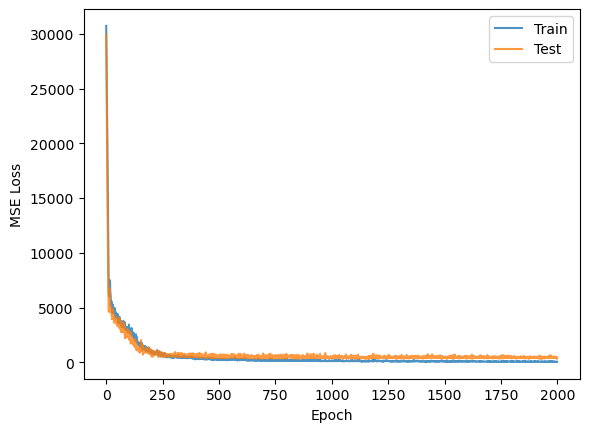

In [9]:
print('The best r2 value was:', best_R2)

fig, ax = plt.subplots()
ax.plot(train_loss_list, label='Train',alpha=0.8)
ax.plot(val_loss_list,label='Test',alpha=0.8)

#ax.set_ylim(0,2000)
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss')
ax.legend()

#plt.savefig('101923 Mixed ICCD 3HL predict s0s1J optimized model Learning Curve.png',)
plt.show()

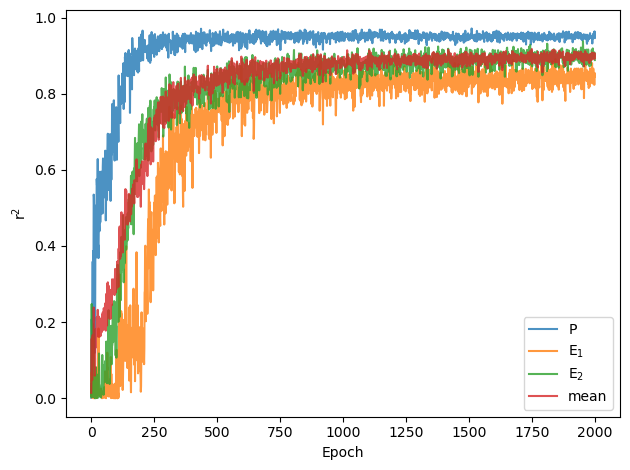

In [10]:
r2_array = np.array(r2_list)
labels = ['P', 'E$_1$', 'E$_2$', 'mean']

fig, ax = plt.subplots()
for i in range(r2_array.shape[1]):
    ax.plot(r2_array[:,i],label=labels[i],alpha=0.8)

ax.set_xlabel('Epoch')
ax.set_ylabel('r$^2$')
ax.legend()
ax.tick_params(axis='both')
plt.tight_layout()
plt.show()

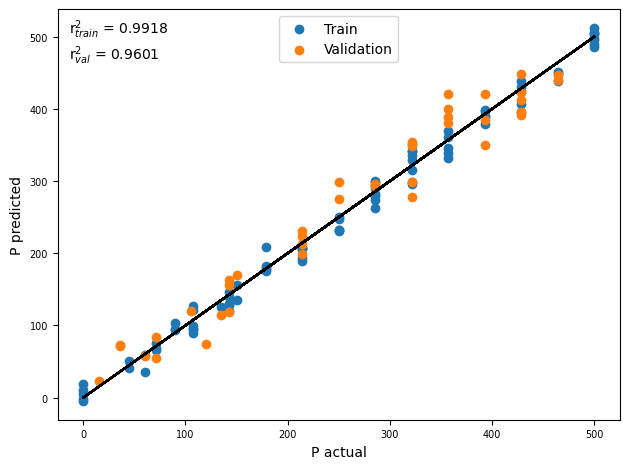

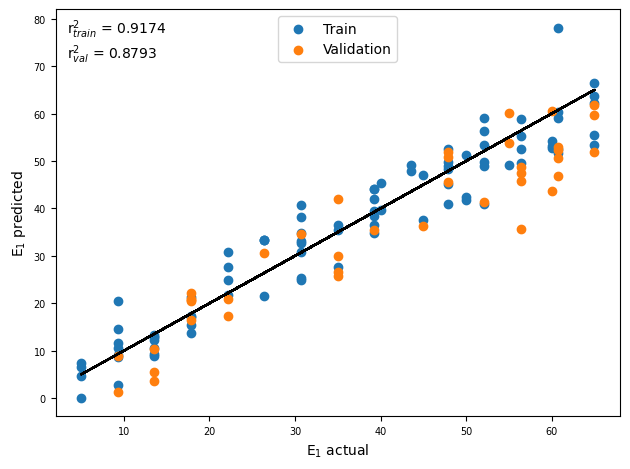

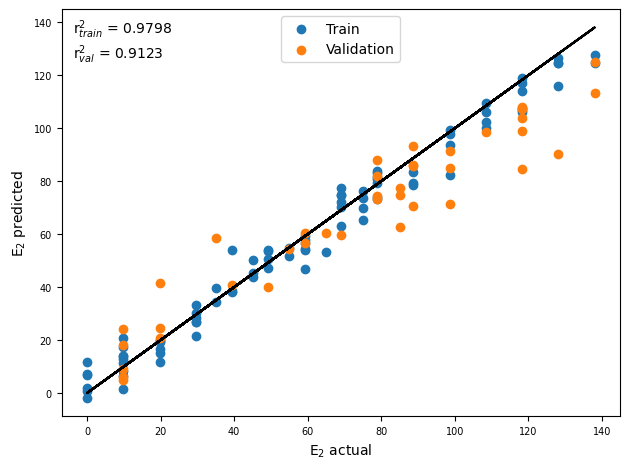

In [11]:
def plot_predictions(train_pred, train_actual, val_pred, val_actual, index, title):
    fig, ax = plt.subplots()
    
    r2_train = pearsonr(train_actual[:,index], train_pred[:,index])[0]**2
    r2_val = pearsonr(val_actual[:,index], val_pred[:,index])[0]**2
    
    ax.scatter(train_actual[:,index],train_pred[:,index],label='Train')
    ax.scatter(val_actual[:,index],val_pred[:,index],label='Validation')
    ax.plot(train_actual[:,index],train_actual[:,index],c='k')
    
    plt.text(0.02, 0.98, 'r$^2_{train}$ = %.4f\nr$^2_{val}$ = %.4f' % (r2_train,r2_val),
     horizontalalignment='left',
     verticalalignment='top',
     transform = ax.transAxes)

    ax.legend(loc='upper center')
        
    ax.set_xlabel('{} actual'.format(title))
    ax.set_ylabel('{} predicted'.format(title))
    ax.tick_params(axis='both')
    
    return ax

labels = ['P', 'E$_1$', 'E$_2$']
atten = [1,1,1]

for i,label in enumerate(labels):
    ax = plot_predictions(best_train_predictions/atten[i],best_train_actuals/atten[i],
                     best_val_predictions/atten[i], best_val_actuals/atten[i],i,label)
    ax.tick_params(axis='both', labelsize=7)
    plt.tight_layout()

    
    

# Train for growth kinetics using the ICCD features only

In [12]:
datafile = 'PLD data.json'

# set the target to anomaly to train for P, E1, and E2.
# set the target to 'growth' to train for s0, s1, and J
target_params = 'growth'

BATCH_SIZE = 88

#############################
if target_params == 'anomaly':
    normalize_PTE1E2 = False
else:
    normalize_PTE1E2 = True

train_data, val_data = load_data(datafile, target_params, normalize_PTE1E2=normalize_PTE1E2, train_percent=70)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

Total number of samples: 127
Number of training samples: 88
Number of validation samples: 39


In [13]:
# Choose between 'Mixed', 'ICCD', or 'Params'
features_to_use = 'ICCD' 

n_epochs=2000
learning_rate = 0.0014129147018238114
L2 = 0.0005312227896860003

checkpoint_name = 'Growth Kinetics ICCD Input Checkpoint'

model = MixedICCDNet(features=features_to_use,
                     l1=64,        # MLP nodes layer 1 for ICCD features
                     l2=32,        # MLP nodes layer 2 for ICCD features
                     param_l1=48,  # MLP nodes layer 1 for parameter features
                     param_out=32, # MLP nodes layer 2 for parameter features
                     c1=16,        # MLP nodes layer 1 for combined features
                     c2=24,        # MLP nodes layer 1 for combined features
                     c3=32)        # MLP nodes layer 1 for combined features

# Train the model
results = train(model,train_loader,val_loader, n_epochs, learning_rate, L2)

Using GPU.
2023-11-08 13:34:45.583533 Epoch 1, Training loss 24.344568252563477
R2 values 0.1083, 0.0026, 0.1880; mean R2=0.0996
New best, saving checkpoint...
Validation Error: Avg loss: 43.061535 

2023-11-08 13:34:46.095809 Epoch 2, Training loss 47.08574676513672
R2 values 0.2031, 0.0042, 0.2020; mean R2=0.1364
New best, saving checkpoint...
Validation Error: Avg loss: 13.236775 

2023-11-08 13:34:46.642671 Epoch 3, Training loss 12.725981712341309
R2 values 0.0000, 0.0001, 0.2369; mean R2=0.0790
Validation Error: Avg loss: 21.428040 

2023-11-08 13:34:47.129696 Epoch 4, Training loss 18.384174346923828
R2 values 0.0059, 0.0203, 0.2561; mean R2=0.0941
Validation Error: Avg loss: 17.586103 

2023-11-08 13:34:47.611378 Epoch 5, Training loss 15.569114685058594
R2 values 0.2098, 0.0156, 0.2401; mean R2=0.1552
New best, saving checkpoint...
Validation Error: Avg loss: 13.073273 

2023-11-08 13:34:48.113381 Epoch 6, Training loss 11.873319625854492
R2 values 0.1538, 0.0558, 0.3000; mean

2023-11-08 13:35:10.930942 Epoch 51, Training loss 3.9138128757476807
R2 values 0.6474, 0.3556, 0.5397; mean R2=0.5142
Validation Error: Avg loss: 8.070448 

2023-11-08 13:35:11.437107 Epoch 52, Training loss 4.363337516784668
R2 values 0.6588, 0.4119, 0.5220; mean R2=0.5309
Validation Error: Avg loss: 7.630685 

2023-11-08 13:35:11.913730 Epoch 53, Training loss 4.886879920959473
R2 values 0.6842, 0.6986, 0.7208; mean R2=0.7012
New best, saving checkpoint...
Validation Error: Avg loss: 4.243939 

2023-11-08 13:35:12.404784 Epoch 54, Training loss 4.451486587524414
R2 values 0.6743, 0.4420, 0.7676; mean R2=0.6280
Validation Error: Avg loss: 6.741308 

2023-11-08 13:35:12.870531 Epoch 55, Training loss 4.855813026428223
R2 values 0.6895, 0.5033, 0.7604; mean R2=0.6511
Validation Error: Avg loss: 6.378070 

2023-11-08 13:35:13.330191 Epoch 56, Training loss 4.705197334289551
R2 values 0.5822, 0.6033, 0.6992; mean R2=0.6282
Validation Error: Avg loss: 5.688840 

2023-11-08 13:35:13.791103

2023-11-08 13:35:35.483133 Epoch 103, Training loss 3.475977659225464
R2 values 0.6979, 0.5366, 0.6432; mean R2=0.6259
Validation Error: Avg loss: 6.217067 

2023-11-08 13:35:36.010013 Epoch 104, Training loss 3.072439193725586
R2 values 0.6958, 0.5641, 0.7181; mean R2=0.6593
Validation Error: Avg loss: 5.278739 

2023-11-08 13:35:36.475444 Epoch 105, Training loss 3.154384136199951
R2 values 0.6480, 0.6078, 0.6718; mean R2=0.6425
Validation Error: Avg loss: 4.861710 

2023-11-08 13:35:36.938282 Epoch 106, Training loss 3.4468741416931152
R2 values 0.6923, 0.6354, 0.7585; mean R2=0.6954
Validation Error: Avg loss: 4.329766 

2023-11-08 13:35:37.403472 Epoch 107, Training loss 3.1716294288635254
R2 values 0.5315, 0.7000, 0.7185; mean R2=0.6500
Validation Error: Avg loss: 4.708929 

2023-11-08 13:35:37.868273 Epoch 108, Training loss 3.402570962905884
R2 values 0.6426, 0.6615, 0.6936; mean R2=0.6659
Validation Error: Avg loss: 4.836097 

2023-11-08 13:35:38.350893 Epoch 109, Training los

2023-11-08 13:36:00.144057 Epoch 155, Training loss 2.4238638877868652
R2 values 0.5613, 0.6497, 0.7663; mean R2=0.6591
Validation Error: Avg loss: 4.937950 

2023-11-08 13:36:00.626407 Epoch 156, Training loss 1.9919743537902832
R2 values 0.6649, 0.6870, 0.7588; mean R2=0.7035
Validation Error: Avg loss: 4.431592 

2023-11-08 13:36:01.103148 Epoch 157, Training loss 2.1399717330932617
R2 values 0.6081, 0.7097, 0.7971; mean R2=0.7050
Validation Error: Avg loss: 4.045684 

2023-11-08 13:36:01.578123 Epoch 158, Training loss 2.10984468460083
R2 values 0.6500, 0.6466, 0.7548; mean R2=0.6838
Validation Error: Avg loss: 4.891511 

2023-11-08 13:36:02.054834 Epoch 159, Training loss 2.302056074142456
R2 values 0.7190, 0.6430, 0.7765; mean R2=0.7129
Validation Error: Avg loss: 4.778341 

2023-11-08 13:36:02.534179 Epoch 160, Training loss 2.1480228900909424
R2 values 0.6878, 0.6979, 0.7747; mean R2=0.7202
Validation Error: Avg loss: 4.022400 

2023-11-08 13:36:03.009680 Epoch 161, Training lo

2023-11-08 13:36:25.253321 Epoch 207, Training loss 1.4346694946289062
R2 values 0.7253, 0.7234, 0.8764; mean R2=0.7750
Validation Error: Avg loss: 3.908185 

2023-11-08 13:36:25.736013 Epoch 208, Training loss 1.2818689346313477
R2 values 0.7262, 0.8192, 0.8486; mean R2=0.7980
New best, saving checkpoint...
Validation Error: Avg loss: 2.698155 

2023-11-08 13:36:26.227587 Epoch 209, Training loss 1.7516050338745117
R2 values 0.7833, 0.7286, 0.8460; mean R2=0.7860
Validation Error: Avg loss: 3.548857 

2023-11-08 13:36:26.691761 Epoch 210, Training loss 1.3023381233215332
R2 values 0.7146, 0.7432, 0.8052; mean R2=0.7543
Validation Error: Avg loss: 3.698842 

2023-11-08 13:36:27.151983 Epoch 211, Training loss 1.7034510374069214
R2 values 0.6883, 0.8023, 0.8488; mean R2=0.7798
Validation Error: Avg loss: 2.705579 

2023-11-08 13:36:27.614704 Epoch 212, Training loss 1.641249179840088
R2 values 0.6833, 0.7370, 0.8649; mean R2=0.7617
Validation Error: Avg loss: 3.333556 

2023-11-08 13:36

2023-11-08 13:36:49.849119 Epoch 258, Training loss 1.1001044511795044
R2 values 0.7732, 0.6655, 0.8565; mean R2=0.7651
Validation Error: Avg loss: 4.480665 

2023-11-08 13:36:50.310699 Epoch 259, Training loss 1.0241484642028809
R2 values 0.6761, 0.6642, 0.8455; mean R2=0.7286
Validation Error: Avg loss: 5.131372 

2023-11-08 13:36:50.786286 Epoch 260, Training loss 1.3042484521865845
R2 values 0.7547, 0.7397, 0.8313; mean R2=0.7752
Validation Error: Avg loss: 4.043232 

2023-11-08 13:36:51.253940 Epoch 261, Training loss 0.9709551334381104
R2 values 0.7112, 0.7161, 0.8217; mean R2=0.7497
Validation Error: Avg loss: 4.375911 

2023-11-08 13:36:51.720364 Epoch 262, Training loss 0.9047942161560059
R2 values 0.7116, 0.6754, 0.8157; mean R2=0.7342
Validation Error: Avg loss: 4.508945 

2023-11-08 13:36:52.180968 Epoch 263, Training loss 0.9266862869262695
R2 values 0.7464, 0.7621, 0.8895; mean R2=0.7993
Validation Error: Avg loss: 2.942619 

2023-11-08 13:36:52.652235 Epoch 264, Training

2023-11-08 13:37:14.534164 Epoch 310, Training loss 0.6880312561988831
R2 values 0.7219, 0.7305, 0.8477; mean R2=0.7667
Validation Error: Avg loss: 3.744431 

2023-11-08 13:37:15.008072 Epoch 311, Training loss 0.6909816861152649
R2 values 0.7503, 0.7130, 0.8118; mean R2=0.7584
Validation Error: Avg loss: 4.069803 

2023-11-08 13:37:15.464294 Epoch 312, Training loss 0.8235350847244263
R2 values 0.6572, 0.7237, 0.8266; mean R2=0.7358
Validation Error: Avg loss: 3.792835 

2023-11-08 13:37:15.925431 Epoch 313, Training loss 0.8130718469619751
R2 values 0.6063, 0.7408, 0.8937; mean R2=0.7469
Validation Error: Avg loss: 3.524168 

2023-11-08 13:37:16.380579 Epoch 314, Training loss 0.90235835313797
R2 values 0.6019, 0.6921, 0.8000; mean R2=0.6980
Validation Error: Avg loss: 4.632468 

2023-11-08 13:37:16.836675 Epoch 315, Training loss 0.8447617292404175
R2 values 0.6524, 0.7369, 0.8298; mean R2=0.7397
Validation Error: Avg loss: 4.420962 

2023-11-08 13:37:17.291724 Epoch 316, Training l

2023-11-08 13:37:39.800158 Epoch 362, Training loss 0.719400942325592
R2 values 0.6583, 0.7772, 0.8001; mean R2=0.7452
Validation Error: Avg loss: 3.375315 

2023-11-08 13:37:40.278482 Epoch 363, Training loss 0.6506016254425049
R2 values 0.6811, 0.7102, 0.8247; mean R2=0.7387
Validation Error: Avg loss: 4.030061 

2023-11-08 13:37:40.754994 Epoch 364, Training loss 0.6671470999717712
R2 values 0.6536, 0.7483, 0.8424; mean R2=0.7481
Validation Error: Avg loss: 3.774207 

2023-11-08 13:37:41.248624 Epoch 365, Training loss 0.738582193851471
R2 values 0.6641, 0.6282, 0.8235; mean R2=0.7053
Validation Error: Avg loss: 5.308769 

2023-11-08 13:37:41.725338 Epoch 366, Training loss 0.541790246963501
R2 values 0.6430, 0.6958, 0.8200; mean R2=0.7196
Validation Error: Avg loss: 4.647261 

2023-11-08 13:37:42.211605 Epoch 367, Training loss 0.6966496109962463
R2 values 0.6538, 0.6872, 0.8403; mean R2=0.7271
Validation Error: Avg loss: 4.491335 

2023-11-08 13:37:42.714685 Epoch 368, Training lo

2023-11-08 13:38:06.892161 Epoch 414, Training loss 0.5101767778396606
R2 values 0.6698, 0.7266, 0.8033; mean R2=0.7332
Validation Error: Avg loss: 4.265692 

2023-11-08 13:38:07.350614 Epoch 415, Training loss 0.5933660268783569
R2 values 0.7240, 0.7564, 0.8405; mean R2=0.7736
Validation Error: Avg loss: 3.449598 

2023-11-08 13:38:08.050233 Epoch 416, Training loss 0.6223923563957214
R2 values 0.7081, 0.7566, 0.8547; mean R2=0.7732
Validation Error: Avg loss: 3.379491 

2023-11-08 13:38:08.570597 Epoch 417, Training loss 0.7527015805244446
R2 values 0.6512, 0.7114, 0.8224; mean R2=0.7283
Validation Error: Avg loss: 4.252278 

2023-11-08 13:38:09.038823 Epoch 418, Training loss 0.5541091561317444
R2 values 0.6483, 0.7484, 0.7880; mean R2=0.7283
Validation Error: Avg loss: 3.952856 

2023-11-08 13:38:09.502362 Epoch 419, Training loss 0.6021345853805542
R2 values 0.5651, 0.7181, 0.8112; mean R2=0.6981
Validation Error: Avg loss: 4.123975 

2023-11-08 13:38:09.968456 Epoch 420, Training

2023-11-08 13:38:31.990613 Epoch 466, Training loss 0.6479848623275757
R2 values 0.6409, 0.7356, 0.7875; mean R2=0.7213
Validation Error: Avg loss: 3.946309 

2023-11-08 13:38:32.466521 Epoch 467, Training loss 0.44258275628089905
R2 values 0.6524, 0.7464, 0.8545; mean R2=0.7511
Validation Error: Avg loss: 3.598990 

2023-11-08 13:38:32.934279 Epoch 468, Training loss 0.6090632677078247
R2 values 0.5569, 0.7420, 0.8497; mean R2=0.7162
Validation Error: Avg loss: 3.595976 

2023-11-08 13:38:33.412809 Epoch 469, Training loss 0.43486151099205017
R2 values 0.7606, 0.7253, 0.7889; mean R2=0.7583
Validation Error: Avg loss: 4.135739 

2023-11-08 13:38:33.892322 Epoch 470, Training loss 0.6427064538002014
R2 values 0.6224, 0.6896, 0.7727; mean R2=0.6949
Validation Error: Avg loss: 4.609786 

2023-11-08 13:38:34.367014 Epoch 471, Training loss 0.6272318363189697
R2 values 0.6337, 0.7414, 0.8048; mean R2=0.7266
Validation Error: Avg loss: 3.603065 

2023-11-08 13:38:34.843935 Epoch 472, Traini

2023-11-08 13:38:56.812134 Epoch 518, Training loss 0.4797182083129883
R2 values 0.7125, 0.7071, 0.8134; mean R2=0.7443
Validation Error: Avg loss: 4.475201 

2023-11-08 13:38:57.281548 Epoch 519, Training loss 0.3518483340740204
R2 values 0.6508, 0.6983, 0.8000; mean R2=0.7164
Validation Error: Avg loss: 4.191953 

2023-11-08 13:38:57.936142 Epoch 520, Training loss 0.36095482110977173
R2 values 0.6667, 0.7161, 0.8133; mean R2=0.7320
Validation Error: Avg loss: 3.990355 

2023-11-08 13:38:58.407498 Epoch 521, Training loss 0.3292599022388458
R2 values 0.4835, 0.7508, 0.7995; mean R2=0.6779
Validation Error: Avg loss: 3.991123 

2023-11-08 13:38:58.877732 Epoch 522, Training loss 0.3972758948802948
R2 values 0.5867, 0.7251, 0.7754; mean R2=0.6957
Validation Error: Avg loss: 4.532039 

2023-11-08 13:38:59.356599 Epoch 523, Training loss 0.347884863615036
R2 values 0.5607, 0.7461, 0.8022; mean R2=0.7030
Validation Error: Avg loss: 3.852872 

2023-11-08 13:38:59.824831 Epoch 524, Training

2023-11-08 13:39:22.064404 Epoch 570, Training loss 0.33717218041419983
R2 values 0.5000, 0.7344, 0.8344; mean R2=0.6896
Validation Error: Avg loss: 4.096163 

2023-11-08 13:39:22.743922 Epoch 571, Training loss 0.4061567783355713
R2 values 0.6174, 0.7806, 0.7942; mean R2=0.7307
Validation Error: Avg loss: 3.622859 

2023-11-08 13:39:23.252276 Epoch 572, Training loss 0.37190043926239014
R2 values 0.6165, 0.7547, 0.7917; mean R2=0.7210
Validation Error: Avg loss: 3.627479 

2023-11-08 13:39:23.739367 Epoch 573, Training loss 0.368084192276001
R2 values 0.6151, 0.7802, 0.8038; mean R2=0.7330
Validation Error: Avg loss: 3.395498 

2023-11-08 13:39:24.222685 Epoch 574, Training loss 0.48639583587646484
R2 values 0.6905, 0.7726, 0.7987; mean R2=0.7539
Validation Error: Avg loss: 3.890978 

2023-11-08 13:39:24.698684 Epoch 575, Training loss 0.37920162081718445
R2 values 0.6241, 0.7508, 0.8084; mean R2=0.7278
Validation Error: Avg loss: 4.235399 

2023-11-08 13:39:25.171408 Epoch 576, Train

2023-11-08 13:39:48.111541 Epoch 622, Training loss 0.3022089898586273
R2 values 0.6237, 0.7280, 0.7757; mean R2=0.7091
Validation Error: Avg loss: 4.485615 

2023-11-08 13:39:48.595092 Epoch 623, Training loss 0.3170511722564697
R2 values 0.5181, 0.7806, 0.7813; mean R2=0.6933
Validation Error: Avg loss: 3.747749 

2023-11-08 13:39:49.101828 Epoch 624, Training loss 0.3520831763744354
R2 values 0.6672, 0.7350, 0.8407; mean R2=0.7476
Validation Error: Avg loss: 3.781775 

2023-11-08 13:39:49.576118 Epoch 625, Training loss 0.3670210838317871
R2 values 0.6122, 0.7409, 0.8531; mean R2=0.7354
Validation Error: Avg loss: 3.545597 

2023-11-08 13:39:50.049557 Epoch 626, Training loss 0.341339111328125
R2 values 0.6541, 0.7137, 0.8446; mean R2=0.7375
Validation Error: Avg loss: 3.912567 

2023-11-08 13:39:50.520721 Epoch 627, Training loss 0.31237661838531494
R2 values 0.5899, 0.7180, 0.8207; mean R2=0.7095
Validation Error: Avg loss: 4.105742 

2023-11-08 13:39:50.990197 Epoch 628, Training

2023-11-08 13:40:14.231638 Epoch 674, Training loss 0.25558605790138245
R2 values 0.6373, 0.7703, 0.7755; mean R2=0.7277
Validation Error: Avg loss: 4.077096 

2023-11-08 13:40:14.693628 Epoch 675, Training loss 0.3832356631755829
R2 values 0.6338, 0.7976, 0.8356; mean R2=0.7556
Validation Error: Avg loss: 3.074178 

2023-11-08 13:40:15.152478 Epoch 676, Training loss 0.28640249371528625
R2 values 0.5905, 0.7869, 0.8000; mean R2=0.7258
Validation Error: Avg loss: 3.312356 

2023-11-08 13:40:15.618549 Epoch 677, Training loss 0.30015531182289124
R2 values 0.5802, 0.7553, 0.8036; mean R2=0.7130
Validation Error: Avg loss: 3.770970 

2023-11-08 13:40:16.082612 Epoch 678, Training loss 0.294183611869812
R2 values 0.6011, 0.7521, 0.7925; mean R2=0.7152
Validation Error: Avg loss: 3.749713 

2023-11-08 13:40:16.548485 Epoch 679, Training loss 0.2657538056373596
R2 values 0.6014, 0.7216, 0.8172; mean R2=0.7134
Validation Error: Avg loss: 4.161623 

2023-11-08 13:40:17.010496 Epoch 680, Traini

2023-11-08 13:40:39.206620 Epoch 726, Training loss 0.3052087724208832
R2 values 0.6115, 0.7255, 0.7809; mean R2=0.7060
Validation Error: Avg loss: 4.570869 

2023-11-08 13:40:39.669096 Epoch 727, Training loss 0.3001365661621094
R2 values 0.6229, 0.7409, 0.8084; mean R2=0.7241
Validation Error: Avg loss: 4.303073 

2023-11-08 13:40:40.140901 Epoch 728, Training loss 0.25238871574401855
R2 values 0.6948, 0.7197, 0.8249; mean R2=0.7465
Validation Error: Avg loss: 4.266395 

2023-11-08 13:40:40.600041 Epoch 729, Training loss 0.26805219054222107
R2 values 0.6982, 0.7738, 0.8270; mean R2=0.7663
Validation Error: Avg loss: 3.465494 

2023-11-08 13:40:41.058270 Epoch 730, Training loss 0.2969064712524414
R2 values 0.5371, 0.7810, 0.7921; mean R2=0.7034
Validation Error: Avg loss: 3.589346 

2023-11-08 13:40:41.517574 Epoch 731, Training loss 0.3586103618144989
R2 values 0.6451, 0.7408, 0.7679; mean R2=0.7179
Validation Error: Avg loss: 4.182682 

2023-11-08 13:40:41.976466 Epoch 732, Traini

2023-11-08 13:41:03.494940 Epoch 778, Training loss 0.21645410358905792
R2 values 0.6190, 0.7485, 0.8253; mean R2=0.7309
Validation Error: Avg loss: 3.700708 

2023-11-08 13:41:04.202247 Epoch 779, Training loss 0.262909471988678
R2 values 0.6480, 0.7278, 0.7944; mean R2=0.7234
Validation Error: Avg loss: 3.984014 

2023-11-08 13:41:04.664294 Epoch 780, Training loss 0.2881457805633545
R2 values 0.5497, 0.7420, 0.7920; mean R2=0.6946
Validation Error: Avg loss: 3.980054 

2023-11-08 13:41:05.133980 Epoch 781, Training loss 0.19693268835544586
R2 values 0.5196, 0.7496, 0.7857; mean R2=0.6849
Validation Error: Avg loss: 3.993579 

2023-11-08 13:41:05.588000 Epoch 782, Training loss 0.20167940855026245
R2 values 0.4658, 0.7548, 0.7828; mean R2=0.6678
Validation Error: Avg loss: 4.231750 

2023-11-08 13:41:06.046923 Epoch 783, Training loss 0.22372448444366455
R2 values 0.5118, 0.7566, 0.8008; mean R2=0.6897
Validation Error: Avg loss: 3.892804 

2023-11-08 13:41:06.513470 Epoch 784, Train

2023-11-08 13:41:28.729658 Epoch 830, Training loss 0.21737787127494812
R2 values 0.5755, 0.7685, 0.7288; mean R2=0.6909
Validation Error: Avg loss: 4.273525 

2023-11-08 13:41:29.200050 Epoch 831, Training loss 0.2646191120147705
R2 values 0.6615, 0.7368, 0.8025; mean R2=0.7336
Validation Error: Avg loss: 3.910165 

2023-11-08 13:41:29.666715 Epoch 832, Training loss 0.2124015837907791
R2 values 0.6448, 0.7485, 0.8290; mean R2=0.7408
Validation Error: Avg loss: 3.663853 

2023-11-08 13:41:30.151531 Epoch 833, Training loss 0.24103963375091553
R2 values 0.5620, 0.7594, 0.7998; mean R2=0.7070
Validation Error: Avg loss: 3.793278 

2023-11-08 13:41:30.610991 Epoch 834, Training loss 0.18534843623638153
R2 values 0.6275, 0.7676, 0.7999; mean R2=0.7317
Validation Error: Avg loss: 3.695471 

2023-11-08 13:41:31.081591 Epoch 835, Training loss 0.27299249172210693
R2 values 0.6492, 0.7742, 0.7752; mean R2=0.7329
Validation Error: Avg loss: 3.577432 

2023-11-08 13:41:31.548544 Epoch 836, Trai

2023-11-08 13:41:53.448337 Epoch 882, Training loss 0.2564433217048645
R2 values 0.5001, 0.7542, 0.7807; mean R2=0.6784
Validation Error: Avg loss: 4.003906 

2023-11-08 13:41:53.905728 Epoch 883, Training loss 0.15531669557094574
R2 values 0.6148, 0.7462, 0.7915; mean R2=0.7175
Validation Error: Avg loss: 3.724627 

2023-11-08 13:41:54.356865 Epoch 884, Training loss 0.20832249522209167
R2 values 0.5514, 0.7525, 0.7790; mean R2=0.6943
Validation Error: Avg loss: 3.848509 

2023-11-08 13:41:54.894017 Epoch 885, Training loss 0.21568965911865234
R2 values 0.4935, 0.7291, 0.7593; mean R2=0.6607
Validation Error: Avg loss: 4.419751 

2023-11-08 13:41:55.351843 Epoch 886, Training loss 0.2744191288948059
R2 values 0.5057, 0.7581, 0.7803; mean R2=0.6814
Validation Error: Avg loss: 4.285518 

2023-11-08 13:41:55.816133 Epoch 887, Training loss 0.17643435299396515
R2 values 0.6106, 0.7412, 0.8021; mean R2=0.7180
Validation Error: Avg loss: 3.999926 

2023-11-08 13:41:56.278290 Epoch 888, Trai

2023-11-08 13:42:17.897329 Epoch 934, Training loss 0.36015641689300537
R2 values 0.5248, 0.7336, 0.7606; mean R2=0.6730
Validation Error: Avg loss: 4.261337 

2023-11-08 13:42:18.367972 Epoch 935, Training loss 0.21151115000247955
R2 values 0.5831, 0.7480, 0.7815; mean R2=0.7042
Validation Error: Avg loss: 3.948027 

2023-11-08 13:42:18.841965 Epoch 936, Training loss 0.2850324809551239
R2 values 0.5263, 0.7411, 0.7872; mean R2=0.6848
Validation Error: Avg loss: 3.887923 

2023-11-08 13:42:19.306450 Epoch 937, Training loss 0.20928239822387695
R2 values 0.5072, 0.6912, 0.7667; mean R2=0.6550
Validation Error: Avg loss: 4.916601 

2023-11-08 13:42:19.771674 Epoch 938, Training loss 0.21710604429244995
R2 values 0.5825, 0.7251, 0.7535; mean R2=0.6870
Validation Error: Avg loss: 4.503099 

2023-11-08 13:42:20.223760 Epoch 939, Training loss 0.2548567056655884
R2 values 0.5704, 0.7479, 0.7657; mean R2=0.6947
Validation Error: Avg loss: 3.955635 

2023-11-08 13:42:20.684974 Epoch 940, Trai

2023-11-08 13:42:42.262354 Epoch 986, Training loss 0.14254127442836761
R2 values 0.4855, 0.7879, 0.7491; mean R2=0.6742
Validation Error: Avg loss: 3.939263 

2023-11-08 13:42:42.720792 Epoch 987, Training loss 0.1815713346004486
R2 values 0.5335, 0.7824, 0.7592; mean R2=0.6917
Validation Error: Avg loss: 3.790214 

2023-11-08 13:42:43.184607 Epoch 988, Training loss 0.2002732753753662
R2 values 0.5876, 0.7502, 0.7927; mean R2=0.7102
Validation Error: Avg loss: 3.890778 

2023-11-08 13:42:43.653427 Epoch 989, Training loss 0.17785616219043732
R2 values 0.6897, 0.7393, 0.7807; mean R2=0.7366
Validation Error: Avg loss: 3.945875 

2023-11-08 13:42:44.174101 Epoch 990, Training loss 0.20738521218299866
R2 values 0.5658, 0.7531, 0.8091; mean R2=0.7093
Validation Error: Avg loss: 3.518453 

2023-11-08 13:42:44.672999 Epoch 991, Training loss 0.1803642362356186
R2 values 0.6351, 0.7509, 0.8175; mean R2=0.7345
Validation Error: Avg loss: 3.680115 

2023-11-08 13:42:45.132344 Epoch 992, Train

2023-11-08 13:43:06.943762 Epoch 1038, Training loss 0.14555245637893677
R2 values 0.4961, 0.7497, 0.7827; mean R2=0.6762
Validation Error: Avg loss: 4.376618 

2023-11-08 13:43:07.402952 Epoch 1039, Training loss 0.2031460702419281
R2 values 0.5317, 0.7465, 0.7375; mean R2=0.6719
Validation Error: Avg loss: 4.403844 

2023-11-08 13:43:07.864672 Epoch 1040, Training loss 0.15286806225776672
R2 values 0.4843, 0.7623, 0.7728; mean R2=0.6731
Validation Error: Avg loss: 3.807130 

2023-11-08 13:43:08.359870 Epoch 1041, Training loss 0.18858319520950317
R2 values 0.5384, 0.7719, 0.7768; mean R2=0.6957
Validation Error: Avg loss: 3.775079 

2023-11-08 13:43:08.816158 Epoch 1042, Training loss 0.15390922129154205
R2 values 0.5853, 0.7822, 0.7822; mean R2=0.7166
Validation Error: Avg loss: 3.536963 

2023-11-08 13:43:09.278207 Epoch 1043, Training loss 0.15868374705314636
R2 values 0.5914, 0.7627, 0.7147; mean R2=0.6896
Validation Error: Avg loss: 4.325881 

2023-11-08 13:43:09.741735 Epoch 10

2023-11-08 13:43:31.031549 Epoch 1089, Training loss 0.1715170443058014
R2 values 0.5702, 0.7335, 0.7529; mean R2=0.6855
Validation Error: Avg loss: 4.518481 

2023-11-08 13:43:31.494158 Epoch 1090, Training loss 0.25841593742370605
R2 values 0.6293, 0.7632, 0.7793; mean R2=0.7239
Validation Error: Avg loss: 3.967117 

2023-11-08 13:43:31.963188 Epoch 1091, Training loss 0.13316921889781952
R2 values 0.6522, 0.7231, 0.7874; mean R2=0.7209
Validation Error: Avg loss: 4.164433 

2023-11-08 13:43:32.429424 Epoch 1092, Training loss 0.1688658893108368
R2 values 0.6171, 0.7116, 0.7878; mean R2=0.7055
Validation Error: Avg loss: 4.456089 

2023-11-08 13:43:32.951187 Epoch 1093, Training loss 0.15599851310253143
R2 values 0.5395, 0.7436, 0.7566; mean R2=0.6799
Validation Error: Avg loss: 4.097792 

2023-11-08 13:43:33.414317 Epoch 1094, Training loss 0.16645249724388123
R2 values 0.4862, 0.7471, 0.7681; mean R2=0.6672
Validation Error: Avg loss: 4.116887 

2023-11-08 13:43:33.877044 Epoch 109

2023-11-08 13:43:55.713814 Epoch 1141, Training loss 0.16728998720645905
R2 values 0.5627, 0.7550, 0.7439; mean R2=0.6872
Validation Error: Avg loss: 3.985206 

2023-11-08 13:43:56.219295 Epoch 1142, Training loss 0.18317168951034546
R2 values 0.5846, 0.7700, 0.7597; mean R2=0.7047
Validation Error: Avg loss: 3.770105 

2023-11-08 13:43:56.681290 Epoch 1143, Training loss 0.1594333052635193
R2 values 0.5218, 0.7424, 0.7785; mean R2=0.6809
Validation Error: Avg loss: 4.184744 

2023-11-08 13:43:57.159051 Epoch 1144, Training loss 0.1735260784626007
R2 values 0.6284, 0.7770, 0.7660; mean R2=0.7238
Validation Error: Avg loss: 4.048157 

2023-11-08 13:43:57.619142 Epoch 1145, Training loss 0.20507080852985382
R2 values 0.6751, 0.7580, 0.7526; mean R2=0.7285
Validation Error: Avg loss: 4.198335 

2023-11-08 13:43:58.102115 Epoch 1146, Training loss 0.20320867002010345
R2 values 0.5844, 0.7397, 0.7790; mean R2=0.7010
Validation Error: Avg loss: 4.235257 

2023-11-08 13:43:58.567297 Epoch 114

2023-11-08 13:44:20.775768 Epoch 1193, Training loss 0.13081128895282745
R2 values 0.6104, 0.7880, 0.7511; mean R2=0.7165
Validation Error: Avg loss: 3.450310 

2023-11-08 13:44:21.238687 Epoch 1194, Training loss 0.147185817360878
R2 values 0.6889, 0.8031, 0.7193; mean R2=0.7371
Validation Error: Avg loss: 3.259137 

2023-11-08 13:44:21.701290 Epoch 1195, Training loss 0.1751117706298828
R2 values 0.5599, 0.7608, 0.7252; mean R2=0.6820
Validation Error: Avg loss: 4.099607 

2023-11-08 13:44:22.166768 Epoch 1196, Training loss 0.16065825521945953
R2 values 0.6663, 0.7983, 0.7883; mean R2=0.7510
Validation Error: Avg loss: 3.420459 

2023-11-08 13:44:22.630931 Epoch 1197, Training loss 0.14745765924453735
R2 values 0.6308, 0.7733, 0.7849; mean R2=0.7297
Validation Error: Avg loss: 3.784388 

2023-11-08 13:44:23.109493 Epoch 1198, Training loss 0.15293510258197784
R2 values 0.6212, 0.7784, 0.7904; mean R2=0.7300
Validation Error: Avg loss: 3.586240 

2023-11-08 13:44:23.576492 Epoch 1199

2023-11-08 13:44:45.343645 Epoch 1244, Training loss 0.12134099006652832
R2 values 0.5834, 0.7281, 0.7629; mean R2=0.6915
Validation Error: Avg loss: 4.326256 

2023-11-08 13:44:45.819138 Epoch 1245, Training loss 0.15446652472019196
R2 values 0.6514, 0.7494, 0.7483; mean R2=0.7163
Validation Error: Avg loss: 4.000022 

2023-11-08 13:44:46.280124 Epoch 1246, Training loss 0.1262892782688141
R2 values 0.5796, 0.7878, 0.7705; mean R2=0.7126
Validation Error: Avg loss: 3.701107 

2023-11-08 13:44:46.735679 Epoch 1247, Training loss 0.15952041745185852
R2 values 0.5958, 0.7719, 0.7659; mean R2=0.7112
Validation Error: Avg loss: 3.804194 

2023-11-08 13:44:47.200418 Epoch 1248, Training loss 0.14373861253261566
R2 values 0.6029, 0.7649, 0.7739; mean R2=0.7139
Validation Error: Avg loss: 3.703134 

2023-11-08 13:44:47.657053 Epoch 1249, Training loss 0.14157146215438843
R2 values 0.6541, 0.7906, 0.7991; mean R2=0.7479
Validation Error: Avg loss: 3.367457 

2023-11-08 13:44:48.125505 Epoch 12

2023-11-08 13:45:10.025632 Epoch 1295, Training loss 0.12901535630226135
R2 values 0.6764, 0.7702, 0.7791; mean R2=0.7419
Validation Error: Avg loss: 3.703660 

2023-11-08 13:45:10.488110 Epoch 1296, Training loss 0.11953943222761154
R2 values 0.5307, 0.7559, 0.7753; mean R2=0.6873
Validation Error: Avg loss: 3.658353 

2023-11-08 13:45:10.955090 Epoch 1297, Training loss 0.17317014932632446
R2 values 0.6744, 0.7859, 0.7989; mean R2=0.7531
Validation Error: Avg loss: 3.075037 

2023-11-08 13:45:11.422405 Epoch 1298, Training loss 0.2237754613161087
R2 values 0.5862, 0.7610, 0.7390; mean R2=0.6954
Validation Error: Avg loss: 4.124863 

2023-11-08 13:45:11.914089 Epoch 1299, Training loss 0.10651132464408875
R2 values 0.6143, 0.7335, 0.7080; mean R2=0.6853
Validation Error: Avg loss: 5.051113 

2023-11-08 13:45:12.382012 Epoch 1300, Training loss 0.3677128553390503
R2 values 0.6114, 0.7419, 0.7640; mean R2=0.7058
Validation Error: Avg loss: 4.218805 

2023-11-08 13:45:12.847152 Epoch 130

2023-11-08 13:45:34.616590 Epoch 1346, Training loss 0.11407215893268585
R2 values 0.6419, 0.7634, 0.7255; mean R2=0.7103
Validation Error: Avg loss: 4.143174 

2023-11-08 13:45:35.086063 Epoch 1347, Training loss 0.23508138954639435
R2 values 0.5885, 0.7871, 0.7581; mean R2=0.7112
Validation Error: Avg loss: 3.541055 

2023-11-08 13:45:35.554509 Epoch 1348, Training loss 0.18640394508838654
R2 values 0.6025, 0.7630, 0.7304; mean R2=0.6986
Validation Error: Avg loss: 3.951435 

2023-11-08 13:45:36.053449 Epoch 1349, Training loss 0.16678844392299652
R2 values 0.6232, 0.7534, 0.7409; mean R2=0.7059
Validation Error: Avg loss: 4.215844 

2023-11-08 13:45:36.527168 Epoch 1350, Training loss 0.14978577196598053
R2 values 0.5482, 0.7813, 0.7535; mean R2=0.6943
Validation Error: Avg loss: 3.890303 

2023-11-08 13:45:36.989230 Epoch 1351, Training loss 0.15527239441871643
R2 values 0.6389, 0.7908, 0.7387; mean R2=0.7228
Validation Error: Avg loss: 3.685090 

2023-11-08 13:45:37.452635 Epoch 1

2023-11-08 13:45:58.847612 Epoch 1397, Training loss 0.09706484526395798
R2 values 0.5869, 0.7572, 0.7398; mean R2=0.6946
Validation Error: Avg loss: 4.040638 

2023-11-08 13:45:59.439815 Epoch 1398, Training loss 0.12969902157783508
R2 values 0.6526, 0.7573, 0.7474; mean R2=0.7191
Validation Error: Avg loss: 3.923394 

2023-11-08 13:45:59.909313 Epoch 1399, Training loss 0.10973122715950012
R2 values 0.6137, 0.7586, 0.7454; mean R2=0.7059
Validation Error: Avg loss: 3.947927 

2023-11-08 13:46:00.378924 Epoch 1400, Training loss 0.09683346003293991
R2 values 0.6079, 0.7572, 0.7512; mean R2=0.7055
Validation Error: Avg loss: 4.069567 

2023-11-08 13:46:00.842250 Epoch 1401, Training loss 0.15739527344703674
R2 values 0.6382, 0.7568, 0.7168; mean R2=0.7039
Validation Error: Avg loss: 3.973781 

2023-11-08 13:46:01.305701 Epoch 1402, Training loss 0.1282687485218048
R2 values 0.6815, 0.7527, 0.7539; mean R2=0.7294
Validation Error: Avg loss: 4.054137 

2023-11-08 13:46:01.782309 Epoch 14

2023-11-08 13:46:24.082024 Epoch 1449, Training loss 0.18641236424446106
R2 values 0.6277, 0.7706, 0.7696; mean R2=0.7226
Validation Error: Avg loss: 3.577619 

2023-11-08 13:46:24.555907 Epoch 1450, Training loss 0.10736516118049622
R2 values 0.6040, 0.7621, 0.7897; mean R2=0.7186
Validation Error: Avg loss: 3.597294 

2023-11-08 13:46:25.021385 Epoch 1451, Training loss 0.09889961034059525
R2 values 0.5936, 0.7635, 0.7539; mean R2=0.7037
Validation Error: Avg loss: 3.745691 

2023-11-08 13:46:25.496052 Epoch 1452, Training loss 0.12324340641498566
R2 values 0.5528, 0.7411, 0.7440; mean R2=0.6793
Validation Error: Avg loss: 4.087875 

2023-11-08 13:46:25.971859 Epoch 1453, Training loss 0.12911097705364227
R2 values 0.5919, 0.7382, 0.7662; mean R2=0.6988
Validation Error: Avg loss: 4.144750 

2023-11-08 13:46:26.463828 Epoch 1454, Training loss 0.13825874030590057
R2 values 0.6064, 0.7393, 0.7464; mean R2=0.6974
Validation Error: Avg loss: 4.126900 

2023-11-08 13:46:26.939443 Epoch 1

2023-11-08 13:46:48.894934 Epoch 1500, Training loss 0.08410762995481491
R2 values 0.6028, 0.7773, 0.7889; mean R2=0.7230
Validation Error: Avg loss: 3.644540 

2023-11-08 13:46:49.430872 Epoch 1501, Training loss 0.1257171332836151
R2 values 0.6226, 0.7559, 0.7438; mean R2=0.7074
Validation Error: Avg loss: 4.258688 

2023-11-08 13:46:50.009726 Epoch 1502, Training loss 0.09978841245174408
R2 values 0.5945, 0.7631, 0.7465; mean R2=0.7013
Validation Error: Avg loss: 4.261057 

2023-11-08 13:46:50.499934 Epoch 1503, Training loss 0.107411228120327
R2 values 0.5796, 0.7503, 0.7664; mean R2=0.6987
Validation Error: Avg loss: 4.056611 

2023-11-08 13:46:51.039298 Epoch 1504, Training loss 0.12306780368089676
R2 values 0.5959, 0.7510, 0.7784; mean R2=0.7084
Validation Error: Avg loss: 3.830359 

2023-11-08 13:46:51.509183 Epoch 1505, Training loss 0.08130896091461182
R2 values 0.6797, 0.8083, 0.7956; mean R2=0.7612
Validation Error: Avg loss: 3.107898 

2023-11-08 13:46:51.981970 Epoch 1506

2023-11-08 13:47:13.574514 Epoch 1551, Training loss 0.10631684213876724
R2 values 0.6020, 0.7586, 0.7485; mean R2=0.7030
Validation Error: Avg loss: 3.865958 

2023-11-08 13:47:14.041752 Epoch 1552, Training loss 0.11144369840621948
R2 values 0.6274, 0.7617, 0.7786; mean R2=0.7226
Validation Error: Avg loss: 3.807650 

2023-11-08 13:47:14.506696 Epoch 1553, Training loss 0.12269896268844604
R2 values 0.5979, 0.7434, 0.7748; mean R2=0.7054
Validation Error: Avg loss: 4.262043 

2023-11-08 13:47:14.974827 Epoch 1554, Training loss 0.0933067724108696
R2 values 0.6079, 0.7544, 0.7556; mean R2=0.7060
Validation Error: Avg loss: 4.101206 

2023-11-08 13:47:15.672491 Epoch 1555, Training loss 0.12275361269712448
R2 values 0.6161, 0.7387, 0.7718; mean R2=0.7089
Validation Error: Avg loss: 4.067160 

2023-11-08 13:47:16.199362 Epoch 1556, Training loss 0.09148167073726654
R2 values 0.6442, 0.7440, 0.7580; mean R2=0.7154
Validation Error: Avg loss: 4.095528 

2023-11-08 13:47:16.678994 Epoch 15

2023-11-08 13:47:38.555943 Epoch 1602, Training loss 0.09417091310024261
R2 values 0.5836, 0.7608, 0.7375; mean R2=0.6940
Validation Error: Avg loss: 4.525817 

2023-11-08 13:47:39.035451 Epoch 1603, Training loss 0.15135034918785095
R2 values 0.5873, 0.7538, 0.7408; mean R2=0.6940
Validation Error: Avg loss: 4.122273 

2023-11-08 13:47:39.572382 Epoch 1604, Training loss 0.11623219400644302
R2 values 0.5527, 0.7680, 0.7424; mean R2=0.6877
Validation Error: Avg loss: 3.813028 

2023-11-08 13:47:40.077762 Epoch 1605, Training loss 0.1579013615846634
R2 values 0.6366, 0.7368, 0.8017; mean R2=0.7250
Validation Error: Avg loss: 3.930816 

2023-11-08 13:47:40.539141 Epoch 1606, Training loss 0.11563999205827713
R2 values 0.6496, 0.7675, 0.7362; mean R2=0.7178
Validation Error: Avg loss: 3.905165 

2023-11-08 13:47:41.002771 Epoch 1607, Training loss 0.09638521820306778
R2 values 0.6073, 0.7347, 0.7408; mean R2=0.6943
Validation Error: Avg loss: 4.532596 

2023-11-08 13:47:41.476061 Epoch 16

2023-11-08 13:48:03.053359 Epoch 1653, Training loss 0.08570397645235062
R2 values 0.6404, 0.7325, 0.7606; mean R2=0.7112
Validation Error: Avg loss: 4.228219 

2023-11-08 13:48:03.514474 Epoch 1654, Training loss 0.08384748548269272
R2 values 0.5985, 0.7566, 0.7123; mean R2=0.6891
Validation Error: Avg loss: 4.277629 

2023-11-08 13:48:03.976673 Epoch 1655, Training loss 0.08721697330474854
R2 values 0.5909, 0.7461, 0.7572; mean R2=0.6981
Validation Error: Avg loss: 4.094423 

2023-11-08 13:48:04.464039 Epoch 1656, Training loss 0.11523713916540146
R2 values 0.6526, 0.7396, 0.7441; mean R2=0.7121
Validation Error: Avg loss: 4.224612 

2023-11-08 13:48:04.931059 Epoch 1657, Training loss 0.08823230117559433
R2 values 0.6453, 0.7777, 0.7379; mean R2=0.7203
Validation Error: Avg loss: 3.739661 

2023-11-08 13:48:05.391882 Epoch 1658, Training loss 0.13486981391906738
R2 values 0.5823, 0.7348, 0.7434; mean R2=0.6868
Validation Error: Avg loss: 4.220501 

2023-11-08 13:48:05.859414 Epoch 1

2023-11-08 13:48:27.221649 Epoch 1704, Training loss 0.08414740115404129
R2 values 0.6178, 0.7791, 0.7516; mean R2=0.7162
Validation Error: Avg loss: 3.857451 

2023-11-08 13:48:27.685797 Epoch 1705, Training loss 0.07487650215625763
R2 values 0.6208, 0.7698, 0.7627; mean R2=0.7178
Validation Error: Avg loss: 3.966723 

2023-11-08 13:48:28.166616 Epoch 1706, Training loss 0.08988577127456665
R2 values 0.6100, 0.7658, 0.7012; mean R2=0.6923
Validation Error: Avg loss: 3.957202 

2023-11-08 13:48:28.625119 Epoch 1707, Training loss 0.08081571012735367
R2 values 0.6194, 0.7560, 0.7517; mean R2=0.7090
Validation Error: Avg loss: 3.916469 

2023-11-08 13:48:29.091993 Epoch 1708, Training loss 0.17293891310691833
R2 values 0.6647, 0.7776, 0.7697; mean R2=0.7373
Validation Error: Avg loss: 3.592319 

2023-11-08 13:48:29.562379 Epoch 1709, Training loss 0.08997452259063721
R2 values 0.6310, 0.7619, 0.7479; mean R2=0.7136
Validation Error: Avg loss: 4.258878 

2023-11-08 13:48:30.034541 Epoch 1

2023-11-08 13:48:52.022006 Epoch 1756, Training loss 0.13775216042995453
R2 values 0.6509, 0.7662, 0.7399; mean R2=0.7190
Validation Error: Avg loss: 3.925502 

2023-11-08 13:48:52.477332 Epoch 1757, Training loss 0.11277350783348083
R2 values 0.6519, 0.7428, 0.7508; mean R2=0.7152
Validation Error: Avg loss: 3.996311 

2023-11-08 13:48:52.946203 Epoch 1758, Training loss 0.16073259711265564
R2 values 0.6153, 0.7453, 0.7585; mean R2=0.7064
Validation Error: Avg loss: 4.078956 

2023-11-08 13:48:53.418710 Epoch 1759, Training loss 0.10851980000734329
R2 values 0.5563, 0.7271, 0.7483; mean R2=0.6773
Validation Error: Avg loss: 4.438289 

2023-11-08 13:48:53.886303 Epoch 1760, Training loss 0.11444871127605438
R2 values 0.5863, 0.7198, 0.7337; mean R2=0.6800
Validation Error: Avg loss: 4.713217 

2023-11-08 13:48:54.356237 Epoch 1761, Training loss 0.18759854137897491
R2 values 0.6255, 0.7219, 0.7469; mean R2=0.6981
Validation Error: Avg loss: 4.402857 

2023-11-08 13:48:54.820174 Epoch 1

2023-11-08 13:49:16.371499 Epoch 1807, Training loss 0.096634142100811
R2 values 0.5827, 0.7738, 0.7195; mean R2=0.6920
Validation Error: Avg loss: 3.821954 

2023-11-08 13:49:16.834476 Epoch 1808, Training loss 0.10874491184949875
R2 values 0.6014, 0.7331, 0.7234; mean R2=0.6860
Validation Error: Avg loss: 4.492635 

2023-11-08 13:49:17.299095 Epoch 1809, Training loss 0.09635268151760101
R2 values 0.6389, 0.7160, 0.7371; mean R2=0.6973
Validation Error: Avg loss: 4.363132 

2023-11-08 13:49:17.788639 Epoch 1810, Training loss 0.0750558078289032
R2 values 0.5923, 0.7109, 0.7767; mean R2=0.6933
Validation Error: Avg loss: 4.393424 

2023-11-08 13:49:18.271636 Epoch 1811, Training loss 0.0972980484366417
R2 values 0.6022, 0.7340, 0.7458; mean R2=0.6940
Validation Error: Avg loss: 4.428088 

2023-11-08 13:49:18.738791 Epoch 1812, Training loss 0.10454246401786804
R2 values 0.6103, 0.7558, 0.7515; mean R2=0.7059
Validation Error: Avg loss: 3.947982 

2023-11-08 13:49:19.199352 Epoch 1813,

2023-11-08 13:49:40.864348 Epoch 1858, Training loss 0.07723509520292282
R2 values 0.5972, 0.7459, 0.7350; mean R2=0.6927
Validation Error: Avg loss: 4.384165 

2023-11-08 13:49:41.334565 Epoch 1859, Training loss 0.06483736634254456
R2 values 0.6291, 0.7624, 0.7036; mean R2=0.6983
Validation Error: Avg loss: 4.121188 

2023-11-08 13:49:41.808118 Epoch 1860, Training loss 0.06806173175573349
R2 values 0.5808, 0.7822, 0.7693; mean R2=0.7108
Validation Error: Avg loss: 3.751534 

2023-11-08 13:49:42.286556 Epoch 1861, Training loss 0.10682600736618042
R2 values 0.6031, 0.7625, 0.7552; mean R2=0.7069
Validation Error: Avg loss: 3.794095 

2023-11-08 13:49:42.755394 Epoch 1862, Training loss 0.12292350828647614
R2 values 0.6323, 0.7630, 0.7490; mean R2=0.7148
Validation Error: Avg loss: 3.925604 

2023-11-08 13:49:43.221945 Epoch 1863, Training loss 0.07779385149478912
R2 values 0.6322, 0.7402, 0.7397; mean R2=0.7041
Validation Error: Avg loss: 4.321516 

2023-11-08 13:49:43.686496 Epoch 1

2023-11-08 13:50:05.851745 Epoch 1909, Training loss 0.08044974505901337
R2 values 0.6358, 0.7839, 0.7188; mean R2=0.7128
Validation Error: Avg loss: 3.717775 

2023-11-08 13:50:06.312422 Epoch 1910, Training loss 0.11210517585277557
R2 values 0.5301, 0.7417, 0.7203; mean R2=0.6640
Validation Error: Avg loss: 4.377361 

2023-11-08 13:50:06.770939 Epoch 1911, Training loss 0.10462888330221176
R2 values 0.6524, 0.7575, 0.7239; mean R2=0.7113
Validation Error: Avg loss: 4.209615 

2023-11-08 13:50:07.247733 Epoch 1912, Training loss 0.11018135398626328
R2 values 0.6501, 0.7785, 0.7963; mean R2=0.7417
Validation Error: Avg loss: 3.522600 

2023-11-08 13:50:07.707474 Epoch 1913, Training loss 0.12353105843067169
R2 values 0.6598, 0.7381, 0.7536; mean R2=0.7172
Validation Error: Avg loss: 3.953569 

2023-11-08 13:50:08.179032 Epoch 1914, Training loss 0.0862920954823494
R2 values 0.6087, 0.7404, 0.7851; mean R2=0.7114
Validation Error: Avg loss: 3.899424 

2023-11-08 13:50:08.639228 Epoch 19

2023-11-08 13:50:32.228834 Epoch 1960, Training loss 0.098655104637146
R2 values 0.5681, 0.7306, 0.7570; mean R2=0.6852
Validation Error: Avg loss: 4.299560 

2023-11-08 13:50:33.003003 Epoch 1961, Training loss 0.10976646095514297
R2 values 0.5839, 0.7258, 0.7602; mean R2=0.6900
Validation Error: Avg loss: 4.245517 

2023-11-08 13:50:33.589433 Epoch 1962, Training loss 0.07970694452524185
R2 values 0.5566, 0.7555, 0.7681; mean R2=0.6934
Validation Error: Avg loss: 4.238803 

2023-11-08 13:50:34.092673 Epoch 1963, Training loss 0.10090802609920502
R2 values 0.5855, 0.7588, 0.7217; mean R2=0.6887
Validation Error: Avg loss: 4.164483 

2023-11-08 13:50:34.599374 Epoch 1964, Training loss 0.09491802006959915
R2 values 0.5675, 0.7558, 0.7458; mean R2=0.6897
Validation Error: Avg loss: 3.896542 

2023-11-08 13:50:35.290654 Epoch 1965, Training loss 0.09072893857955933
R2 values 0.6291, 0.7395, 0.7439; mean R2=0.7042
Validation Error: Avg loss: 3.886031 

2023-11-08 13:50:35.838776 Epoch 196

In [14]:
train_loss_list, val_loss_list, r2_list, best_R2, best_val_predictions,\
best_val_actuals,best_train_predictions, best_train_actuals = results

The best r2 value was: 0.8187494603962465


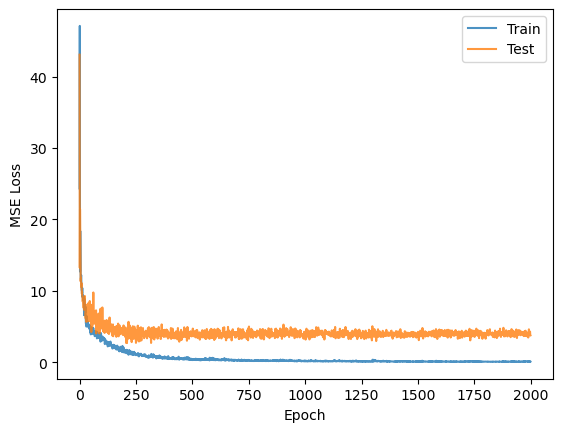

In [15]:
print('The best r2 value was:', best_R2)

fig, ax = plt.subplots()
ax.plot(train_loss_list, label='Train',alpha=0.8)
ax.plot(val_loss_list,label='Test',alpha=0.8)

#ax.set_ylim(0,2000)
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss')
ax.legend()

plt.show()

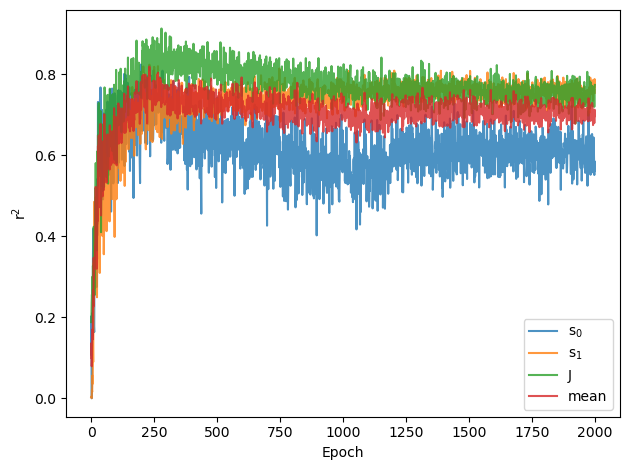

In [16]:
r2_array = np.array(r2_list)
labels = ['s$_0$', 's$_1$', 'J', 'mean']

fig, ax = plt.subplots()
for i in range(r2_array.shape[1]):
    ax.plot(r2_array[:,i],label=labels[i],alpha=0.8)

ax.set_xlabel('Epoch')
ax.set_ylabel('r$^2$')
ax.legend()
ax.tick_params(axis='both')
plt.tight_layout()
plt.show()

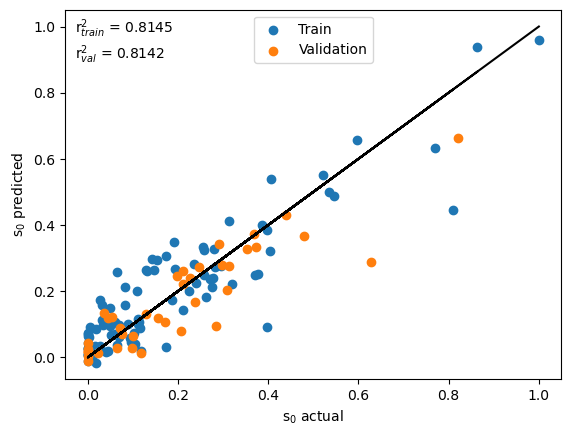

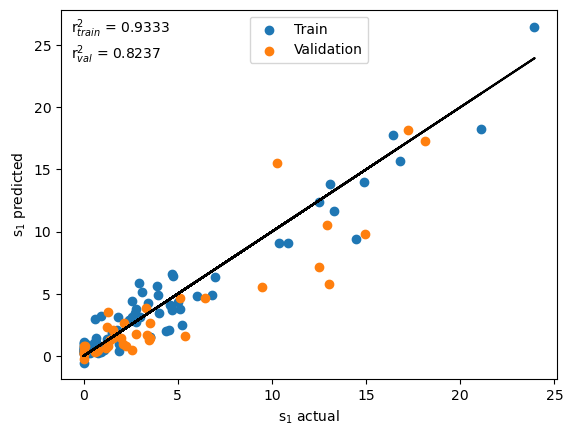

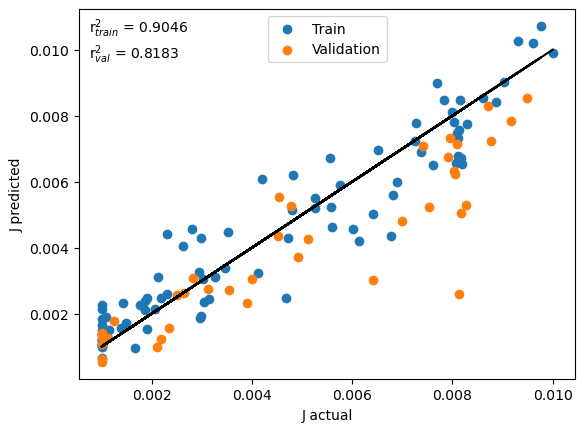

In [17]:
def plot_predictions(train_pred, train_actual, val_pred, val_actual, index, title):
    fig, ax = plt.subplots()
    
    r2_train = pearsonr(train_actual[:,index], train_pred[:,index])[0]**2
    r2_val = pearsonr(val_actual[:,index], val_pred[:,index])[0]**2
    
    ax.scatter(train_actual[:,index],train_pred[:,index],label='Train')
    ax.scatter(val_actual[:,index],val_pred[:,index],label='Validation')
    ax.plot(train_actual[:,index],train_actual[:,index],c='k')
    
    plt.text(0.02, 0.98, 'r$^2_{train}$ = %.4f\nr$^2_{val}$ = %.4f' % (r2_train,r2_val),
     horizontalalignment='left',
     verticalalignment='top',
     transform = ax.transAxes)

    ax.legend(loc='upper center')
        
    ax.set_xlabel('{} actual'.format(title))
    ax.set_ylabel('{} predicted'.format(title))
    ax.tick_params(axis='both')
    
    return ax

labels = ['s$_0$', 's$_1$', 'J']
atten = [10,1,1000]

for i,label in enumerate(labels):
    ax = plot_predictions(best_train_predictions/atten[i],best_train_actuals/atten[i],
                     best_val_predictions/atten[i], best_val_actuals/atten[i],i,label)

# Train for growth kinetics using the growth parameter features only

In [18]:
datafile = 'PLD data.json'

# set the target to anomaly to train for P, E1, and E2.
# set the target to 'growth' to train for s0, s1, and J
target_params = 'growth'

BATCH_SIZE = 88

#############################
if target_params == 'anomaly':
    normalize_PTE1E2 = False
else:
    normalize_PTE1E2 = True

train_data, val_data = load_data(datafile, target_params, normalize_PTE1E2=normalize_PTE1E2, train_percent=70)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

Total number of samples: 127
Number of training samples: 88
Number of validation samples: 39


In [19]:
# Choose between 'Mixed', 'ICCD', or 'Params'
features_to_use = 'Params' 

n_epochs=2000
learning_rate = 0.011161751166183152
L2 = 0.00027243494911370175

checkpoint_name = 'Growth Kinetics Param Input Checkpoint'

model = MixedICCDNet(features=features_to_use,
                     l1=64,        # MLP nodes layer 1 for ICCD features
                     l2=32,        # MLP nodes layer 2 for ICCD features
                     param_l1=48,  # MLP nodes layer 1 for parameter features
                     param_out=32, # MLP nodes layer 2 for parameter features
                     c1=16,        # MLP nodes layer 1 for combined features
                     c2=24,        # MLP nodes layer 1 for combined features
                     c3=32)        # MLP nodes layer 1 for combined features

# Train the model
results = train(model,train_loader,val_loader, n_epochs, learning_rate, L2)

Using GPU.
in params
2023-11-08 13:50:56.662365 Epoch 1, Training loss 24.57111930847168
in params
R2 values 0.1008, 0.0651, 0.0479; mean R2=0.0713
New best, saving checkpoint...
Validation Error: Avg loss: 26.958961 

in params
2023-11-08 13:50:56.976707 Epoch 2, Training loss 23.38414764404297
in params
R2 values 0.0774, 0.1816, 0.0593; mean R2=0.1061
New best, saving checkpoint...
Validation Error: Avg loss: 25.739393 

in params
2023-11-08 13:50:57.284095 Epoch 3, Training loss 22.430795669555664
in params
R2 values 0.0102, 0.1289, 0.0390; mean R2=0.0594
Validation Error: Avg loss: 24.507336 

in params
2023-11-08 13:50:57.573939 Epoch 4, Training loss 21.306241989135742
in params
R2 values 0.0001, 0.0434, 0.0454; mean R2=0.0296
Validation Error: Avg loss: 23.073994 

in params
2023-11-08 13:50:57.874818 Epoch 5, Training loss 20.078359603881836
in params
R2 values 0.0098, 0.0196, 0.0022; mean R2=0.0105
Validation Error: Avg loss: 21.381617 

in params
2023-11-08 13:50:58.167792 Ep

in params
2023-11-08 13:51:09.573178 Epoch 45, Training loss 5.003548622131348
in params
R2 values 0.5673, 0.5165, 0.6961; mean R2=0.5933
New best, saving checkpoint...
Validation Error: Avg loss: 5.960840 

in params
2023-11-08 13:51:09.888147 Epoch 46, Training loss 5.069001197814941
in params
R2 values 0.5762, 0.5778, 0.6521; mean R2=0.6020
New best, saving checkpoint...
Validation Error: Avg loss: 5.747877 

in params
2023-11-08 13:51:10.191058 Epoch 47, Training loss 6.185672760009766
in params
R2 values 0.5285, 0.5133, 0.5942; mean R2=0.5453
Validation Error: Avg loss: 6.294693 

in params
2023-11-08 13:51:10.475571 Epoch 48, Training loss 5.321436405181885
in params
R2 values 0.4715, 0.5741, 0.6655; mean R2=0.5704
Validation Error: Avg loss: 5.584956 

in params
2023-11-08 13:51:10.756913 Epoch 49, Training loss 5.525704383850098
in params
R2 values 0.4306, 0.5120, 0.5639; mean R2=0.5022
Validation Error: Avg loss: 6.386841 

in params
2023-11-08 13:51:11.036773 Epoch 50, Traini

in params
2023-11-08 13:51:22.804269 Epoch 91, Training loss 3.9601523876190186
in params
R2 values 0.5381, 0.6143, 0.6962; mean R2=0.6162
Validation Error: Avg loss: 4.951969 

in params
2023-11-08 13:51:23.091928 Epoch 92, Training loss 4.174336910247803
in params
R2 values 0.4762, 0.6941, 0.6070; mean R2=0.5924
Validation Error: Avg loss: 4.954591 

in params
2023-11-08 13:51:23.365156 Epoch 93, Training loss 4.7742462158203125
in params
R2 values 0.5657, 0.5939, 0.6048; mean R2=0.5881
Validation Error: Avg loss: 5.801108 

in params
2023-11-08 13:51:23.664293 Epoch 94, Training loss 4.49231481552124
in params
R2 values 0.5115, 0.4844, 0.5179; mean R2=0.5046
Validation Error: Avg loss: 7.008097 

in params
2023-11-08 13:51:23.945068 Epoch 95, Training loss 5.3067240715026855
in params
R2 values 0.5348, 0.7514, 0.6980; mean R2=0.6614
Validation Error: Avg loss: 3.999837 

in params
2023-11-08 13:51:24.226882 Epoch 96, Training loss 4.735767841339111
in params
R2 values 0.5158, 0.6897

in params
2023-11-08 13:51:36.094863 Epoch 137, Training loss 5.267448425292969
in params
R2 values 0.5659, 0.6863, 0.5938; mean R2=0.6153
Validation Error: Avg loss: 4.603072 

in params
2023-11-08 13:51:36.388674 Epoch 138, Training loss 5.043649196624756
in params
R2 values 0.6003, 0.6980, 0.7066; mean R2=0.6683
Validation Error: Avg loss: 4.163315 

in params
2023-11-08 13:51:36.690568 Epoch 139, Training loss 4.621140956878662
in params
R2 values 0.5130, 0.6358, 0.6692; mean R2=0.6060
Validation Error: Avg loss: 4.720412 

in params
2023-11-08 13:51:36.982333 Epoch 140, Training loss 4.598975658416748
in params
R2 values 0.6306, 0.7041, 0.6636; mean R2=0.6661
Validation Error: Avg loss: 3.998990 

in params
2023-11-08 13:51:37.274938 Epoch 141, Training loss 5.117395401000977
in params
R2 values 0.6249, 0.6283, 0.6574; mean R2=0.6368
Validation Error: Avg loss: 5.293780 

in params
2023-11-08 13:51:37.566477 Epoch 142, Training loss 4.053661346435547
in params
R2 values 0.6128, 0.

in params
2023-11-08 13:51:49.642789 Epoch 183, Training loss 4.113719463348389
in params
R2 values 0.5074, 0.7493, 0.7082; mean R2=0.6550
Validation Error: Avg loss: 3.788254 

in params
2023-11-08 13:51:49.935158 Epoch 184, Training loss 4.969729423522949
in params
R2 values 0.6714, 0.6857, 0.6957; mean R2=0.6843
Validation Error: Avg loss: 4.131445 

in params
2023-11-08 13:51:50.230783 Epoch 185, Training loss 4.422624111175537
in params
R2 values 0.5446, 0.5987, 0.5565; mean R2=0.5666
Validation Error: Avg loss: 6.134625 

in params
2023-11-08 13:51:50.846767 Epoch 186, Training loss 4.739096164703369
in params
R2 values 0.5075, 0.7573, 0.5862; mean R2=0.6170
Validation Error: Avg loss: 3.969165 

in params
2023-11-08 13:51:51.292401 Epoch 187, Training loss 4.866119861602783
in params
R2 values 0.4529, 0.7009, 0.6296; mean R2=0.5945
Validation Error: Avg loss: 4.462955 

in params
2023-11-08 13:51:51.591926 Epoch 188, Training loss 3.8660202026367188
in params
R2 values 0.6804, 0

in params
2023-11-08 13:52:03.936254 Epoch 229, Training loss 4.283524990081787
in params
R2 values 0.5738, 0.6112, 0.6436; mean R2=0.6095
Validation Error: Avg loss: 5.394372 

in params
2023-11-08 13:52:04.236039 Epoch 230, Training loss 3.5227572917938232
in params
R2 values 0.6278, 0.5990, 0.6428; mean R2=0.6232
Validation Error: Avg loss: 5.308608 

in params
2023-11-08 13:52:04.530858 Epoch 231, Training loss 4.255596160888672
in params
R2 values 0.5455, 0.6445, 0.5507; mean R2=0.5802
Validation Error: Avg loss: 5.253454 

in params
2023-11-08 13:52:04.834276 Epoch 232, Training loss 3.650456428527832
in params
R2 values 0.6682, 0.7734, 0.6306; mean R2=0.6907
Validation Error: Avg loss: 4.098231 

in params
2023-11-08 13:52:05.124881 Epoch 233, Training loss 4.771698951721191
in params
R2 values 0.6998, 0.7688, 0.6799; mean R2=0.7162
Validation Error: Avg loss: 3.511325 

in params
2023-11-08 13:52:05.420070 Epoch 234, Training loss 4.497910022735596
in params
R2 values 0.5976, 0

in params
2023-11-08 13:52:17.934071 Epoch 276, Training loss 4.437337875366211
in params
R2 values 0.5992, 0.7655, 0.6904; mean R2=0.6850
Validation Error: Avg loss: 4.053355 

in params
2023-11-08 13:52:18.224573 Epoch 277, Training loss 4.227051734924316
in params
R2 values 0.4343, 0.6892, 0.5631; mean R2=0.5622
Validation Error: Avg loss: 5.178154 

in params
2023-11-08 13:52:18.543225 Epoch 278, Training loss 4.844029426574707
in params
R2 values 0.4547, 0.7425, 0.5718; mean R2=0.5896
Validation Error: Avg loss: 5.098037 

in params
2023-11-08 13:52:18.835274 Epoch 279, Training loss 3.876154899597168
in params
R2 values 0.5600, 0.7010, 0.6842; mean R2=0.6484
Validation Error: Avg loss: 4.137762 

in params
2023-11-08 13:52:19.149073 Epoch 280, Training loss 4.087001800537109
in params
R2 values 0.6128, 0.8211, 0.7486; mean R2=0.7275
Validation Error: Avg loss: 2.828347 

in params
2023-11-08 13:52:19.445006 Epoch 281, Training loss 3.96374249458313
in params
R2 values 0.5748, 0.6

in params
2023-11-08 13:52:31.760570 Epoch 322, Training loss 4.41778564453125
in params
R2 values 0.5451, 0.4994, 0.6002; mean R2=0.5483
Validation Error: Avg loss: 6.613403 

in params
2023-11-08 13:52:32.085481 Epoch 323, Training loss 4.583263397216797
in params
R2 values 0.6155, 0.7604, 0.6802; mean R2=0.6853
Validation Error: Avg loss: 3.808732 

in params
2023-11-08 13:52:32.379665 Epoch 324, Training loss 6.1214704513549805
in params
R2 values 0.6065, 0.7850, 0.6495; mean R2=0.6804
Validation Error: Avg loss: 3.892762 

in params
2023-11-08 13:52:32.670744 Epoch 325, Training loss 4.8430352210998535
in params
R2 values 0.5746, 0.7472, 0.6130; mean R2=0.6449
Validation Error: Avg loss: 3.958113 

in params
2023-11-08 13:52:32.967692 Epoch 326, Training loss 3.9730844497680664
in params
R2 values 0.6089, 0.7510, 0.7077; mean R2=0.6892
Validation Error: Avg loss: 3.679580 

in params
2023-11-08 13:52:33.260336 Epoch 327, Training loss 3.3873860836029053
in params
R2 values 0.5295,

in params
2023-11-08 13:52:45.555984 Epoch 368, Training loss 3.5151307582855225
in params
R2 values 0.5394, 0.6033, 0.5983; mean R2=0.5803
Validation Error: Avg loss: 5.230744 

in params
2023-11-08 13:52:45.846596 Epoch 369, Training loss 4.215605735778809
in params
R2 values 0.6339, 0.7582, 0.6567; mean R2=0.6829
Validation Error: Avg loss: 3.626477 

in params
2023-11-08 13:52:46.139805 Epoch 370, Training loss 4.0009684562683105
in params
R2 values 0.5547, 0.7840, 0.6658; mean R2=0.6682
Validation Error: Avg loss: 3.468198 

in params
2023-11-08 13:52:46.434703 Epoch 371, Training loss 4.206570625305176
in params
R2 values 0.7232, 0.7825, 0.7943; mean R2=0.7666
New best, saving checkpoint...
Validation Error: Avg loss: 2.937788 

in params
2023-11-08 13:52:46.760533 Epoch 372, Training loss 4.783071041107178
in params
R2 values 0.5395, 0.7276, 0.4828; mean R2=0.5833
Validation Error: Avg loss: 4.650009 

in params
2023-11-08 13:52:47.047123 Epoch 373, Training loss 3.5403738021850

in params
2023-11-08 13:52:59.193744 Epoch 414, Training loss 4.654078006744385
in params
R2 values 0.6272, 0.7973, 0.5565; mean R2=0.6604
Validation Error: Avg loss: 3.694158 

in params
2023-11-08 13:52:59.509924 Epoch 415, Training loss 3.9882795810699463
in params
R2 values 0.6087, 0.6264, 0.5594; mean R2=0.5982
Validation Error: Avg loss: 6.110704 

in params
2023-11-08 13:52:59.811384 Epoch 416, Training loss 3.916485548019409
in params
R2 values 0.6618, 0.7837, 0.7441; mean R2=0.7299
Validation Error: Avg loss: 3.685162 

in params
2023-11-08 13:53:00.117053 Epoch 417, Training loss 3.9284908771514893
in params
R2 values 0.6629, 0.6826, 0.6742; mean R2=0.6732
Validation Error: Avg loss: 4.479320 

in params
2023-11-08 13:53:00.502925 Epoch 418, Training loss 4.457095146179199
in params
R2 values 0.5344, 0.6651, 0.6199; mean R2=0.6064
Validation Error: Avg loss: 5.243438 

in params
2023-11-08 13:53:00.804062 Epoch 419, Training loss 4.198025226593018
in params
R2 values 0.5597, 

in params
2023-11-08 13:53:13.352016 Epoch 461, Training loss 3.8894293308258057
in params
R2 values 0.6674, 0.5438, 0.5849; mean R2=0.5987
Validation Error: Avg loss: 6.658955 

in params
2023-11-08 13:53:13.646948 Epoch 462, Training loss 3.623384475708008
in params
R2 values 0.5873, 0.6145, 0.5845; mean R2=0.5954
Validation Error: Avg loss: 6.057417 

in params
2023-11-08 13:53:13.944903 Epoch 463, Training loss 4.205002307891846
in params
R2 values 0.6553, 0.7399, 0.6494; mean R2=0.6815
Validation Error: Avg loss: 4.862057 

in params
2023-11-08 13:53:14.235421 Epoch 464, Training loss 3.6882758140563965
in params
R2 values 0.7161, 0.6714, 0.6371; mean R2=0.6749
Validation Error: Avg loss: 4.720768 

in params
2023-11-08 13:53:14.539202 Epoch 465, Training loss 4.0733208656311035
in params
R2 values 0.6402, 0.7445, 0.5949; mean R2=0.6599
Validation Error: Avg loss: 3.996416 

in params
2023-11-08 13:53:14.840033 Epoch 466, Training loss 3.6980063915252686
in params
R2 values 0.6734

in params
2023-11-08 13:53:26.623413 Epoch 507, Training loss 4.110229969024658
in params
R2 values 0.6181, 0.8117, 0.7026; mean R2=0.7108
Validation Error: Avg loss: 3.042340 

in params
2023-11-08 13:53:26.915860 Epoch 508, Training loss 2.759922981262207
in params
R2 values 0.7270, 0.6954, 0.6359; mean R2=0.6861
Validation Error: Avg loss: 4.141195 

in params
2023-11-08 13:53:27.191280 Epoch 509, Training loss 4.451972961425781
in params
R2 values 0.7530, 0.6340, 0.6161; mean R2=0.6677
Validation Error: Avg loss: 4.931024 

in params
2023-11-08 13:53:27.479840 Epoch 510, Training loss 3.9274837970733643
in params
R2 values 0.7000, 0.7314, 0.6447; mean R2=0.6921
Validation Error: Avg loss: 4.412300 

in params
2023-11-08 13:53:27.762428 Epoch 511, Training loss 4.76828670501709
in params
R2 values 0.6754, 0.7149, 0.6016; mean R2=0.6639
Validation Error: Avg loss: 4.258561 

in params
2023-11-08 13:53:28.041026 Epoch 512, Training loss 3.4389102458953857
in params
R2 values 0.7780, 0

in params
2023-11-08 13:53:39.818446 Epoch 553, Training loss 3.8698813915252686
in params
R2 values 0.7420, 0.7692, 0.5826; mean R2=0.6980
Validation Error: Avg loss: 3.960663 

in params
2023-11-08 13:53:40.117255 Epoch 554, Training loss 3.995671272277832
in params
R2 values 0.5057, 0.3612, 0.5574; mean R2=0.4748
Validation Error: Avg loss: 7.632812 

in params
2023-11-08 13:53:40.397533 Epoch 555, Training loss 4.527331352233887
in params
R2 values 0.6865, 0.6276, 0.6569; mean R2=0.6570
Validation Error: Avg loss: 4.701545 

in params
2023-11-08 13:53:40.690045 Epoch 556, Training loss 4.310677528381348
in params
R2 values 0.7394, 0.7726, 0.7966; mean R2=0.7695
Validation Error: Avg loss: 2.952719 

in params
2023-11-08 13:53:40.987300 Epoch 557, Training loss 3.172956943511963
in params
R2 values 0.6508, 0.5978, 0.6452; mean R2=0.6313
Validation Error: Avg loss: 5.484894 

in params
2023-11-08 13:53:41.278534 Epoch 558, Training loss 4.505745887756348
in params
R2 values 0.6947, 0

in params
2023-11-08 13:53:53.026388 Epoch 599, Training loss 2.986375093460083
in params
R2 values 0.6939, 0.5275, 0.6191; mean R2=0.6135
Validation Error: Avg loss: 6.019260 

in params
2023-11-08 13:53:53.314064 Epoch 600, Training loss 3.918606996536255
in params
R2 values 0.6009, 0.7570, 0.6178; mean R2=0.6586
Validation Error: Avg loss: 3.976896 

in params
2023-11-08 13:53:53.612917 Epoch 601, Training loss 4.160543918609619
in params
R2 values 0.5967, 0.6548, 0.5848; mean R2=0.6121
Validation Error: Avg loss: 5.336389 

in params
2023-11-08 13:53:53.904306 Epoch 602, Training loss 3.329343318939209
in params
R2 values 0.6706, 0.7434, 0.6740; mean R2=0.6960
Validation Error: Avg loss: 4.781687 

in params
2023-11-08 13:53:54.180526 Epoch 603, Training loss 4.4473958015441895
in params
R2 values 0.6256, 0.5906, 0.7260; mean R2=0.6474
Validation Error: Avg loss: 5.926709 

in params
2023-11-08 13:53:54.460472 Epoch 604, Training loss 4.406949043273926
in params
R2 values 0.5133, 0

in params
2023-11-08 13:54:06.261452 Epoch 645, Training loss 3.8346962928771973
in params
R2 values 0.6913, 0.5274, 0.6329; mean R2=0.6172
Validation Error: Avg loss: 5.798954 

in params
2023-11-08 13:54:06.544843 Epoch 646, Training loss 4.6506829261779785
in params
R2 values 0.7442, 0.7983, 0.5775; mean R2=0.7067
Validation Error: Avg loss: 3.433039 

in params
2023-11-08 13:54:06.827326 Epoch 647, Training loss 4.136443138122559
in params
R2 values 0.6684, 0.6449, 0.6334; mean R2=0.6489
Validation Error: Avg loss: 4.666032 

in params
2023-11-08 13:54:07.108862 Epoch 648, Training loss 3.4982781410217285
in params
R2 values 0.7470, 0.8192, 0.7581; mean R2=0.7748
Validation Error: Avg loss: 2.748953 

in params
2023-11-08 13:54:07.403434 Epoch 649, Training loss 3.2886483669281006
in params
R2 values 0.6948, 0.6487, 0.6804; mean R2=0.6746
Validation Error: Avg loss: 4.483202 

in params
2023-11-08 13:54:07.692326 Epoch 650, Training loss 3.8692197799682617
in params
R2 values 0.743

in params
2023-11-08 13:54:19.516951 Epoch 691, Training loss 2.699866533279419
in params
R2 values 0.6612, 0.7245, 0.6241; mean R2=0.6699
Validation Error: Avg loss: 4.373191 

in params
2023-11-08 13:54:19.809737 Epoch 692, Training loss 3.657503128051758
in params
R2 values 0.7363, 0.7692, 0.7502; mean R2=0.7519
Validation Error: Avg loss: 3.143389 

in params
2023-11-08 13:54:20.110736 Epoch 693, Training loss 3.552706003189087
in params
R2 values 0.6980, 0.6632, 0.5536; mean R2=0.6383
Validation Error: Avg loss: 4.675603 

in params
2023-11-08 13:54:20.408157 Epoch 694, Training loss 4.43858528137207
in params
R2 values 0.6935, 0.7901, 0.6103; mean R2=0.6980
Validation Error: Avg loss: 3.951155 

in params
2023-11-08 13:54:20.697462 Epoch 695, Training loss 3.4337759017944336
in params
R2 values 0.6413, 0.6294, 0.6686; mean R2=0.6464
Validation Error: Avg loss: 5.247174 

in params
2023-11-08 13:54:20.989185 Epoch 696, Training loss 3.339982748031616
in params
R2 values 0.6664, 0.

in params
2023-11-08 13:54:32.754757 Epoch 737, Training loss 4.250619888305664
in params
R2 values 0.6644, 0.7176, 0.7177; mean R2=0.6999
Validation Error: Avg loss: 4.643794 

in params
2023-11-08 13:54:33.031115 Epoch 738, Training loss 3.7368597984313965
in params
R2 values 0.7022, 0.6458, 0.6069; mean R2=0.6516
Validation Error: Avg loss: 5.515112 

in params
2023-11-08 13:54:33.302441 Epoch 739, Training loss 4.068910598754883
in params
R2 values 0.6282, 0.7230, 0.6558; mean R2=0.6690
Validation Error: Avg loss: 3.886855 

in params
2023-11-08 13:54:33.573865 Epoch 740, Training loss 4.35835599899292
in params
R2 values 0.6347, 0.7764, 0.6389; mean R2=0.6834
Validation Error: Avg loss: 3.511989 

in params
2023-11-08 13:54:33.847946 Epoch 741, Training loss 4.5378007888793945
in params
R2 values 0.7573, 0.7642, 0.5696; mean R2=0.6970
Validation Error: Avg loss: 3.611852 

in params
2023-11-08 13:54:34.120609 Epoch 742, Training loss 4.035199165344238
in params
R2 values 0.6204, 0

in params
2023-11-08 13:54:45.516055 Epoch 783, Training loss 3.695246458053589
in params
R2 values 0.7516, 0.6491, 0.6091; mean R2=0.6700
Validation Error: Avg loss: 5.198696 

in params
2023-11-08 13:54:45.794714 Epoch 784, Training loss 3.6054720878601074
in params
R2 values 0.6314, 0.7394, 0.5901; mean R2=0.6536
Validation Error: Avg loss: 4.115805 

in params
2023-11-08 13:54:46.084942 Epoch 785, Training loss 3.4053921699523926
in params
R2 values 0.6381, 0.7022, 0.6288; mean R2=0.6564
Validation Error: Avg loss: 4.202679 

in params
2023-11-08 13:54:46.355986 Epoch 786, Training loss 5.1181159019470215
in params
R2 values 0.8053, 0.7749, 0.7149; mean R2=0.7650
Validation Error: Avg loss: 3.042854 

in params
2023-11-08 13:54:46.629227 Epoch 787, Training loss 3.959052085876465
in params
R2 values 0.7915, 0.7754, 0.8307; mean R2=0.7992
Validation Error: Avg loss: 2.692865 

in params
2023-11-08 13:54:46.896194 Epoch 788, Training loss 3.9468841552734375
in params
R2 values 0.7342

in params
2023-11-08 13:54:58.230216 Epoch 829, Training loss 3.9487528800964355
in params
R2 values 0.6076, 0.6863, 0.6790; mean R2=0.6576
Validation Error: Avg loss: 4.241536 

in params
2023-11-08 13:54:58.505149 Epoch 830, Training loss 3.1871702671051025
in params
R2 values 0.6632, 0.8430, 0.7070; mean R2=0.7377
Validation Error: Avg loss: 2.749787 

in params
2023-11-08 13:54:58.779847 Epoch 831, Training loss 3.0639426708221436
in params
R2 values 0.6813, 0.8828, 0.7304; mean R2=0.7649
Validation Error: Avg loss: 2.236959 

in params
2023-11-08 13:54:59.045356 Epoch 832, Training loss 4.001478672027588
in params
R2 values 0.6639, 0.6706, 0.6685; mean R2=0.6677
Validation Error: Avg loss: 4.387276 

in params
2023-11-08 13:54:59.322282 Epoch 833, Training loss 3.155491590499878
in params
R2 values 0.6825, 0.6902, 0.7477; mean R2=0.7068
Validation Error: Avg loss: 4.141680 

in params
2023-11-08 13:54:59.614001 Epoch 834, Training loss 4.273965358734131
in params
R2 values 0.6877,

in params
2023-11-08 13:55:11.173331 Epoch 875, Training loss 3.5473074913024902
in params
R2 values 0.7323, 0.7181, 0.7259; mean R2=0.7254
Validation Error: Avg loss: 3.634055 

in params
2023-11-08 13:55:11.448894 Epoch 876, Training loss 3.6400678157806396
in params
R2 values 0.5963, 0.5732, 0.6593; mean R2=0.6096
Validation Error: Avg loss: 5.313852 

in params
2023-11-08 13:55:11.723124 Epoch 877, Training loss 4.053858757019043
in params
R2 values 0.6399, 0.6960, 0.6667; mean R2=0.6675
Validation Error: Avg loss: 4.154262 

in params
2023-11-08 13:55:12.013759 Epoch 878, Training loss 3.009697437286377
in params
R2 values 0.6795, 0.6456, 0.6467; mean R2=0.6573
Validation Error: Avg loss: 4.620610 

in params
2023-11-08 13:55:12.281687 Epoch 879, Training loss 3.1027159690856934
in params
R2 values 0.5823, 0.7694, 0.6378; mean R2=0.6632
Validation Error: Avg loss: 3.877248 

in params
2023-11-08 13:55:12.558856 Epoch 880, Training loss 3.3473918437957764
in params
R2 values 0.6385

in params
2023-11-08 13:55:24.003461 Epoch 921, Training loss 2.907926559448242
in params
R2 values 0.6339, 0.6597, 0.7170; mean R2=0.6702
Validation Error: Avg loss: 4.540915 

in params
2023-11-08 13:55:24.277937 Epoch 922, Training loss 4.420529365539551
in params
R2 values 0.7368, 0.7821, 0.7223; mean R2=0.7471
Validation Error: Avg loss: 3.517333 

in params
2023-11-08 13:55:24.551519 Epoch 923, Training loss 3.871570587158203
in params
R2 values 0.7077, 0.6243, 0.6059; mean R2=0.6459
Validation Error: Avg loss: 5.163218 

in params
2023-11-08 13:55:24.857381 Epoch 924, Training loss 3.6765785217285156
in params
R2 values 0.6224, 0.6163, 0.6011; mean R2=0.6133
Validation Error: Avg loss: 5.088907 

in params
2023-11-08 13:55:25.141377 Epoch 925, Training loss 3.555889844894409
in params
R2 values 0.6339, 0.5973, 0.6397; mean R2=0.6236
Validation Error: Avg loss: 5.364788 

in params
2023-11-08 13:55:25.415665 Epoch 926, Training loss 3.307062864303589
in params
R2 values 0.7022, 0

in params
2023-11-08 13:55:36.901516 Epoch 967, Training loss 3.0281646251678467
in params
R2 values 0.6064, 0.7102, 0.6049; mean R2=0.6405
Validation Error: Avg loss: 4.497343 

in params
2023-11-08 13:55:37.173470 Epoch 968, Training loss 4.221456050872803
in params
R2 values 0.6580, 0.6743, 0.6279; mean R2=0.6534
Validation Error: Avg loss: 4.428463 

in params
2023-11-08 13:55:37.443653 Epoch 969, Training loss 4.273964881896973
in params
R2 values 0.6498, 0.6900, 0.6785; mean R2=0.6728
Validation Error: Avg loss: 4.230469 

in params
2023-11-08 13:55:37.718910 Epoch 970, Training loss 4.254879474639893
in params
R2 values 0.7029, 0.7547, 0.6599; mean R2=0.7058
Validation Error: Avg loss: 3.759081 

in params
2023-11-08 13:55:37.996052 Epoch 971, Training loss 2.792167901992798
in params
R2 values 0.6256, 0.7872, 0.6171; mean R2=0.6766
Validation Error: Avg loss: 3.637178 

in params
2023-11-08 13:55:38.274227 Epoch 972, Training loss 2.6579811573028564
in params
R2 values 0.7274, 

in params
2023-11-08 13:55:49.689389 Epoch 1013, Training loss 3.6945888996124268
in params
R2 values 0.7344, 0.6938, 0.7320; mean R2=0.7201
Validation Error: Avg loss: 3.983126 

in params
2023-11-08 13:55:49.997667 Epoch 1014, Training loss 3.0612738132476807
in params
R2 values 0.6429, 0.7222, 0.5824; mean R2=0.6491
Validation Error: Avg loss: 4.556283 

in params
2023-11-08 13:55:50.325657 Epoch 1015, Training loss 3.069959878921509
in params
R2 values 0.6372, 0.6323, 0.5281; mean R2=0.5992
Validation Error: Avg loss: 5.430731 

in params
2023-11-08 13:55:50.606121 Epoch 1016, Training loss 3.8678572177886963
in params
R2 values 0.6782, 0.6719, 0.6094; mean R2=0.6531
Validation Error: Avg loss: 4.549334 

in params
2023-11-08 13:55:50.881006 Epoch 1017, Training loss 3.398606061935425
in params
R2 values 0.5768, 0.5711, 0.5121; mean R2=0.5533
Validation Error: Avg loss: 6.046294 

in params
2023-11-08 13:55:51.166582 Epoch 1018, Training loss 3.966078519821167
in params
R2 values 0

in params
2023-11-08 13:56:02.565314 Epoch 1059, Training loss 3.5733020305633545
in params
R2 values 0.5373, 0.6985, 0.6156; mean R2=0.6171
Validation Error: Avg loss: 4.685228 

in params
2023-11-08 13:56:02.838915 Epoch 1060, Training loss 3.1311192512512207
in params
R2 values 0.6081, 0.6468, 0.6266; mean R2=0.6272
Validation Error: Avg loss: 4.946675 

in params
2023-11-08 13:56:03.107130 Epoch 1061, Training loss 3.7201011180877686
in params
R2 values 0.6387, 0.7211, 0.6802; mean R2=0.6800
Validation Error: Avg loss: 3.949757 

in params
2023-11-08 13:56:03.383265 Epoch 1062, Training loss 2.8129498958587646
in params
R2 values 0.6958, 0.7332, 0.7368; mean R2=0.7219
Validation Error: Avg loss: 3.665478 

in params
2023-11-08 13:56:03.662269 Epoch 1063, Training loss 3.3702852725982666
in params
R2 values 0.6541, 0.6941, 0.6797; mean R2=0.6760
Validation Error: Avg loss: 4.131394 

in params
2023-11-08 13:56:03.939692 Epoch 1064, Training loss 2.597750186920166
in params
R2 values

in params
2023-11-08 13:56:15.371795 Epoch 1105, Training loss 3.0554184913635254
in params
R2 values 0.7360, 0.8026, 0.7355; mean R2=0.7580
Validation Error: Avg loss: 2.884780 

in params
2023-11-08 13:56:15.647003 Epoch 1106, Training loss 2.883162021636963
in params
R2 values 0.6719, 0.6522, 0.6310; mean R2=0.6517
Validation Error: Avg loss: 4.948191 

in params
2023-11-08 13:56:15.924430 Epoch 1107, Training loss 2.6987318992614746
in params
R2 values 0.6439, 0.7347, 0.6060; mean R2=0.6615
Validation Error: Avg loss: 4.158712 

in params
2023-11-08 13:56:16.189522 Epoch 1108, Training loss 3.0155582427978516
in params
R2 values 0.6831, 0.6841, 0.7010; mean R2=0.6894
Validation Error: Avg loss: 4.255717 

in params
2023-11-08 13:56:16.475589 Epoch 1109, Training loss 3.661869525909424
in params
R2 values 0.6268, 0.6732, 0.6385; mean R2=0.6462
Validation Error: Avg loss: 5.285937 

in params
2023-11-08 13:56:16.745114 Epoch 1110, Training loss 2.747004508972168
in params
R2 values 0

in params
2023-11-08 13:56:28.185240 Epoch 1151, Training loss 3.257988214492798
in params
R2 values 0.6564, 0.8001, 0.6667; mean R2=0.7077
Validation Error: Avg loss: 3.275547 

in params
2023-11-08 13:56:28.454879 Epoch 1152, Training loss 2.4863500595092773
in params
R2 values 0.6102, 0.5898, 0.6453; mean R2=0.6151
Validation Error: Avg loss: 5.344010 

in params
2023-11-08 13:56:28.728876 Epoch 1153, Training loss 4.4988932609558105
in params
R2 values 0.6418, 0.7206, 0.7190; mean R2=0.6938
Validation Error: Avg loss: 3.791420 

in params
2023-11-08 13:56:29.008446 Epoch 1154, Training loss 2.995610475540161
in params
R2 values 0.7107, 0.7111, 0.6675; mean R2=0.6965
Validation Error: Avg loss: 4.003468 

in params
2023-11-08 13:56:29.288118 Epoch 1155, Training loss 3.537116765975952
in params
R2 values 0.7172, 0.6762, 0.7408; mean R2=0.7114
Validation Error: Avg loss: 4.242902 

in params
2023-11-08 13:56:29.571703 Epoch 1156, Training loss 3.1161046028137207
in params
R2 values 0

in params
2023-11-08 13:56:40.952406 Epoch 1197, Training loss 2.5616164207458496
in params
R2 values 0.6830, 0.6994, 0.6618; mean R2=0.6814
Validation Error: Avg loss: 4.083325 

in params
2023-11-08 13:56:41.218453 Epoch 1198, Training loss 3.967905282974243
in params
R2 values 0.6674, 0.7442, 0.7209; mean R2=0.7108
Validation Error: Avg loss: 3.848722 

in params
2023-11-08 13:56:41.498621 Epoch 1199, Training loss 3.2257461547851562
in params
R2 values 0.6784, 0.6404, 0.6875; mean R2=0.6688
Validation Error: Avg loss: 4.620265 

in params
2023-11-08 13:56:41.769773 Epoch 1200, Training loss 3.9696943759918213
in params
R2 values 0.6621, 0.6564, 0.6583; mean R2=0.6589
Validation Error: Avg loss: 5.109021 

in params
2023-11-08 13:56:42.049552 Epoch 1201, Training loss 3.3909876346588135
in params
R2 values 0.7405, 0.7574, 0.6468; mean R2=0.7149
Validation Error: Avg loss: 3.829227 

in params
2023-11-08 13:56:42.321215 Epoch 1202, Training loss 3.3225550651550293
in params
R2 values

in params
2023-11-08 13:56:53.848733 Epoch 1243, Training loss 4.235268592834473
in params
R2 values 0.5357, 0.4591, 0.5655; mean R2=0.5201
Validation Error: Avg loss: 6.732795 

in params
2023-11-08 13:56:54.121617 Epoch 1244, Training loss 3.9976322650909424
in params
R2 values 0.6265, 0.4666, 0.7207; mean R2=0.6046
Validation Error: Avg loss: 6.089086 

in params
2023-11-08 13:56:54.398470 Epoch 1245, Training loss 2.289686441421509
in params
R2 values 0.6361, 0.7069, 0.6947; mean R2=0.6792
Validation Error: Avg loss: 4.012285 

in params
2023-11-08 13:56:54.676032 Epoch 1246, Training loss 3.4474997520446777
in params
R2 values 0.6493, 0.6337, 0.5661; mean R2=0.6163
Validation Error: Avg loss: 5.815604 

in params
2023-11-08 13:56:54.949779 Epoch 1247, Training loss 3.340198040008545
in params
R2 values 0.7081, 0.6390, 0.6432; mean R2=0.6634
Validation Error: Avg loss: 4.759048 

in params
2023-11-08 13:56:55.228130 Epoch 1248, Training loss 3.1318321228027344
in params
R2 values 0

in params
2023-11-08 13:57:06.733559 Epoch 1289, Training loss 3.4251761436462402
in params
R2 values 0.6774, 0.6081, 0.6636; mean R2=0.6497
Validation Error: Avg loss: 5.194387 

in params
2023-11-08 13:57:07.025114 Epoch 1290, Training loss 2.9438772201538086
in params
R2 values 0.7066, 0.5511, 0.6876; mean R2=0.6484
Validation Error: Avg loss: 5.297139 

in params
2023-11-08 13:57:07.299334 Epoch 1291, Training loss 3.8702049255371094
in params
R2 values 0.6690, 0.7622, 0.6813; mean R2=0.7042
Validation Error: Avg loss: 3.874635 

in params
2023-11-08 13:57:07.571769 Epoch 1292, Training loss 3.250739336013794
in params
R2 values 0.5971, 0.6444, 0.6877; mean R2=0.6431
Validation Error: Avg loss: 4.630211 

in params
2023-11-08 13:57:07.847668 Epoch 1293, Training loss 3.6294243335723877
in params
R2 values 0.6004, 0.6116, 0.5894; mean R2=0.6005
Validation Error: Avg loss: 5.460009 

in params
2023-11-08 13:57:08.123602 Epoch 1294, Training loss 3.1455636024475098
in params
R2 values

in params
2023-11-08 13:57:19.574897 Epoch 1335, Training loss 4.161208629608154
in params
R2 values 0.5977, 0.6612, 0.6751; mean R2=0.6447
Validation Error: Avg loss: 5.099457 

in params
2023-11-08 13:57:19.855044 Epoch 1336, Training loss 3.983532190322876
in params
R2 values 0.7974, 0.6467, 0.7665; mean R2=0.7368
Validation Error: Avg loss: 4.044265 

in params
2023-11-08 13:57:20.129874 Epoch 1337, Training loss 4.536453723907471
in params
R2 values 0.6867, 0.7866, 0.6286; mean R2=0.7006
Validation Error: Avg loss: 3.463635 

in params
2023-11-08 13:57:20.425513 Epoch 1338, Training loss 3.819201707839966
in params
R2 values 0.7282, 0.6779, 0.6587; mean R2=0.6883
Validation Error: Avg loss: 4.273250 

in params
2023-11-08 13:57:20.718683 Epoch 1339, Training loss 2.760505437850952
in params
R2 values 0.6586, 0.7461, 0.6096; mean R2=0.6715
Validation Error: Avg loss: 4.006347 

in params
2023-11-08 13:57:20.990688 Epoch 1340, Training loss 2.3972578048706055
in params
R2 values 0.6

in params
2023-11-08 13:57:32.464729 Epoch 1381, Training loss 3.689521551132202
in params
R2 values 0.7199, 0.6911, 0.6791; mean R2=0.6967
Validation Error: Avg loss: 4.822151 

in params
2023-11-08 13:57:32.737943 Epoch 1382, Training loss 2.8411781787872314
in params
R2 values 0.7021, 0.6276, 0.6750; mean R2=0.6682
Validation Error: Avg loss: 4.723680 

in params
2023-11-08 13:57:33.008826 Epoch 1383, Training loss 3.566410541534424
in params
R2 values 0.7457, 0.6509, 0.6517; mean R2=0.6828
Validation Error: Avg loss: 4.627903 

in params
2023-11-08 13:57:33.278526 Epoch 1384, Training loss 3.084996223449707
in params
R2 values 0.6598, 0.7389, 0.7098; mean R2=0.7028
Validation Error: Avg loss: 3.805255 

in params
2023-11-08 13:57:33.557689 Epoch 1385, Training loss 3.5203912258148193
in params
R2 values 0.5463, 0.5204, 0.6232; mean R2=0.5633
Validation Error: Avg loss: 5.998180 

in params
2023-11-08 13:57:33.834754 Epoch 1386, Training loss 3.2116925716400146
in params
R2 values 0

in params
2023-11-08 13:57:45.228514 Epoch 1427, Training loss 3.3131725788116455
in params
R2 values 0.6673, 0.6705, 0.6573; mean R2=0.6650
Validation Error: Avg loss: 4.366236 

in params
2023-11-08 13:57:45.497651 Epoch 1428, Training loss 4.642695426940918
in params
R2 values 0.6280, 0.6445, 0.6391; mean R2=0.6372
Validation Error: Avg loss: 4.716657 

in params
2023-11-08 13:57:45.786787 Epoch 1429, Training loss 3.572618246078491
in params
R2 values 0.7579, 0.7921, 0.7080; mean R2=0.7526
Validation Error: Avg loss: 3.056590 

in params
2023-11-08 13:57:46.061108 Epoch 1430, Training loss 3.1242241859436035
in params
R2 values 0.7090, 0.7194, 0.7018; mean R2=0.7101
Validation Error: Avg loss: 4.592071 

in params
2023-11-08 13:57:46.332255 Epoch 1431, Training loss 2.989654302597046
in params
R2 values 0.6270, 0.6201, 0.6528; mean R2=0.6333
Validation Error: Avg loss: 5.439277 

in params
2023-11-08 13:57:46.599055 Epoch 1432, Training loss 3.507368326187134
in params
R2 values 0.

in params
2023-11-08 13:57:58.049607 Epoch 1473, Training loss 2.7812297344207764
in params
R2 values 0.5583, 0.7769, 0.6411; mean R2=0.6588
Validation Error: Avg loss: 3.682499 

in params
2023-11-08 13:57:58.325408 Epoch 1474, Training loss 2.8869402408599854
in params
R2 values 0.6618, 0.6780, 0.5958; mean R2=0.6452
Validation Error: Avg loss: 4.409580 

in params
2023-11-08 13:57:58.602377 Epoch 1475, Training loss 3.0132124423980713
in params
R2 values 0.6464, 0.6922, 0.6807; mean R2=0.6731
Validation Error: Avg loss: 4.106483 

in params
2023-11-08 13:57:58.892748 Epoch 1476, Training loss 3.3118605613708496
in params
R2 values 0.6184, 0.8317, 0.6986; mean R2=0.7162
Validation Error: Avg loss: 3.033881 

in params
2023-11-08 13:57:59.168511 Epoch 1477, Training loss 3.9533379077911377
in params
R2 values 0.6515, 0.8638, 0.5783; mean R2=0.6979
Validation Error: Avg loss: 3.209782 

in params
2023-11-08 13:57:59.443525 Epoch 1478, Training loss 3.574368476867676
in params
R2 values

in params
2023-11-08 13:58:11.043568 Epoch 1519, Training loss 3.232147455215454
in params
R2 values 0.6840, 0.7874, 0.7351; mean R2=0.7355
Validation Error: Avg loss: 3.132899 

in params
2023-11-08 13:58:11.318720 Epoch 1520, Training loss 3.1183888912200928
in params
R2 values 0.7666, 0.8436, 0.7431; mean R2=0.7845
Validation Error: Avg loss: 2.808269 

in params
2023-11-08 13:58:11.596092 Epoch 1521, Training loss 3.4856693744659424
in params
R2 values 0.6728, 0.5417, 0.5331; mean R2=0.5826
Validation Error: Avg loss: 5.904597 

in params
2023-11-08 13:58:11.868610 Epoch 1522, Training loss 2.5381832122802734
in params
R2 values 0.6736, 0.6847, 0.6103; mean R2=0.6562
Validation Error: Avg loss: 4.435741 

in params
2023-11-08 13:58:12.146742 Epoch 1523, Training loss 3.86667537689209
in params
R2 values 0.5326, 0.7410, 0.6071; mean R2=0.6269
Validation Error: Avg loss: 4.173017 

in params
2023-11-08 13:58:12.431259 Epoch 1524, Training loss 3.5502445697784424
in params
R2 values 0

in params
2023-11-08 13:58:23.899066 Epoch 1565, Training loss 3.5308570861816406
in params
R2 values 0.6184, 0.7149, 0.5589; mean R2=0.6307
Validation Error: Avg loss: 4.576034 

in params
2023-11-08 13:58:24.175298 Epoch 1566, Training loss 2.5906622409820557
in params
R2 values 0.7989, 0.7511, 0.8009; mean R2=0.7836
Validation Error: Avg loss: 3.696198 

in params
2023-11-08 13:58:24.452476 Epoch 1567, Training loss 2.8779566287994385
in params
R2 values 0.7956, 0.7150, 0.6657; mean R2=0.7254
Validation Error: Avg loss: 4.024377 

in params
2023-11-08 13:58:24.733742 Epoch 1568, Training loss 3.9591500759124756
in params
R2 values 0.5074, 0.6414, 0.5536; mean R2=0.5675
Validation Error: Avg loss: 5.242136 

in params
2023-11-08 13:58:25.008855 Epoch 1569, Training loss 2.947845935821533
in params
R2 values 0.6893, 0.6444, 0.5222; mean R2=0.6186
Validation Error: Avg loss: 5.038206 

in params
2023-11-08 13:58:25.286884 Epoch 1570, Training loss 3.314465284347534
in params
R2 values 

in params
2023-11-08 13:58:36.816993 Epoch 1611, Training loss 3.3501598834991455
in params
R2 values 0.7565, 0.8105, 0.6941; mean R2=0.7537
Validation Error: Avg loss: 3.412464 

in params
2023-11-08 13:58:37.095899 Epoch 1612, Training loss 4.328023910522461
in params
R2 values 0.7838, 0.6476, 0.6755; mean R2=0.7023
Validation Error: Avg loss: 4.529233 

in params
2023-11-08 13:58:37.371952 Epoch 1613, Training loss 3.1684439182281494
in params
R2 values 0.6556, 0.6928, 0.7229; mean R2=0.6904
Validation Error: Avg loss: 4.261622 

in params
2023-11-08 13:58:37.653050 Epoch 1614, Training loss 2.620473861694336
in params
R2 values 0.6238, 0.6281, 0.6212; mean R2=0.6244
Validation Error: Avg loss: 4.996944 

in params
2023-11-08 13:58:37.932652 Epoch 1615, Training loss 2.7401294708251953
in params
R2 values 0.6962, 0.8022, 0.7229; mean R2=0.7405
Validation Error: Avg loss: 3.005035 

in params
2023-11-08 13:58:38.210891 Epoch 1616, Training loss 3.34415864944458
in params
R2 values 0.

in params
2023-11-08 13:58:49.731203 Epoch 1657, Training loss 3.6941373348236084
in params
R2 values 0.8009, 0.6096, 0.7445; mean R2=0.7183
Validation Error: Avg loss: 6.020648 

in params
2023-11-08 13:58:50.005474 Epoch 1658, Training loss 3.3878135681152344
in params
R2 values 0.6650, 0.7544, 0.6751; mean R2=0.6982
Validation Error: Avg loss: 3.704473 

in params
2023-11-08 13:58:50.289983 Epoch 1659, Training loss 2.8479583263397217
in params
R2 values 0.6702, 0.4709, 0.6960; mean R2=0.6124
Validation Error: Avg loss: 5.971953 

in params
2023-11-08 13:58:50.577347 Epoch 1660, Training loss 2.681931257247925
in params
R2 values 0.5651, 0.4754, 0.5819; mean R2=0.5408
Validation Error: Avg loss: 6.500525 

in params
2023-11-08 13:58:50.858072 Epoch 1661, Training loss 3.083103895187378
in params
R2 values 0.6549, 0.7933, 0.7451; mean R2=0.7311
Validation Error: Avg loss: 3.742751 

in params
2023-11-08 13:58:51.150405 Epoch 1662, Training loss 3.678588628768921
in params
R2 values 0

in params
2023-11-08 13:59:02.716725 Epoch 1703, Training loss 3.3628334999084473
in params
R2 values 0.6811, 0.7198, 0.7334; mean R2=0.7114
Validation Error: Avg loss: 4.252571 

in params
2023-11-08 13:59:02.990985 Epoch 1704, Training loss 3.1875298023223877
in params
R2 values 0.6093, 0.8215, 0.6138; mean R2=0.6815
Validation Error: Avg loss: 3.159710 

in params
2023-11-08 13:59:03.277485 Epoch 1705, Training loss 4.065834999084473
in params
R2 values 0.6739, 0.5611, 0.7276; mean R2=0.6542
Validation Error: Avg loss: 5.071702 

in params
2023-11-08 13:59:03.549249 Epoch 1706, Training loss 3.218712568283081
in params
R2 values 0.7419, 0.8090, 0.6293; mean R2=0.7267
Validation Error: Avg loss: 3.116253 

in params
2023-11-08 13:59:03.830335 Epoch 1707, Training loss 3.791510581970215
in params
R2 values 0.7031, 0.6147, 0.7531; mean R2=0.6903
Validation Error: Avg loss: 4.448030 

in params
2023-11-08 13:59:04.117226 Epoch 1708, Training loss 4.139383792877197
in params
R2 values 0.

in params
2023-11-08 13:59:15.581826 Epoch 1749, Training loss 3.145725965499878
in params
R2 values 0.6655, 0.5780, 0.6375; mean R2=0.6270
Validation Error: Avg loss: 5.627365 

in params
2023-11-08 13:59:15.856364 Epoch 1750, Training loss 3.852534055709839
in params
R2 values 0.7121, 0.7653, 0.6809; mean R2=0.7194
Validation Error: Avg loss: 4.360159 

in params
2023-11-08 13:59:16.130585 Epoch 1751, Training loss 2.7933480739593506
in params
R2 values 0.5616, 0.6193, 0.6101; mean R2=0.5970
Validation Error: Avg loss: 5.316127 

in params
2023-11-08 13:59:16.402534 Epoch 1752, Training loss 3.5008554458618164
in params
R2 values 0.6780, 0.7649, 0.7038; mean R2=0.7156
Validation Error: Avg loss: 3.457392 

in params
2023-11-08 13:59:16.681782 Epoch 1753, Training loss 3.9100494384765625
in params
R2 values 0.6183, 0.7642, 0.6421; mean R2=0.6749
Validation Error: Avg loss: 3.795776 

in params
2023-11-08 13:59:16.960569 Epoch 1754, Training loss 3.0625383853912354
in params
R2 values 

in params
2023-11-08 13:59:28.407968 Epoch 1795, Training loss 3.160050868988037
in params
R2 values 0.7002, 0.7204, 0.6546; mean R2=0.6917
Validation Error: Avg loss: 3.975618 

in params
2023-11-08 13:59:28.680846 Epoch 1796, Training loss 3.127589225769043
in params
R2 values 0.5631, 0.6882, 0.6252; mean R2=0.6255
Validation Error: Avg loss: 4.420518 

in params
2023-11-08 13:59:28.966401 Epoch 1797, Training loss 3.690166473388672
in params
R2 values 0.5871, 0.6583, 0.6356; mean R2=0.6270
Validation Error: Avg loss: 4.591932 

in params
2023-11-08 13:59:29.239734 Epoch 1798, Training loss 3.2026515007019043
in params
R2 values 0.7803, 0.6630, 0.7485; mean R2=0.7306
Validation Error: Avg loss: 4.097798 

in params
2023-11-08 13:59:29.516206 Epoch 1799, Training loss 3.2452375888824463
in params
R2 values 0.6699, 0.6109, 0.7224; mean R2=0.6677
Validation Error: Avg loss: 4.568327 

in params
2023-11-08 13:59:29.793396 Epoch 1800, Training loss 2.0839192867279053
in params
R2 values 0

in params
2023-11-08 13:59:41.229803 Epoch 1841, Training loss 2.965075731277466
in params
R2 values 0.5233, 0.4426, 0.5648; mean R2=0.5102
Validation Error: Avg loss: 7.246916 

in params
2023-11-08 13:59:41.526541 Epoch 1842, Training loss 3.0799081325531006
in params
R2 values 0.6546, 0.6748, 0.6599; mean R2=0.6631
Validation Error: Avg loss: 4.496296 

in params
2023-11-08 13:59:41.825392 Epoch 1843, Training loss 3.315340042114258
in params
R2 values 0.6476, 0.6353, 0.6444; mean R2=0.6424
Validation Error: Avg loss: 5.070992 

in params
2023-11-08 13:59:42.098341 Epoch 1844, Training loss 3.2765166759490967
in params
R2 values 0.6834, 0.7178, 0.6471; mean R2=0.6828
Validation Error: Avg loss: 3.991599 

in params
2023-11-08 13:59:42.377628 Epoch 1845, Training loss 2.2387585639953613
in params
R2 values 0.6799, 0.7844, 0.7317; mean R2=0.7320
Validation Error: Avg loss: 3.237913 

in params
2023-11-08 13:59:42.660273 Epoch 1846, Training loss 3.0581884384155273
in params
R2 values 

in params
2023-11-08 13:59:54.124983 Epoch 1887, Training loss 4.150945663452148
in params
R2 values 0.7213, 0.7565, 0.6329; mean R2=0.7035
Validation Error: Avg loss: 3.595745 

in params
2023-11-08 13:59:54.400646 Epoch 1888, Training loss 4.227626323699951
in params
R2 values 0.6526, 0.7686, 0.7571; mean R2=0.7261
Validation Error: Avg loss: 3.139410 

in params
2023-11-08 13:59:54.674553 Epoch 1889, Training loss 1.9507241249084473
in params
R2 values 0.6844, 0.8516, 0.6631; mean R2=0.7331
Validation Error: Avg loss: 2.787869 

in params
2023-11-08 13:59:54.969550 Epoch 1890, Training loss 2.9395978450775146
in params
R2 values 0.5848, 0.6949, 0.5774; mean R2=0.6191
Validation Error: Avg loss: 4.613885 

in params
2023-11-08 13:59:55.252148 Epoch 1891, Training loss 3.705925703048706
in params
R2 values 0.7399, 0.7166, 0.6747; mean R2=0.7104
Validation Error: Avg loss: 3.832326 

in params
2023-11-08 13:59:55.526435 Epoch 1892, Training loss 2.356483221054077
in params
R2 values 0.

in params
2023-11-08 14:00:07.859929 Epoch 1933, Training loss 2.5222978591918945
in params
R2 values 0.6053, 0.6846, 0.6125; mean R2=0.6341
Validation Error: Avg loss: 4.831207 

in params
2023-11-08 14:00:08.138167 Epoch 1934, Training loss 2.9360601902008057
in params
R2 values 0.6618, 0.6968, 0.7116; mean R2=0.6901
Validation Error: Avg loss: 4.576491 

in params
2023-11-08 14:00:08.420001 Epoch 1935, Training loss 3.2183353900909424
in params
R2 values 0.6483, 0.5999, 0.6897; mean R2=0.6459
Validation Error: Avg loss: 5.256449 

in params
2023-11-08 14:00:08.708687 Epoch 1936, Training loss 3.8097076416015625
in params
R2 values 0.7081, 0.5658, 0.7041; mean R2=0.6593
Validation Error: Avg loss: 5.614710 

in params
2023-11-08 14:00:09.020975 Epoch 1937, Training loss 3.001850128173828
in params
R2 values 0.6730, 0.7186, 0.6579; mean R2=0.6832
Validation Error: Avg loss: 3.979128 

in params
2023-11-08 14:00:09.297222 Epoch 1938, Training loss 3.156494617462158
in params
R2 values 

in params
2023-11-08 14:00:20.783860 Epoch 1979, Training loss 2.863628625869751
in params
R2 values 0.6311, 0.6599, 0.6673; mean R2=0.6528
Validation Error: Avg loss: 4.950440 

in params
2023-11-08 14:00:21.077811 Epoch 1980, Training loss 3.1305489540100098
in params
R2 values 0.6329, 0.8415, 0.7446; mean R2=0.7397
Validation Error: Avg loss: 2.629277 

in params
2023-11-08 14:00:21.362817 Epoch 1981, Training loss 3.530647039413452
in params
R2 values 0.5728, 0.5981, 0.6276; mean R2=0.5995
Validation Error: Avg loss: 5.178166 

in params
2023-11-08 14:00:21.669341 Epoch 1982, Training loss 2.7962045669555664
in params
R2 values 0.6777, 0.7547, 0.5383; mean R2=0.6569
Validation Error: Avg loss: 4.414841 

in params
2023-11-08 14:00:21.948753 Epoch 1983, Training loss 2.2462031841278076
in params
R2 values 0.6296, 0.5602, 0.5421; mean R2=0.5773
Validation Error: Avg loss: 5.885975 

in params
2023-11-08 14:00:22.225555 Epoch 1984, Training loss 3.88417387008667
in params
R2 values 0.

In [20]:
train_loss_list, val_loss_list, r2_list, best_R2, best_val_predictions,\
best_val_actuals,best_train_predictions, best_train_actuals = results

The best r2 value was: 0.8535401915186039


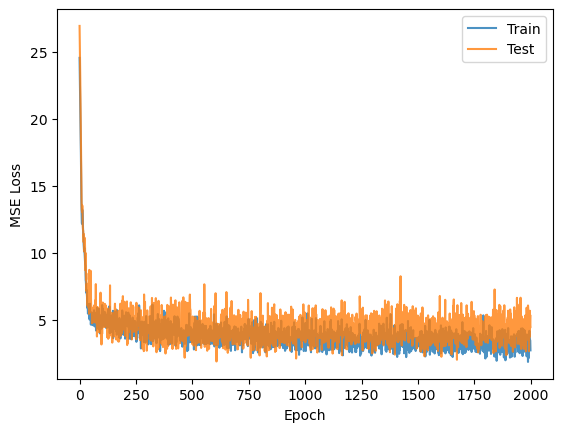

In [21]:
print('The best r2 value was:', best_R2)

fig, ax = plt.subplots()
ax.plot(train_loss_list, label='Train',alpha=0.8)
ax.plot(val_loss_list,label='Test',alpha=0.8)

#ax.set_ylim(0,2000)
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss')
ax.legend()

plt.show()

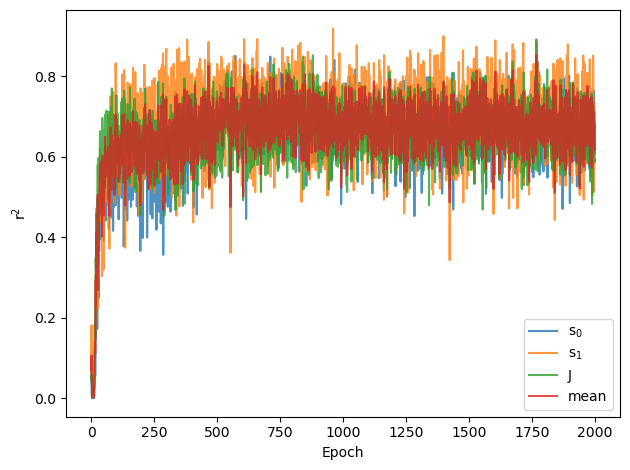

In [22]:
r2_array = np.array(r2_list)
labels = ['s$_0$', 's$_1$', 'J', 'mean']

fig, ax = plt.subplots()
for i in range(r2_array.shape[1]):
    ax.plot(r2_array[:,i],label=labels[i],alpha=0.8)

ax.set_xlabel('Epoch')
ax.set_ylabel('r$^2$')
ax.legend()
ax.tick_params(axis='both')
plt.tight_layout()
plt.show()

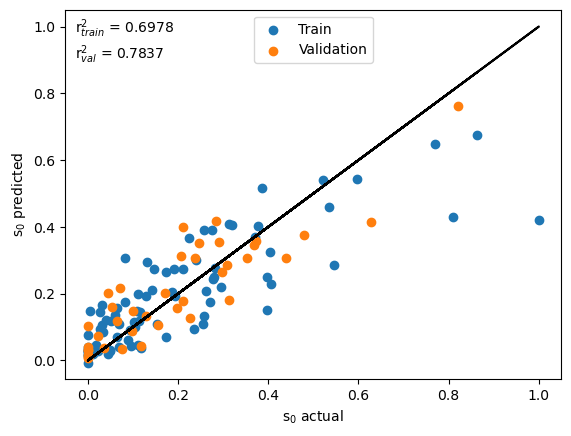

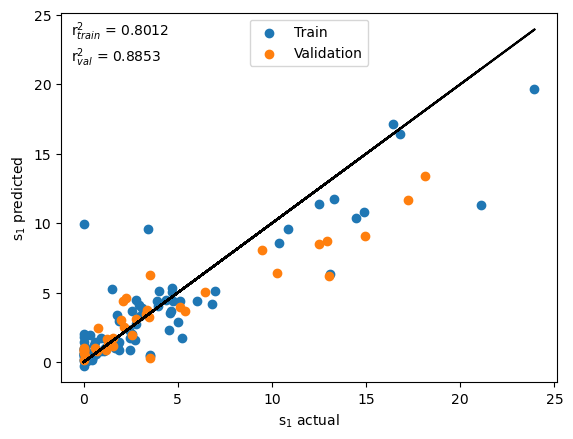

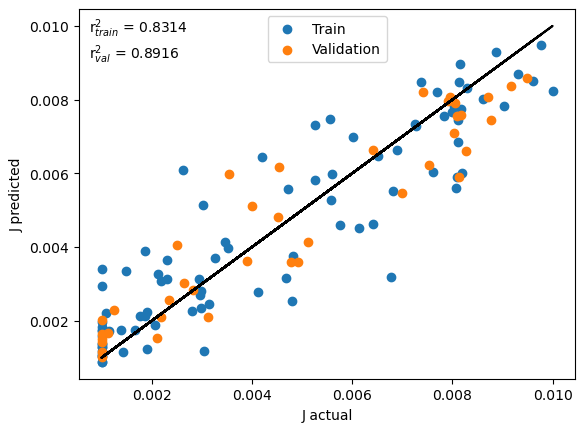

In [23]:
def plot_predictions(train_pred, train_actual, val_pred, val_actual, index, title):
    fig, ax = plt.subplots()
    
    r2_train = pearsonr(train_actual[:,index], train_pred[:,index])[0]**2
    r2_val = pearsonr(val_actual[:,index], val_pred[:,index])[0]**2
    
    ax.scatter(train_actual[:,index],train_pred[:,index],label='Train')
    ax.scatter(val_actual[:,index],val_pred[:,index],label='Validation')
    ax.plot(train_actual[:,index],train_actual[:,index],c='k')
    
    plt.text(0.02, 0.98, 'r$^2_{train}$ = %.4f\nr$^2_{val}$ = %.4f' % (r2_train,r2_val),
     horizontalalignment='left',
     verticalalignment='top',
     transform = ax.transAxes)

    ax.legend(loc='upper center')
        
    ax.set_xlabel('{} actual'.format(title))
    ax.set_ylabel('{} predicted'.format(title))
    ax.tick_params(axis='both')
    
    return ax

labels = ['s$_0$', 's$_1$', 'J']
atten = [10,1,1000]

for i,label in enumerate(labels):
    ax = plot_predictions(best_train_predictions/atten[i],best_train_actuals/atten[i],
                     best_val_predictions/atten[i], best_val_actuals/atten[i],i,label)

# Train for growth kinetics using Mixed features

In [9]:
datafile = 'PLD data.json'

# set the target to anomaly to train for P, E1, and E2.
# set the target to 'growth' to train for s0, s1, and J
target_params = 'growth'

BATCH_SIZE = 88

#############################
if target_params == 'anomaly':
    normalize_PTE1E2 = False
else:
    normalize_PTE1E2 = True

train_data, val_data = load_data(datafile, target_params, normalize_PTE1E2=normalize_PTE1E2, train_percent=70)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

Total number of samples: 127
Number of training samples: 88
Number of validation samples: 39


In [4]:
class MixedICCDNet(nn.Module):
    def __init__(self,l1=64,l2=32,param_l1=48,param_out=32,c1=16,c2=24,c3=32):
        super(MixedICCDNet, self).__init__()
        # ICCD imaging feature inputs, the full image size is BATCH,C,frames,H,W where it is N,50,40,40
        self.ICCD_features_ = nn.Sequential(
            #Spatial convolution
            nn.Conv3d(1,64, kernel_size=(1,3,3), stride=(1,1,1), padding=(0,1,1)),
            nn.BatchNorm3d(64),
            #Temportal convolution
            nn.Conv3d(64,64,kernel_size=(3,1,1), stride=(1,1,1), padding=(1,0,0)),
            nn.BatchNorm3d(64),
            nn.LeakyReLU(inplace=True),

            #Downsample
            nn.AvgPool3d(kernel_size=(2,2,2),stride=(2,2,2)),

            #Spatial convolution
            nn.Conv3d(64,128, kernel_size=(1,3,3), stride=(1,1,1), padding=(0,1,1)),
            nn.BatchNorm3d(128),
            #Temportal convolution
            nn.Conv3d(128,128,kernel_size=(3,1,1), stride=(1,1,1), padding=(1,0,0)),
            nn.BatchNorm3d(128),
            nn.LeakyReLU(inplace=True),

            #Downsample
            nn.AvgPool3d(kernel_size=(2,2,2),stride=(2,2,2)),

            #Spatial convolution
            nn.Conv3d(128,256, kernel_size=(1,3,3), stride=(1,1,1), padding=(0,1,1)),
            nn.BatchNorm3d(256),
            #Temportal convolution
            nn.Conv3d(256,256,kernel_size=(3,1,1), stride=(1,1,1), padding=(1,0,0)),
            nn.BatchNorm3d(256),
            nn.LeakyReLU(inplace=True),

            #Downsample
            nn.AvgPool3d(kernel_size=(2,2,2),stride=(2,2,2)),

            nn.Flatten(start_dim=1),
            nn.Linear(256*6*5*5,l1),
            nn.LeakyReLU(inplace=True),
            nn.Linear(l1,l2),
            nn.LeakyReLU(inplace=True),
            #nn.Linear(l2,3)
        )
        
        self.parameter_features = nn.Sequential(
            nn.Linear(4,param_l1),
            nn.LeakyReLU(inplace=True),
            nn.Linear(param_l1,param_out),
            nn.LeakyReLU(inplace=True),
            #nn.Linear(param_out,3)
        )
        
        self.combined_features_ = nn.Sequential(
            nn.Linear(l2+param_out,c1),
            nn.LeakyReLU(inplace=True),
            nn.Linear(c1,c2),
            nn.LeakyReLU(inplace=True),
            nn.Linear(c2,c3),
            nn.LeakyReLU(inplace=True),
            nn.Linear(c3,3),
        )

    def forward(self,x,y):
        x=self.ICCD_features_(x)
        y=self.parameter_features(y)
        x=x.view(x.shape[0],-1)
        y=y.view(y.shape[0],-1)        
        z = torch.cat((x,y),1)
        z = self.combined_features_(z)        
        return z

In [5]:
def model_train_best(config,ICCD_checkpoint=None, MLP_checkpoint=None):
    train_loss_list = []
    test_loss_list = []
    r2_list = []
    print(config['c1'],config['c2'],config['c3'])
    print("I'M TRAINING, I'M TRAINING!!")
    model = MixedICCDNet(l1=config['l1'],l2=config['l2'],param_l1=config['param_l1'],param_out=config['param_out'],c1=config['c1'],c2=config['c2'])
    
    if ICCD_checkpoint:
        weights = torch.load(ICCD_checkpoint)
        model.load_state_dict(weights,strict=False)
        #Freeze all layers in the ICCD_features_ part
        for param in model.ICCD_features_.parameters():
            param.requires_grad = False
        print('Loaded ICCD layers...')
        for param in model.ICCD_features_.parameters():
            if param.requires_grad:
                print('ERROR:Found trainable in ICCD')
        
    if MLP_checkpoint:
        weights = torch.load(MLP_checkpoint)
        model.load_state_dict(weights,strict=False)
        #Freeze all layers in the parameter_features part
        for param in model.parameter_features.parameters():
            param.requires_grad = False
        print('Loaded parameter MLP layers...')
        for param in model.parameter_features.parameters():
            if param.requires_grad:
                print('ERROR:Found trainable in ICCD')
    
    device = 'cpu'
    if torch.cuda.is_available():
        print('Using GPU.')
        device = "cuda:0"    
        if torch.cuda.device_count() > 1:
            print('Using multiple GPUs.')
            model = nn.DataParallel(model)
    model.to(device)
    loss_fn = nn.MSELoss()
    optimizer=optim.Adam(model.parameters(),lr=config['lr'],amsgrad=True,weight_decay=config['weight_decay'])
    
    BATCH_SIZE = 88
    train_data, val_data = load_data(datafile, train_percent=70)
    
    train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

    #print('Total image feature params:',sum(p.numel() for p in model.ICCD_features_.parameters()))
    #print('Total model params:',sum(p.numel() for p in model.parameters()))

    loss_values = []
    val_loss_values = []
    best_R2 = 0.0
    n_epochs=2000
    for epoch in range(1,n_epochs+1):
        loss_train = 0.0
        for id_batch, (image1,params,target) in enumerate(train_loader):
            image1=image1.to(device)
            params=params.to(device)
            score = target.to(device)
            
            optimizer.zero_grad()
            
            y_pred = model(image1,params)
            loss = loss_fn(y_pred, score)

            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        loss_values.append(loss_train/len(train_loader))
        print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(), epoch,
                                                          loss_train / len(train_loader)))
        
        train_pred, train_actuals = y_pred.cpu(), score.cpu()
        size = len(val_loader.dataset)
        num_batches = len(val_loader)
        test_loss = 0.0
        train_loss_list.append(loss_train)
        
        for (image1,params,target) in val_loader:
            with torch.no_grad():
                image1=image1.to(device)
                params=params.to(device)
                score = target.to(device)
                pred = model(image1,params)
                test_loss += loss_fn(pred, score).item()
                pr2 = pearsonr(score[:,0].cpu(), pred[:,0].cpu())[0]**2
                e1r2 = pearsonr(score[:,1].cpu(), pred[:,1].cpu())[0]**2
                e2r2 = pearsonr(score[:,2].cpu(), pred[:,2].cpu())[0]**2
                meanR2 = np.array([pr2,e1r2,e2r2]).mean()
                print('R2 values {:.4f}, {:.4f}, {:.4f}; mean R2={:.4f}'.format(pr2, e1r2, e2r2, meanR2))
                r2_list.append([pr2, e1r2, e2r2,meanR2])
                
        if meanR2>best_R2:
            print('New best, saving checkpoint...')
            best_R2 = meanR2
            best_val_predictions, best_val_actuals = pred.cpu().detach(), score.cpu().detach()
            best_train_predictions, best_train_actuals = train_pred.cpu().detach(), train_actuals.cpu().detach()
            
            torch.save(model.state_dict(), 'Model Checkpoints/103023 MixedICCDNet_3HL.model'.format(config['l1'],config['l2'], config['lr'],config['weight_decay']))
        test_loss /= num_batches
        test_loss_list.append(test_loss)
        val_loss_values.append(test_loss)
        print(f"Test Error: Avg loss: {test_loss:>8f} \n")
        #train.report({"mean_R2": meanR2})
        
    return best_R2, train_loss_list, test_loss_list, r2_list, best_train_predictions, best_train_actuals, best_val_predictions, best_val_actuals

In [8]:
checkpoint

OrderedDict([('ICCD_features_.0.weight',
              tensor([[[[[-0.1287,  0.2480, -0.0449],
                         [ 0.2529,  0.0185,  0.2721],
                         [ 0.0271,  0.0582, -0.3907]]]],
              
              
              
                      [[[[ 0.0671, -0.0004, -0.1629],
                         [-0.1324, -0.1244, -0.2062],
                         [ 0.1572,  0.0480, -0.1947]]]],
              
              
              
                      [[[[ 0.0518, -0.0058, -0.2445],
                         [ 0.1375, -0.2268,  0.1626],
                         [ 0.2572,  0.2073, -0.3331]]]],
              
              
              
                      [[[[ 0.0168, -0.1507, -0.0854],
                         [-0.0257, -0.2819,  0.0974],
                         [ 0.1311,  0.1231,  0.0042]]]],
              
              
              
                      [[[[-0.1594, -0.1955, -0.3071],
                         [-0.0687,  0.1508,  0.0592],
           

In [9]:
model

NameError: name 'model' is not defined

In [6]:
ICCD_checkpoint ='ICCDNet_l1-64.0000_l2-32.0000_lr-0.0014_L2-0.0005.model'
MLP_checkpoint = 'MLP_l1-48.0000_l2-32.0000_lr-0.0112_L2-0.0003.model'

config = {
        "l1": 64,
        "l2": 32,
        "param_l1": 48,
        "param_out": 32,
        "c1": 16,
        "c2": 24,
        "c3": 32,
        "lr": 0.001055047107715595,
        "weight_decay": 0.0018287918531623708,
        "ICCD checkpoint": os.path.abspath(ICCD_checkpoint),
        "param MLP checkpoint": os.path.abspath(MLP_checkpoint)
}

#
#config = best_result.config

best_R2, train_loss_list, test_loss_list, r2_list, best_train_predictions, best_train_actuals, best_val_predictions, best_val_actuals = model_train_best(config,ICCD_checkpoint=ICCD_checkpoint, MLP_checkpoint=MLP_checkpoint)

16 24 32
I'M TRAINING, I'M TRAINING!!


RuntimeError: Error(s) in loading state_dict for MixedICCDNet:
	size mismatch for ICCD_features_.19.weight: copying a param with shape torch.Size([64, 256]) from checkpoint, the shape in current model is torch.Size([64, 38400]).

In [21]:
# Choose between 'Mixed', 'ICCD', or 'Params'
features_to_use = 'Mixed' 

n_epochs=2000
learning_rate = 0.001055047107715595
L2 = 0.0018287918531623708

checkpoint_name = 'Growth Kinetics Mixed Input Checkpoint'

# here, we use the original checkpoints that were used in the paper, rather than the new ones created in this notebook

ICCD_checkpoint = 'ICCDNet_l1-64.0000_l2-32.0000_lr-0.0014_L2-0.0005.model'
MLP_checkpoint = 'MLP_l1-48.0000_l2-32.0000_lr-0.0112_L2-0.0003.model'

model = MixedICCDNet(
                     l1=64,        # MLP nodes layer 1 for ICCD features
                     l2=32,        # MLP nodes layer 2 for ICCD features
                     param_l1=48,  # MLP nodes layer 1 for parameter features
                     param_out=32, # MLP nodes layer 2 for parameter features
                     c1=16,        # MLP nodes layer 1 for combined features
                     c2=24,        # MLP nodes layer 1 for combined features
                     c3=32)        # MLP nodes layer 1 for combined features

# Train the model
results = train(model,train_loader,val_loader, n_epochs, learning_rate, L2, ICCD_checkpoint, MLP_checkpoint)

RuntimeError: Error(s) in loading state_dict for MixedICCDNet:
	size mismatch for ICCD_features_.19.weight: copying a param with shape torch.Size([64, 256]) from checkpoint, the shape in current model is torch.Size([64, 38400]).

In [ ]:
train_loss_list, val_loss_list, r2_list, best_R2, best_val_predictions,\
best_val_actuals,best_train_predictions, best_train_actuals = results

In [ ]:
print('The best r2 value was:', best_R2)

fig, ax = plt.subplots()
ax.plot(train_loss_list, label='Train',alpha=0.8)
ax.plot(val_loss_list,label='Test',alpha=0.8)

#ax.set_ylim(0,2000)
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss')
ax.legend()

plt.show()

In [ ]:
r2_array = np.array(r2_list)
labels = ['s$_0$', 's$_1$', 'J', 'mean']

fig, ax = plt.subplots()
for i in range(r2_array.shape[1]):
    ax.plot(r2_array[:,i],label=labels[i],alpha=0.8)

ax.set_xlabel('Epoch')
ax.set_ylabel('r$^2$')
ax.legend()
ax.tick_params(axis='both')
plt.tight_layout()
plt.show()

In [ ]:
def plot_predictions(train_pred, train_actual, val_pred, val_actual, index, title):
    fig, ax = plt.subplots()
    
    r2_train = pearsonr(train_actual[:,index], train_pred[:,index])[0]**2
    r2_val = pearsonr(val_actual[:,index], val_pred[:,index])[0]**2
    
    ax.scatter(train_actual[:,index],train_pred[:,index],label='Train')
    ax.scatter(val_actual[:,index],val_pred[:,index],label='Validation')
    ax.plot(train_actual[:,index],train_actual[:,index],c='k')
    
    plt.text(0.02, 0.98, 'r$^2_{train}$ = %.4f\nr$^2_{val}$ = %.4f' % (r2_train,r2_val),
     horizontalalignment='left',
     verticalalignment='top',
     transform = ax.transAxes)

    ax.legend(loc='upper center')
        
    ax.set_xlabel('{} actual'.format(title))
    ax.set_ylabel('{} predicted'.format(title))
    ax.tick_params(axis='both')
    
    return ax

labels = ['s$_0$', 's$_1$', 'J']
atten = [10,1,1000]

for i,label in enumerate(labels):
    ax = plot_predictions(best_train_predictions/atten[i],best_train_actuals/atten[i],
                     best_val_predictions/atten[i], best_val_actuals/atten[i],i,label)